# Import all the dependencies


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bioreactor.utils import *
from bioreactor.plotting import *
from bioreactor.use_colors import *
from bioreactor.ssgsea import *

import lightgbm as lgbm
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression

from bioreactor.annotation import *
from bioreactor.gsea import *
from bioreactor.expression import *
from bioreactor.pathway_scoring import *
from bioreactor.survival import *
from bioreactor.graphs import *

import warnings


import warnings

warnings.filterwarnings("ignore")


import seaborn as sns

sns.set_style("white")

In [ ]:
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests


def process_generic_dataset(df_scores, metadata):
    """
    Обрабатывает общий набор данных и вычисляет среднее значение, стандартное отклонение и p-value
    для сравнения между группами данных.

    Параметры:
        - df_scores (DataFrame): Датафрейм со значениями скоров для каждого сэмпла (строки) и сигнатуры (колонки).
        - metadata (Series): Серия с метаданными, определяющими группы сэмплов. В строках должны быть сэмплы, в значениях категории, всего может быть лишь 2 категории.

    Возвращает:
        - out (DataFrame): Датафрейм со средними значениями скоров для каждой группы и сигнатуры.
        - out_stdev (DataFrame): Датафрейм со стандартным отклонением скоров для каждой группы и сигнатуры.
        - out_mw_corrected (DataFrame): Датафрейм с поправленными значениями p-value для сравнения между группами.

    """
    df_scores, metadata = to_common_samples((df_scores.dropna(), metadata.dropna()))
    unique_groups = metadata.unique()
    num_groups = len(unique_groups)

    out = {group: {} for group in unique_groups}
    out_stdev = {group: {} for group in unique_groups}
    out_mw = {group: {} for group in unique_groups}

    for column in df_scores.columns:
        for group in unique_groups:
            group_data = df_scores[column].loc[metadata == group]

            out[group][column] = group_data.mean()
            out_stdev[group][column] = group_data.std()

            for other_group in unique_groups:
                if other_group != group:
                    other_group_data = df_scores[column].loc[metadata == other_group]
                    _, pv = mannwhitneyu(
                        group_data, other_group_data, alternative="two-sided"
                    )
                    out_mw[group][column] = pv

    out_mw = pd.DataFrame(out_mw)
    out_mw["{} vs {}".format(unique_groups[0], unique_groups[1])] = out_mw.T.mean()
    out_mw = out_mw.drop(columns=unique_groups)
    _, out_mw_flat, _, _ = multipletests(out_mw[out_mw.columns[0]], method="fdr_bh")
    out_mw_corrected = pd.DataFrame(
        data=out_mw_flat, index=out_mw.index, columns=out_mw.columns
    )

    return pd.DataFrame(out), pd.DataFrame(out_stdev), out_mw_corrected


def plot_waterfall(
    df_means,
    df_p_values,
    df_stdev,
    main_column=None,
    title=None,
    labels=None,
    save=True,
    path_to_save="~/waterfall.",
    format="svg",
    sort_by_list=False,
):
    """
    Строит waterfall-график для разницы между средними значениями скоров.

    Параметры:
        - df_means (DataFrame): Датафрейм со средними значениями скоров для каждой группы (колонки) и сигнатуры (строки).
        - df_p_values (DataFrame): Датафрейм с поправленными значениями p-value для сравнения между группами. Сигнатуры в строках, колонка одна.
        - df_stdev (DataFrame): Датафрейм со стандартным отклонением скоров для каждой группы (колонки) и сигнатуры (строки).
        - main_column (str): Название колонки, из которой будут вычитать другую колонку. Например, если main_column это наличие таргета, то будем смотреть на вычитание наличия из отсутствия, и наоборот.
        - title (str): Заголовок графика.
        - labels (Series): Серия с названиями для каждой сигнатуры, если хотим добавить другие названия.
        - save (bull): Сохранять ли плот. Default True.
        - path_to_save (str): Путь для сохранения файла, если не указан, сохраняет в "~/waterfall_plot.svg"
        - format (str): Формат сохранения файла. Default svg.

    """

    # Разница между значениями столбцов
    groups = df_means.columns
    dif = (
        df_means.T.loc[[main_column]].iloc[0]
        - df_means.T.loc[[i for i in groups if i != main_column]].iloc[0]
    )
    # Сортировка разницы по убыванию

    if sort_by_list:
        dif = dif.loc[sort_by_list]
    else:
        dif = dif.sort_values(ascending=False)

    # Получение интервалов доверия
    lower_bounds = df_stdev.min(axis=1)
    upper_bounds = df_stdev.max(axis=1)
    error_bars = upper_bounds - lower_bounds
    error_bars = error_bars.where(error_bars <= 500, np.nan)

    # Построение waterfall-графика
    sns.set_style("ticks")
    plt.rcParams.update({"font.size": 20})
    p = ["#a8e6cf" if x > 0 else "#ff8b94" for x in dif.values]
    fig, ax = plt.subplots(figsize=(11, 6))
    ax.bar(
        range(len(dif)),
        dif,
        color=p,
        yerr=error_bars.loc[dif.index],
        error_kw={"ecolor": "lightgray"},
    )
    if not labels:
        labels = pd.Series(index=dif.index, data=dif.index)
    plt.xticks(range(len(dif)), labels=labels.loc[dif.index], rotation=90)
    ax.set_xlabel("Signatures")
    ax.set_ylabel("Difference")
    ax.set_title(title)

    # Добавление значений p-value
    for i, value in enumerate(dif.values):
        p_value = df_p_values.loc[dif.index[i]][0]
        if p_value <= 0.05:
            if p_value <= 0.001:
                pv = "***"
            elif p_value <= 0.01:
                pv = "**"
            else:
                pv = "*"
        else:
            pv = "n/s"
        if value < 0:
            y = 10
        else:
            y = value + 10
        if pv != "n/s":
            ax.annotate(pv, (i, y), ha="center", va="center", size=17, c="black")
        else:
            ax.annotate(pv, (i, y), ha="center", va="bottom", size=13, c="black")
    plt.ylim(dif.min() - 100, dif.max() + 100)
    if title:
        plt.title(title)
    if save:
        plt.rcParams["svg.fonttype"] = "none"
        if "." + format in path_to_save.split("/")[-1]:
            path_to_save = path_to_save
        else:
            path_to_save = path_to_save + format
        plt.savefig(path_to_save, format=format, dpi=300)

In [ ]:
emt_signs = {
    "BG EMT FGES": ["SNAI1", "SNAI2", "TWIST1", "FOXM1", "RUNX2"],
    "BG SKCM-EMT FGES": ["SNAI1", "TWIST1", "ZEB1", "CDH2"],
    "Hallmark EMT FGES": [
        "ABI3BP",
        "ACTA2",
        "ADAM12",
        "ANPEP",
        "APLP1",
        "AREG",
        "BASP1",
        "BDNF",
        "BGN",
        "BMP1",
        "CADM1",
        "CALD1",
        "CALU",
        "CAP2",
        "CAPG",
        "CCN1",
        "CCN2",
        "CD44",
        "CD59",
        "CDH11",
        "CDH2",
        "CDH6",
        "COL11A1",
        "COL12A1",
        "COL16A1",
        "COL1A1",
        "COL1A2",
        "COL3A1",
        "COL4A1",
        "COL4A2",
        "COL5A1",
        "COL5A2",
        "COL5A3",
        "COL6A2",
        "COL6A3",
        "COL7A1",
        "COL8A2",
        "COLGALT1",
        "COMP",
        "COPA",
        "CRLF1",
        "CTHRC1",
        "CXCL1",
        "CXCL12",
        "CXCL6",
        "CXCL8",
        "DAB2",
        "DCN",
        "DKK1",
        "DPYSL3",
        "DST",
        "ECM1",
        "ECM2",
        "EDIL3",
        "EFEMP2",
        "ELN",
        "EMP3",
        "ENO2",
        "FAP",
        "FAS",
        "FBLN1",
        "FBLN2",
        "FBLN5",
        "FBN1",
        "FBN2",
        "FERMT2",
        "FGF2",
        "FLNA",
        "FMOD",
        "FN1",
        "FOXC2",
        "FSTL1",
        "FSTL3",
        "FUCA1",
        "FZD8",
        "GADD45A",
        "GADD45B",
        "GAS1",
        "GEM",
        "GJA1",
        "GLIPR1",
        "GPC1",
        "GPX7",
        "GREM1",
        "HTRA1",
        "ID2",
        "IGFBP2",
        "IGFBP3",
        "IGFBP4",
        "IL15",
        "IL32",
        "IL6",
        "INHBA",
        "ITGA2",
        "ITGA5",
        "ITGAV",
        "ITGB1",
        "ITGB3",
        "ITGB5",
        "JUN",
        "LAMA1",
        "LAMA2",
        "LAMA3",
        "LAMC1",
        "LAMC2",
        "LGALS1",
        "LOX",
        "LOXL1",
        "LOXL2",
        "LRP1",
        "LRRC15",
        "LUM",
        "MAGEE1",
        "MATN2",
        "MATN3",
        "MCM7",
        "MEST",
        "MFAP5",
        "MGP",
        "MMP1",
        "MMP14",
        "MMP2",
        "MMP3",
        "MSX1",
        "MXRA5",
        "MYL9",
        "MYLK",
        "NID2",
        "NNMT",
        "NOTCH2",
        "NT5E",
        "NTM",
        "OXTR",
        "P3H1",
        "PCOLCE",
        "PCOLCE2",
        "PDGFRB",
        "PDLIM4",
        "PFN2",
        "PLAUR",
        "PLOD1",
        "PLOD2",
        "PLOD3",
        "PMEPA1",
        "PMP22",
        "POSTN",
        "PPIB",
        "PRRX1",
        "PRSS2",
        "PTHLH",
        "PTX3",
        "PVR",
        "QSOX1",
        "RGS4",
        "RHOB",
        "SAT1",
        "SCG2",
        "SDC1",
        "SDC4",
        "SERPINE1",
        "SERPINE2",
        "SERPINH1",
        "SFRP1",
        "SFRP4",
        "SGCB",
        "SGCD",
        "SGCG",
        "SLC6A8",
        "SLIT2",
        "SLIT3",
        "SNAI2",
        "SNTB1",
        "SPARC",
        "SPOCK1",
        "SPP1",
        "TAGLN",
        "TFPI2",
        "TGFB1",
        "TGFBI",
        "TGFBR3",
        "TGM2",
        "THBS1",
        "THBS2",
        "THY1",
        "TIMP1",
        "TIMP3",
        "TNC",
        "TNFAIP3",
        "TNFRSF11B",
        "TNFRSF12A",
        "TPM1",
        "TPM2",
        "TPM4",
        "VCAM1",
        "VCAN",
        "VEGFA",
        "VEGFC",
        "VIM",
        "WIPF1",
        "WNT5A",
    ],
    "BG Metastasis FGES": ["CDH2", "MMP9", "PARP1", "HPSE", "MET", "SERPINH1", "HGF"],
    "Metastasis FGES, Ramaswamy et al.": "SNRPF	EIF4EL3	COL1A2	HNRPAB	DHPS	COL1A1	PTTG1	LMNB1".split(
        "\t"
    ),
    "Metastasis FGES, Albini et al.": [
        "ADAMTS1",
        "AGRN",
        "ANGPTL4",
        "COL1A1",
        "COL1A2",
        "COL6A1",
        "CPM",
        "CPN1",
        "CTGF",
        "CXCL1",
        "EFEMP1",
        "EREG",
        "F10",
        "FBLN2",
        "GPI",
        "IL13RA2",
        "LTBP1",
        "MATN2",
        "MMP1",
        "MMP2",
        "PTN",
        "SPARC",
        "TNC",
    ],
    "Metastasis FGES, Landemaine et al.": [
        "DSC2",
        "TFCP2L1",
        "UGT8",
        "ITGB8",
        "ANP32E",
        "FERMT1",
    ],
}

emt_gmt = {}
for i in emt_signs.keys():
    emt_gmt[i] = GeneSet(i, "", emt_signs[i])

In [ ]:
pigm = pd.read_csv("./data/TCGA_Pigmentation_Score.csv", index_col=0)
pigm_long = pd.read_csv("./data/TCGA_Pigmentation_Score.csv", index_col=0)[
    "Pigmentation_Score"
]
# skcm_expr = read_dataset('/uftp2/Datasets/TCGA/current_version/data/recombined_cohorts/TCGA-SKCM/expressions.tsv.gz') #Too large, kallisto-aligned TCGA data. See GDC portal
skcm_expr = skcm_expr.T
skcm_expr.index = skcm_expr.index.map(lambda x: x[:-3])
skcm_expr = skcm_expr[~skcm_expr.index.duplicated()]
skcm_anno = read_dataset("./data/TCGA-SKCM_annotation.tsv")
skcm_anno.index = skcm_anno.index.map(lambda x: x[:-3])
skcm_anno = skcm_anno[~skcm_anno.index.duplicated()]
pigm[pigm.isin([0])] = "Low_Pigment"
pigm[pigm.isin([1, 2, 3])] = "High_Pigment"
df_pigm = ssgsea_formula(skcm_expr.T, gmt_genes_alt_names(emt_gmt, skcm_expr.columns))
df_pigm = df_pigm.T

/tmp/ipykernel_797/1499322116.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Low_Pigment' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  pigm[pigm.isin([0])] = 'Low_Pigment'


In [9]:
pigm.reindex(df_pigm.index).dropna()

Pigmentation_Score
TCGA-FW-A3I3        Low_Pigment
TCGA-FS-A1ZD        Low_Pigment
TCGA-EE-A2M6       High_Pigment
TCGA-FS-A4FD        Low_Pigment
TCGA-EE-A3AD        Low_Pigment
...                         ...
TCGA-EE-A20C        Low_Pigment
TCGA-EB-A4OZ       High_Pigment
TCGA-EE-A2MR        Low_Pigment
TCGA-EE-A3J4        Low_Pigment
TCGA-EE-A2GH        Low_Pigment

[310 rows x 1 columns]

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


def boxplot_with_pvalue_new(
    data,
    categories,
    pvalues,
    columns_list,
    signs,
    palette=None,
    figsize=(12, 6),
    s=1,
    p_fontsize=16,
    p_digits=3,
    y_min=None,
    y_max=None,
    stars=True,
    title=None,
    xlabel=None,
):
    """
    Creates boxplots with swarmplots for selected columns, grouped by categories with p-values annotated.

    :param data: pd.Series, numerical data.
    :param categories: pd.Series, categorical data.
    :param p_values: pd.Series, p-values for each column.
    :param columns_list: list, list of column names to plot.
    :param signs: pd.Series, categorical data for labeling x-axis.
    :param palette: dict, colors for categories.
    :param figsize: tuple, size of the figure.
    :param s: int, size of the dots in swarmplot.
    :param p_fontsize: int, font size for p-value annotations.
    """
    plt.rcParams.update({"font.size": 20})
    if palette is None:
        palette = {categories.unique()[0]: "white", categories.unique()[1]: "blue"}

    # Setup the plot
    fig, ax = plt.subplots(figsize=figsize)

    # Create box and swarm plots
    sns.boxplot(x=signs, y=data, hue=categories, ax=ax, palette=palette, dodge=True)
    sns.swarmplot(
        x=signs,
        y=data,
        hue=categories,
        ax=ax,
        color="black",
        dodge=True,
        edgecolor="gray",
        linewidth=1,
        size=s,
    )

    y_max = y_max or data.max()
    y_min = y_min or data.min()
    effective_size = y_max - y_min
    plot_y_limits = (y_min - effective_size * 0.15, y_max + effective_size * 0.2)

    if p_digits > 0:
        pvalue_line_y_1 = y_max + effective_size * 0.05
        if figsize is None:
            figsize = define_ax_figsize(ax)
        pvalue_text_y_1 = pvalue_line_y_1 + 0.25 * effective_size / figsize[1]
        unique_signs = signs.unique()
        middle_pos = -0.5
        for i, sign in enumerate(unique_signs):
            middle_pos = -0.5 + i
            p_val = p_values.loc[sign]
            pvalue_str = get_pvalue_string(p_val, p_digits, stars=stars)
            pvalue_text_y_1_local = pvalue_text_y_1
            if pvalue_str == "-":
                pvalue_text_y_1_local += 0.1 * effective_size / figsize[1]
            bar_fraction = str(0.25 / 2.0 / (figsize[0] / float(len(order))))

            pos = middle_pos
            ax.annotate(
                "",
                xy=(pos + 0.2, pvalue_line_y_1),
                xycoords="data",
                xytext=(pos + 0.8, pvalue_line_y_1),
                textcoords="data",
                arrowprops=dict(
                    arrowstyle="-",
                    ec="#000000",
                    connectionstyle="bar,fraction={}".format(bar_fraction),
                ),
            )
            ax.text(
                pos + 0.5,
                pvalue_text_y_1_local,
                pvalue_str,
                fontsize=p_fontsize,
                horizontalalignment="center",
                verticalalignment="center",
            )

    ax.set_title(title)
    ax.set_ylim(plot_y_limits)
    ax.set_xlabel(xlabel)
    # Remove duplicate legend entries
    handles, labels = ax.get_legend_handles_labels()
    ax.set_xticklabels(order, rotation=90)
    ax.legend(
        handles[: int(len(handles) / 2)],
        categories.unique(),
        title="Category",
        loc="upper right",
        bbox_to_anchor=(1.2, 1),
    )

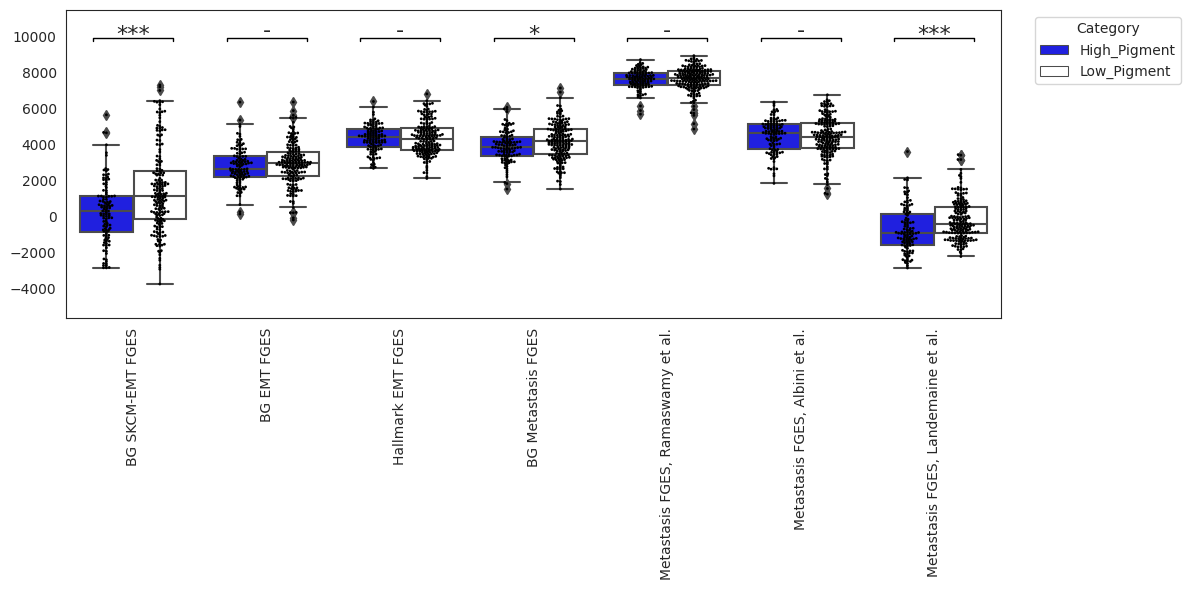

In [ ]:
out, out_stdev, out_mw_corrected = process_generic_dataset(
    df_pigm, pigm.Pigmentation_Score
)
order = [
    "BG SKCM-EMT FGES",
    "BG EMT FGES",
    "Hallmark EMT FGES",
    "BG Metastasis FGES",
    "Metastasis FGES, Ramaswamy et al.",
    "Metastasis FGES, Albini et al.",
    "Metastasis FGES, Landemaine et al.",
]
palette = {"Low_Pigment": "white", "High_Pigment": "blue"}
data = df_pigm.copy()[order]
grouping = pigm.Pigmentation_Score.copy()
p_values = out_mw_corrected.T.iloc[0].copy().loc[order]

data, grouping = to_common_samples((data, grouping))

numeric = pd.concat(
    [
        pd.Series(data=data[x].values, index=data[x].index.map(lambda i: f"{i}_{x}"))
        for x in order
    ],
    axis=0,
)
grouping = pd.concat(
    [
        pd.Series(data=grouping.values, index=grouping.index.map(lambda i: f"{i}_{x}"))
        for x in order
    ]
)
signs = pd.concat(
    [
        pd.Series(data=[x] * len(data), index=data[x].index.map(lambda i: f"{i}_{x}"))
        for x in order
    ],
    axis=0,
)

boxplot_with_pvalue_new(
    data=numeric,
    categories=grouping,
    pvalues=p_values,
    columns_list=order,
    signs=signs,
    palette=palette,
)
plt.tight_layout()
plt.savefig(
    "/home/jovyan/projects/SignVal/Signature_validation/article/EMT_Met_compare/pigm_boxplots.svg",
    format="svg",
)

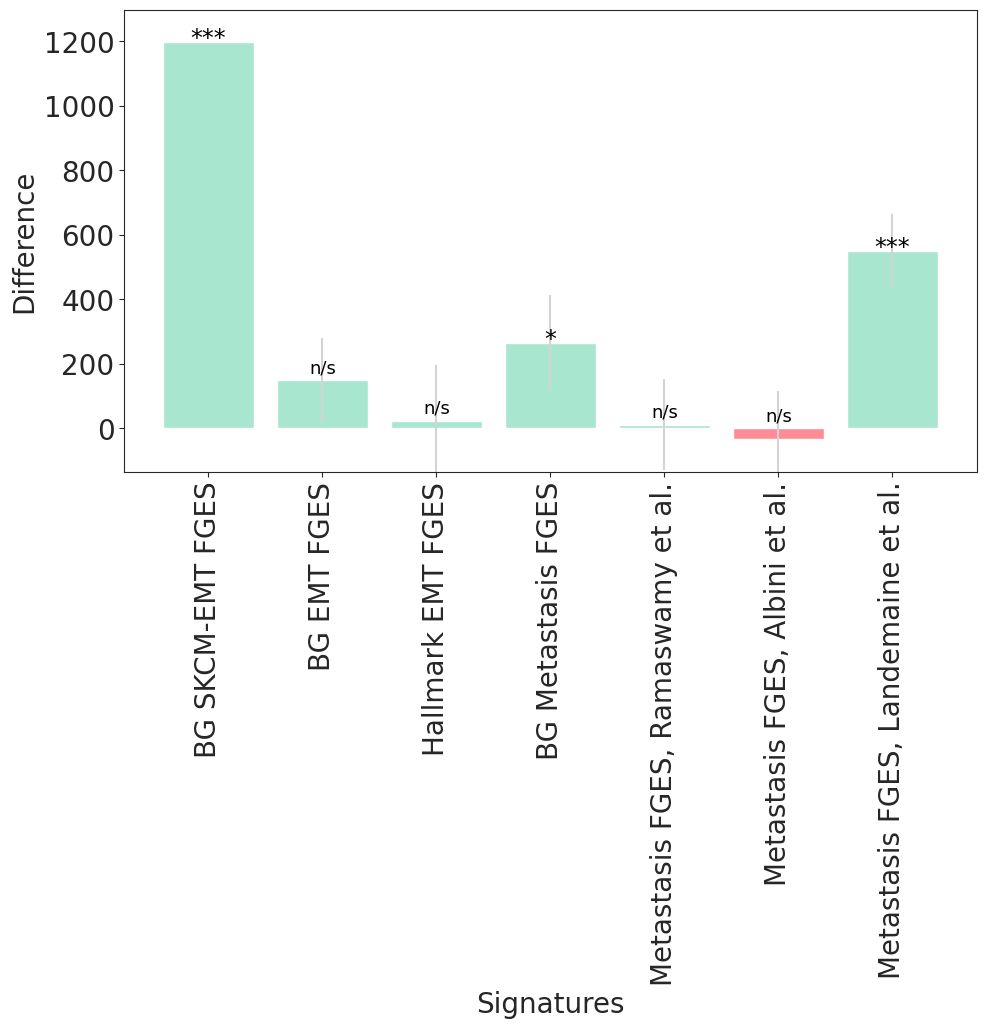

In [ ]:
out, out_stdev, out_mw_corrected = process_generic_dataset(
    df_pigm, pigm.Pigmentation_Score
)
plot_waterfall(
    out,
    out_mw_corrected,
    out_stdev,
    main_column="Low_Pigment",
    path_to_save="/home/jovyan/projects/SignVal/Signature_validation/article/EMT_Met_compare/pigm_waterfall.svg",
    sort_by_list=order,
)

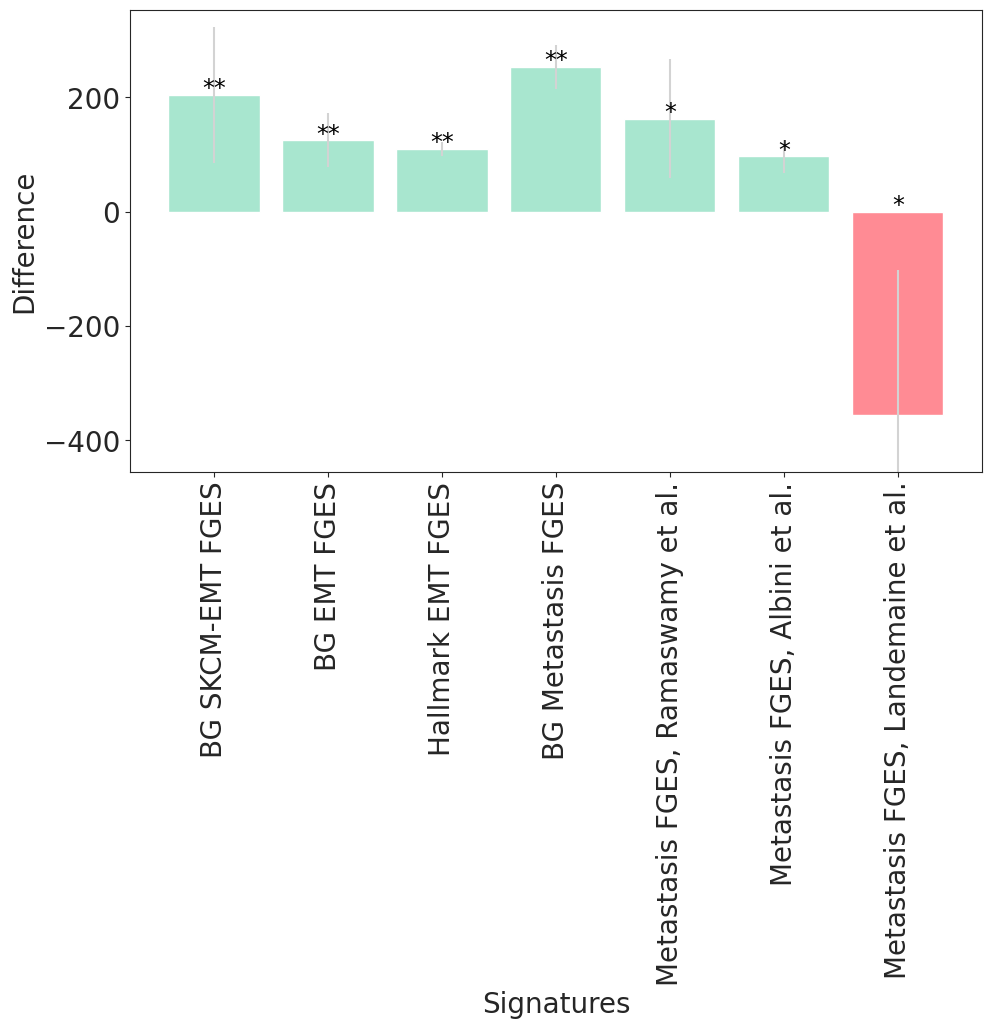

In [ ]:
expr_br = read_dataset(
    "/uftp/users/nlukashevich/CHESS/Sign_Val_Article/GSE48091_GPL10379_source_not_raw_max_gs_samples.tsv"
)
anno_br = read_dataset(
    "/uftp/users/nlukashevich/CHESS/Sign_Val_Article/GSE48091_common_annotation.tsv"
)
for i in anno_br["characteristics_ch1.setnr"].index:
    if len(anno_br["characteristics_ch1.setnr"].loc[i]) > 4:
        anno_br["characteristics_ch1.setnr"].loc[i] = int(
            anno_br["characteristics_ch1.setnr"].loc[i].split(",")[0]
        )
    else:
        anno_br["characteristics_ch1.setnr"].loc[i] = int(
            anno_br["characteristics_ch1.setnr"].loc[i]
        )
anno_br["risk_sets"] = anno_br["characteristics_ch1.setnr"]
anno_br["risk_sets"][anno_br["characteristics_ch1.setnr"] < 2000] = 1
anno_br["risk_sets"][anno_br["characteristics_ch1.setnr"] > 3000] = 3
anno_br["risk_sets"][~anno_br["risk_sets"].isin([1, 3])] = 2
for i in anno_br["characteristics_ch1.case-control status"].index:
    if len(anno_br["characteristics_ch1.case-control status"].loc[i]) > 1:
        anno_br["characteristics_ch1.case-control status"].loc[i] = sum(
            [
                int(x)
                for x in anno_br["characteristics_ch1.case-control status"]
                .loc[i]
                .split(",")
            ]
        )
    else:
        anno_br["characteristics_ch1.case-control status"].loc[i] = int(
            anno_br["characteristics_ch1.case-control status"].loc[i]
        )
anno_br["metastasis_status"] = anno_br["characteristics_ch1.case-control status"]
df_br = ssgsea_formula(expr_br, gmt_genes_alt_names(emt_gmt, expr_br.index)).T

out, out_stdev, out_mw_corrected = process_generic_dataset(
    df_br, anno_br["metastasis_status"]
)
plot_waterfall(
    out,
    out_mw_corrected,
    out_stdev,
    main_column=1,
    path_to_save="/home/jovyan/projects/SignVal/Signature_validation/article/EMT_Met_compare/met_br_waterfall.svg",
    sort_by_list=order,
)

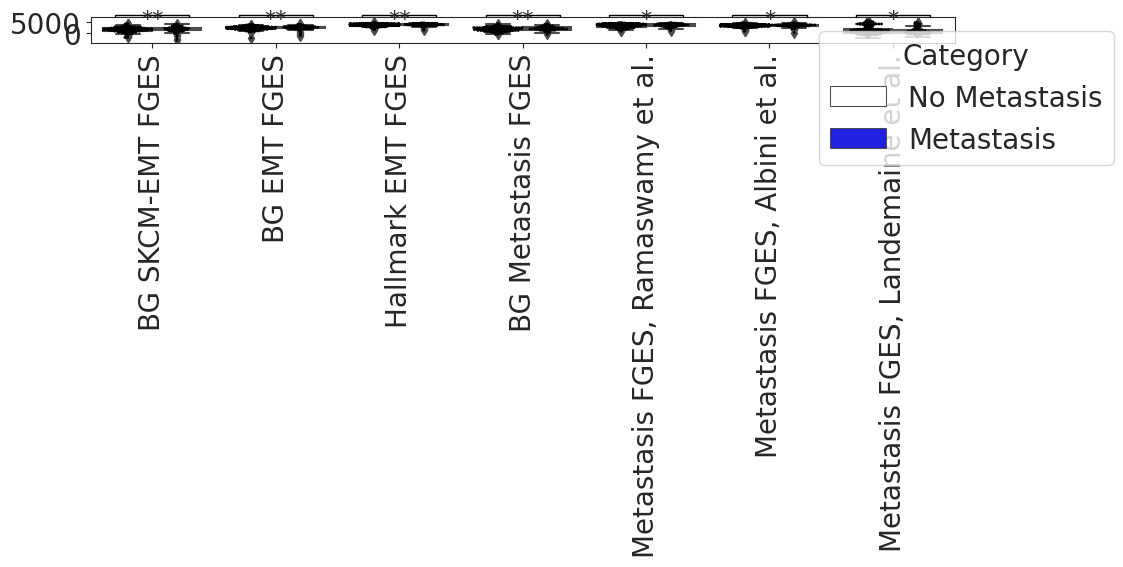

In [ ]:
palette = {"No Metastasis": "white", "Metastasis": "blue"}
data = df_br.copy()[order]
grouping = anno_br["metastasis_status"].map(
    lambda x: "No Metastasis" if x == 0 else "Metastasis"
)
p_values = out_mw_corrected.T.iloc[0].copy().loc[order]

data, grouping = to_common_samples((data, grouping))

numeric = pd.concat(
    [
        pd.Series(data=data[x].values, index=data[x].index.map(lambda i: f"{i}_{x}"))
        for x in order
    ],
    axis=0,
)
grouping = pd.concat(
    [
        pd.Series(data=grouping.values, index=grouping.index.map(lambda i: f"{i}_{x}"))
        for x in order
    ]
)
signs = pd.concat(
    [
        pd.Series(data=[x] * len(data), index=data[x].index.map(lambda i: f"{i}_{x}"))
        for x in order
    ],
    axis=0,
)

boxplot_with_pvalue_new(
    data=numeric,
    categories=grouping,
    pvalues=p_values,
    columns_list=order,
    signs=signs,
    palette=palette,
)
plt.tight_layout()
plt.savefig(
    "/home/jovyan/projects/SignVal/Signature_validation/article/EMT_Met_compare/met_br_boxplots.svg",
    format="svg",
)

In [6]:
df_pigm_sc = median_scale(df_pigm)
df_br_sc = median_scale(df_br)

In [7]:
%config InlineBackend.figure_format = 'svg'
plt.rcParams['pdf.fonttype'] = 'truetype'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['figure.dpi'] = 200
plt.rcParams['svg.fonttype'] = 'none'

sns.set_style('ticks')
sns.axes_style('white')

{'figure.facecolor': 'white',
 'axes.labelcolor': '.15',
 'xtick.direction': 'out',
 'ytick.direction': 'out',
 'xtick.color': '.15',
 'ytick.color': '.15',
 'axes.axisbelow': True,
 'grid.linestyle': '-',
 'text.color': '.15',
 'font.family': ['sans-serif'],
 'font.sans-serif': ['Arial',
  'DejaVu Sans',
  'Liberation Sans',
  'Bitstream Vera Sans',
  'sans-serif'],
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'image.cmap': 'rocket',
 'xtick.top': False,
 'ytick.right': False,
 'axes.grid': False,
 'axes.facecolor': 'white',
 'axes.edgecolor': '.15',
 'grid.color': '.8',
 'axes.spines.left': True,
 'axes.spines.bottom': True,
 'axes.spines.right': True,
 'axes.spines.top': True,
 'xtick.bottom': False,
 'ytick.left': False}

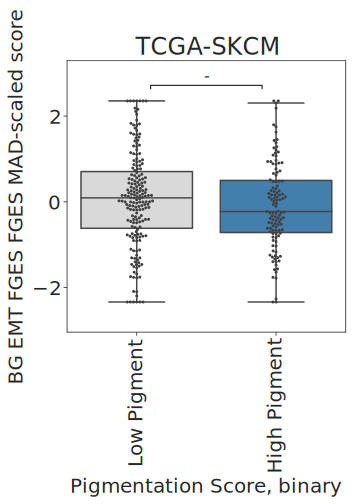

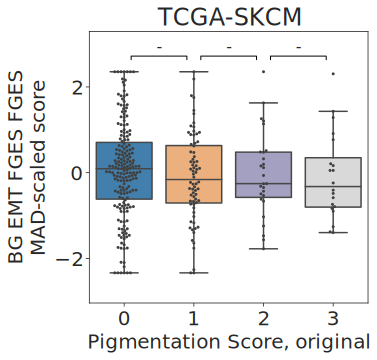

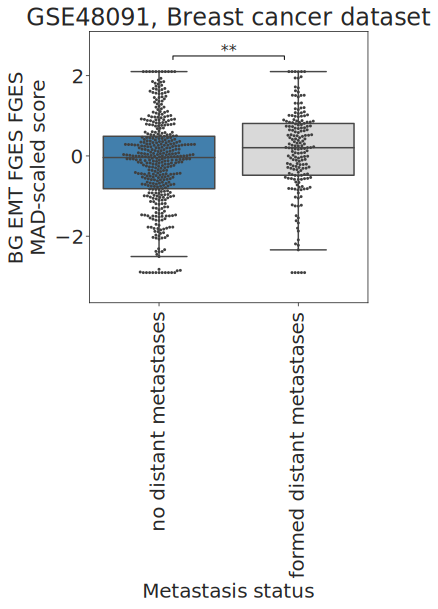

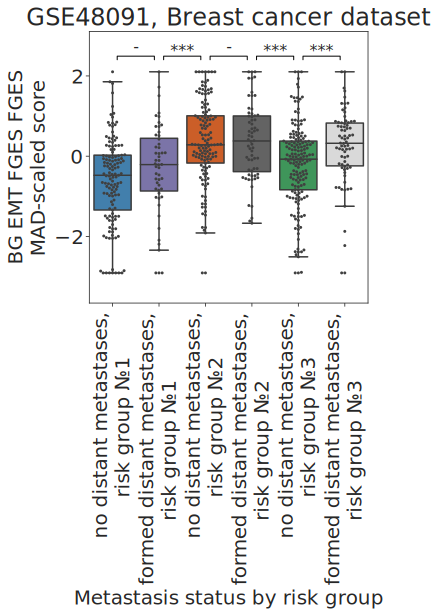

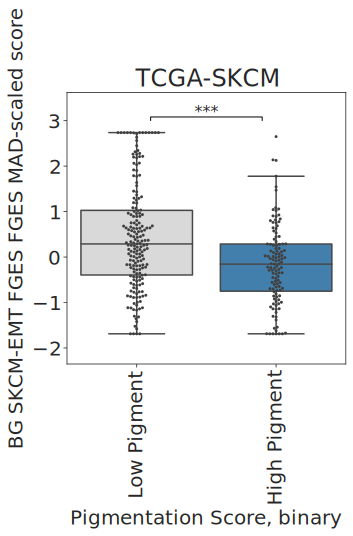

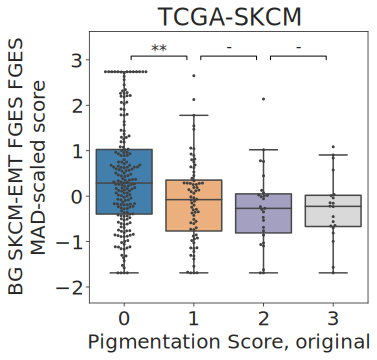

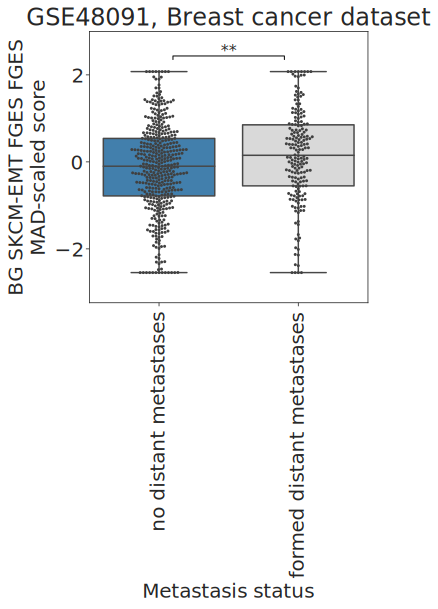

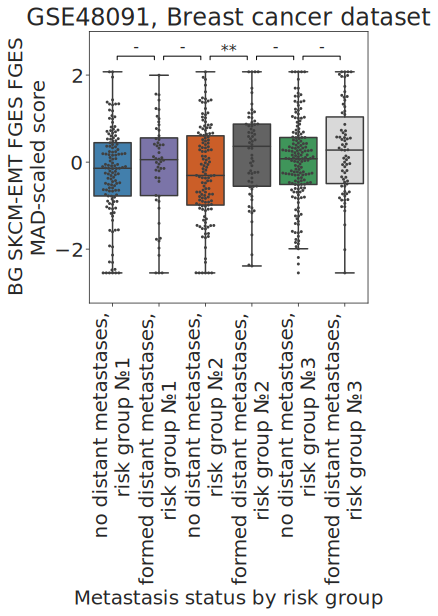

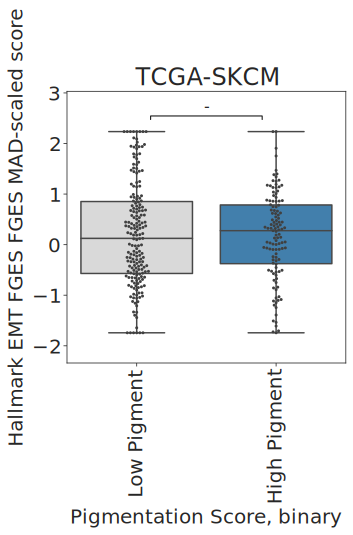

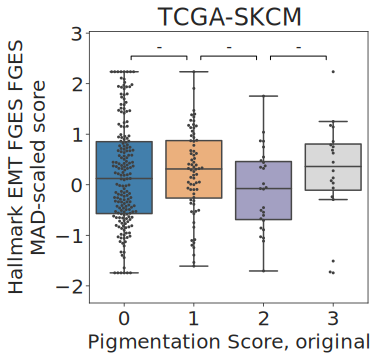

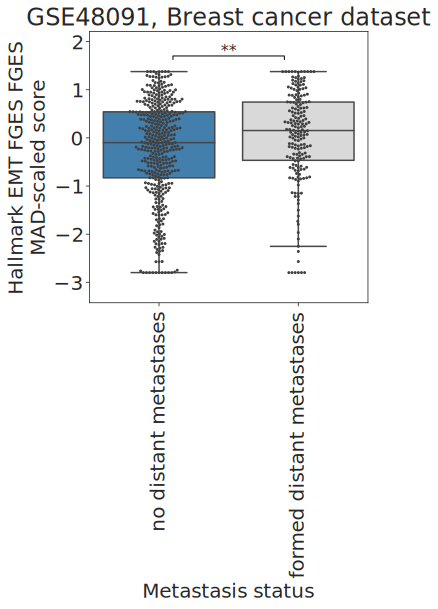

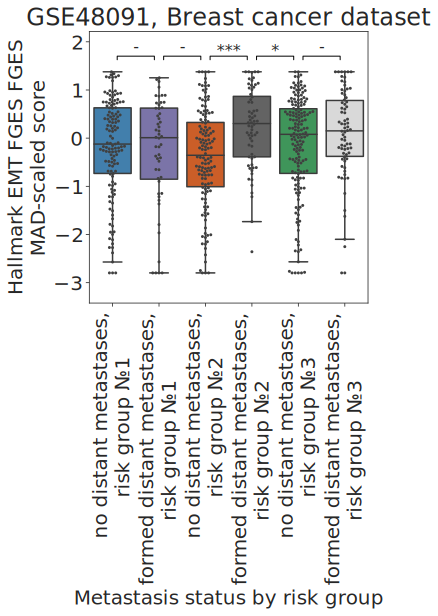

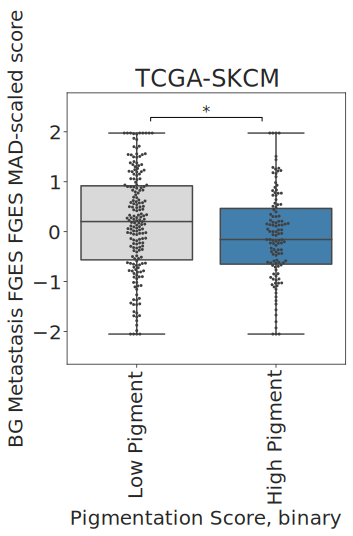

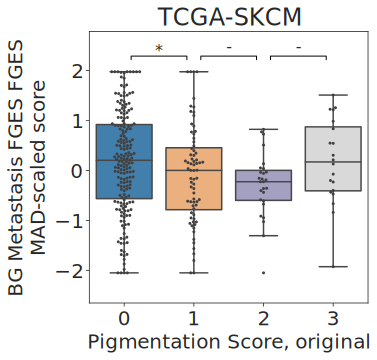

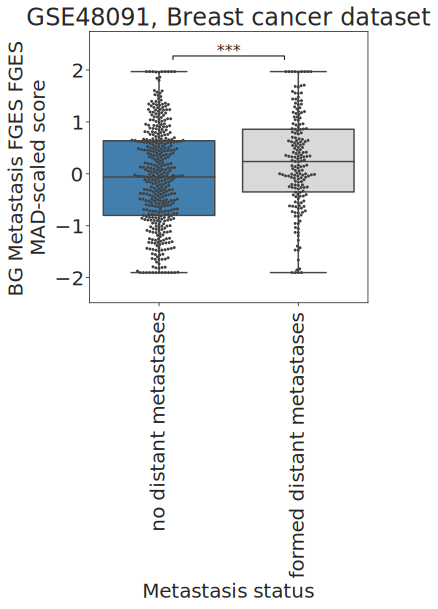

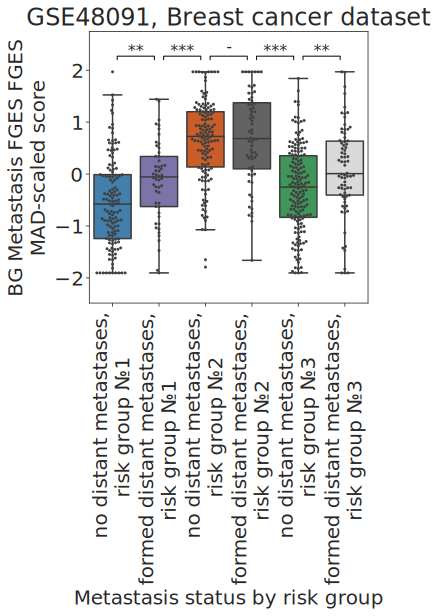

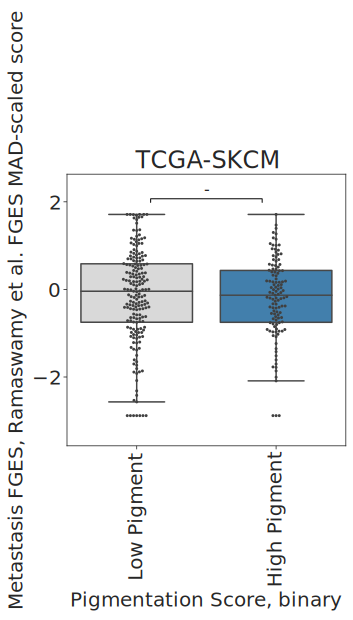

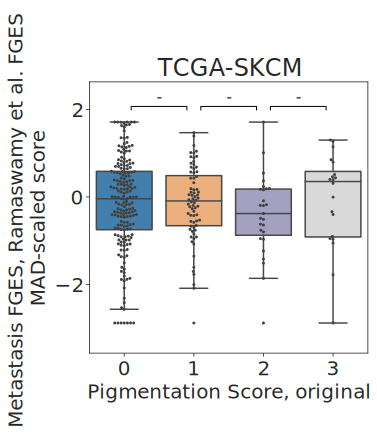

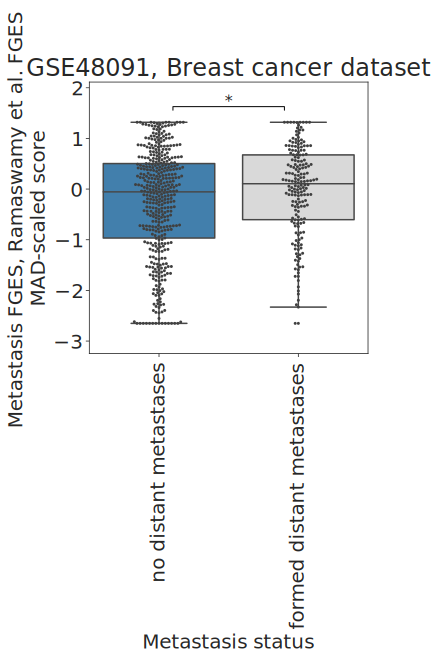

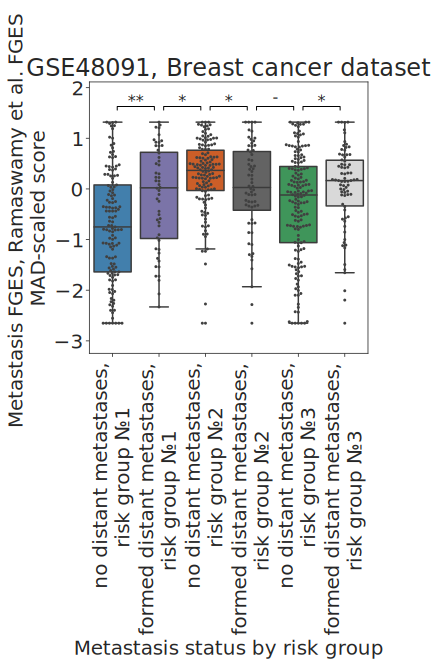

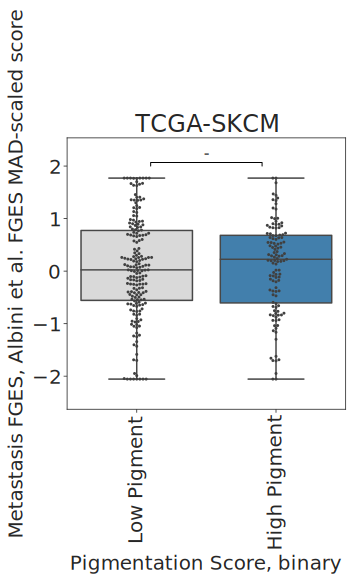

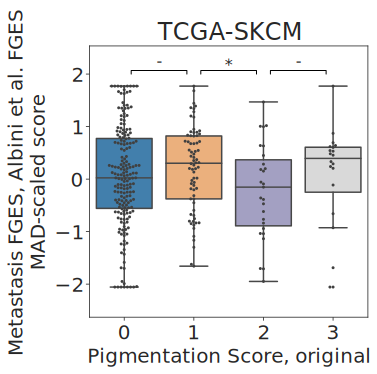

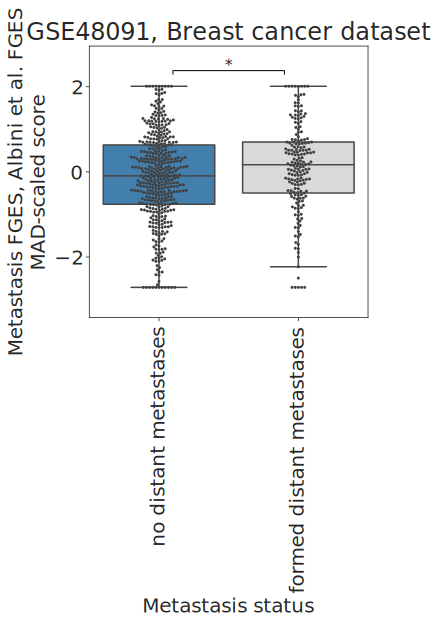

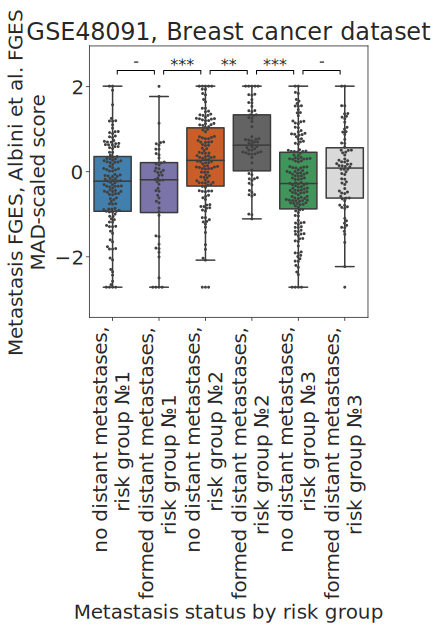

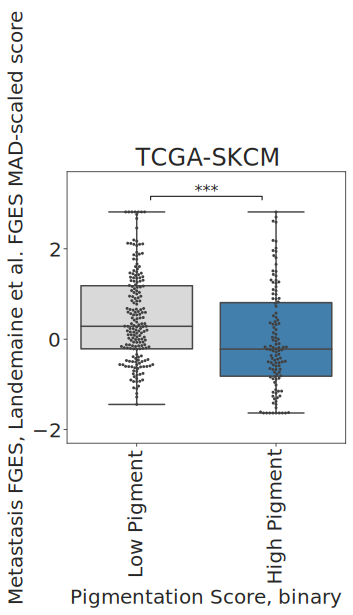

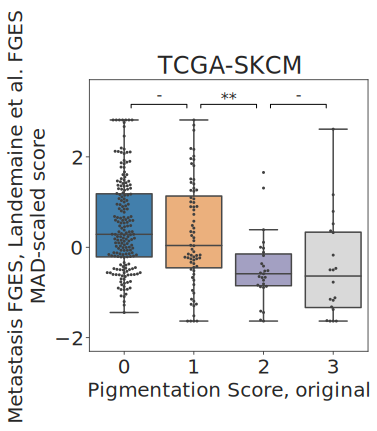

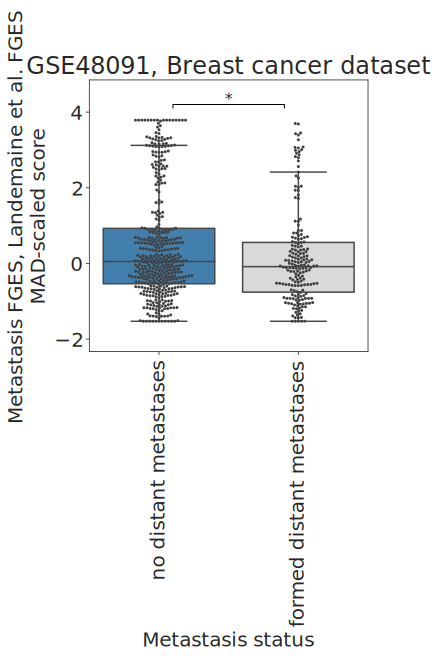

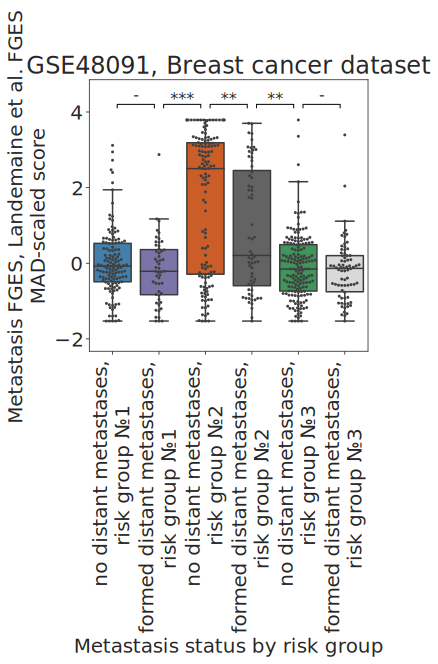

In [ ]:
sns.set_style("ticks")
for sign in emt_signs.keys():
    title = sign.replace("Main4_", "").replace("_", " ") + " FGES"
    fig, ax = plt.subplots(figsize=(5, 5))
    pal = lin_colors(pigm["Pigmentation_Score"], cmap=matplotlib.colormaps["tab20c"])
    order = ["Low_Pigment", "High_Pigment"]
    boxplot_with_pvalue(
        df_pigm_sc[sign].clip(
            df_pigm_sc[sign].quantile(0.025), df_pigm_sc[sign].quantile(0.975)
        ),
        pigm["Pigmentation_Score"],
        order=order,
        palette=pal,
        ax=ax,
        s=3,
    )
    ax.set_xlabel("Pigmentation Score, binary")
    ax.set_ylabel(
        sign.replace("Main4_", "").replace("_", " ") + " FGES MAD-scaled score"
    )
    ax.set_title("TCGA-SKCM")
    ax.set_xticklabels([i.replace("_", " ") for i in order], rotation=90)
    # plt.tight_layout(pad=.5)
    plt.savefig(
        f"boxplots/{title}_TCGA-SKCM_Pigmentation Score, binary.svg".replace(" ", "_")
        .replace("-", "_")
        .replace(",", "_")
        .replace(".", "_")
        .replace("__", "_")
        .replace("_svg", ".svg"),
        format="svg",
    )
    plt.show()
    plt.close()
    fig, ax = plt.subplots(figsize=(5, 5))
    pal = lin_colors(pigm_long, cmap=matplotlib.colormaps["tab20c"])
    boxplot_with_pvalue(
        df_pigm_sc[sign].clip(
            df_pigm_sc[sign].quantile(0.025), df_pigm_sc[sign].quantile(0.975)
        ),
        pigm_long,
        order=[0, 1, 2, 3],
        palette=pal,
        ax=ax,
        s=3,
    )
    ax.set_xlabel("Pigmentation Score, original")
    ax.set_ylabel(
        sign.replace("Main4_", "").replace("_", " ") + " FGES\nMAD-scaled score"
    )
    ax.set_title("TCGA-SKCM")
    # plt.tight_layout(pad=.5)
    plt.savefig(
        f"boxplots/{title}_TCGA-SKCM_Pigmentation Score, original.svg".replace(" ", "_")
        .replace("-", "_")
        .replace(",", "_")
        .replace(".", "_")
        .replace("__", "_")
        .replace("_svg", ".svg"),
        format="svg",
    )
    plt.show()
    plt.close()
    fig, ax = plt.subplots(figsize=(5, 5))
    pal = lin_colors(anno_br["metastasis_status"], cmap=matplotlib.colormaps["tab20c"])
    boxplot_with_pvalue(
        df_br_sc[sign].clip(
            df_br_sc[sign].quantile(0.025), df_br_sc[sign].quantile(0.975)
        ),
        anno_br["metastasis_status"],
        order=[0, 1],
        palette=pal,
        ax=ax,
        s=3,
    )
    ax.set_xticklabels(
        ["no distant metastases", "formed distant metastases"], rotation=90
    )
    ax.set_xlabel("Metastasis status")
    ax.set_title("GSE48091, Breast cancer dataset")
    ax.set_ylabel(
        sign.replace("Main4_", "").replace("_", " ") + " FGES\nMAD-scaled score"
    )
    # plt.tight_layout(pad=.5)
    plt.savefig(
        f"boxplots/{title}_GSE48091, Breast cancer dataset_Metastasis status.svg".replace(
            " ", "_"
        )
        .replace("-", "_")
        .replace(",", "_")
        .replace(".", "_")
        .replace("__", "_")
        .replace("_svg", ".svg"),
        format="svg",
    )
    plt.show()
    plt.close()
    fig, ax = plt.subplots(figsize=(5, 5))
    ser = anno_br["metastasis_status"].map(lambda x: f"metastasis {x}, ") + anno_br[
        "risk_sets"
    ].map(lambda x: f"risk {x}")
    pal = lin_colors(ser, cmap=matplotlib.colormaps["tab20c"])
    order = [
        "metastasis 0, risk 1",
        "metastasis 1, risk 1",
        "metastasis 0, risk 2",
        "metastasis 1, risk 2",
        "metastasis 0, risk 3",
        "metastasis 1, risk 3",
    ]
    boxplot_with_pvalue(
        df_br_sc[sign].clip(
            df_br_sc[sign].quantile(0.025), df_br_sc[sign].quantile(0.975)
        ),
        ser,
        order=order,
        palette=pal,
        ax=ax,
        s=3,
    )
    ax.set_xlabel("Metastasis status by risk group")
    ax.set_xticklabels(
        [
            i.replace("metastasis 0,", "no distant metastases,\n")
            .replace("metastasis 1,", "formed distant metastases,\n")
            .replace("risk ", "risk group №")
            for i in order
        ],
        rotation=90,
    )
    ax.set_title("GSE48091, Breast cancer dataset")
    ax.set_ylabel(
        sign.replace("Main4_", "").replace("_", " ") + " FGES\nMAD-scaled score"
    )
    # plt.tight_layout(pad=.5)
    plt.savefig(
        f"boxplots/{title}_GSE48091, Breast cancer dataset_Metastasis status by risk group.svg".replace(
            " ", "_"
        )
        .replace("-", "_")
        .replace(",", "_")
        .replace(".", "_")
        .replace("__", "_")
        .replace("_svg", ".svg"),
        format="svg",
    )
    plt.show()
    plt.close()

In [36]:
f"boxplots/{title}_TCGA-SKCM_Pigmentation Score, binary"

'boxplots/Metastasis_FGES_Ramaswamy_et_al_FGES_TCGA_SKCM_Pigmentation_Score_binary'

## Heatmap

In [ ]:
out = {sign: {} for sign in emt_signs.keys()}
for sign in emt_signs.keys():
    out[sign]["Pigm Score, short"] = {
        "Low": df_pigm[sign]
        .reindex(
            pigm["Pigmentation_Score"][
                pigm["Pigmentation_Score"] == "Low_Pigment"
            ].index
        )
        .dropna()
        .mean(),
        "High": df_pigm[sign]
        .reindex(
            pigm["Pigmentation_Score"][
                pigm["Pigmentation_Score"] == "High_Pigment"
            ].index
        )
        .dropna()
        .mean(),
    }
    # out[sign]['Pigm Score, long'] = {'Low':df_pigm[sign].reindex(pigm_long[pigm_long==0].index).dropna().mean(),
    #                                  'Medlow':df_pigm[sign].reindex(pigm_long[pigm_long==1].index).dropna().mean(),
    #                                 'Medhigh':df_pigm[sign].reindex(pigm_long[pigm_long==2].index).dropna().mean(),
    #                                  'High':df_pigm[sign].reindex(pigm_long[pigm_long==3].index).dropna().mean(),}
    # out[sign]['Breast Metastasis, w/o risks'] = {'No metastasis':df_br[sign].reindex(anno_br['metastasis_status'][anno_br['metastasis_status']==0].index).dropna().mean(),
    #                                  'Metastasis':df_br[sign].reindex(anno_br['metastasis_status'][anno_br['metastasis_status']==1].index).dropna().mean(),
    #                                 }
    # ser = anno_br['metastasis_status'].map(lambda x:f'metastasis {x}, ')+anno_br['risk_sets'].map(lambda x:f'risk {x}')
    # out[sign]['Breast Metastasis, w risks'] = {x:df_br[sign].reindex(ser[ser==x].index).dropna().mean() for x in [ 'metastasis 0, risk 1', 'metastasis 1, risk 1', 'metastasis 0, risk 2',
    #    'metastasis 1, risk 2','metastasis 0, risk 3', 'metastasis 1, risk 3', ]}

In [ ]:
pd.DataFrame(out[list(out.keys())[0]]).T.index
cols = [
    "Pigm Score, short",
    # 'Pigm Score, long',
    #  'Breast Metastasis, w/o risks',
    # 'Breast Metastasis, w risks'
]
tables = {col: {sign: None for sign in out.keys()} for col in cols}
for sign in out.keys():
    for col in cols:
        tables[col][sign] = pd.DataFrame(out[sign])[col]

In [ ]:
import pandas as pd
from scipy.stats import mannwhitneyu


def process_generic_dataset(df_scores, df_metadata, group_col, score_col):
    """
    Processes the generic dataset to compute the mean, standard deviation, and perform the Mann-Whitney U test for each column.

    Parameters:
        - df_scores (pandas.DataFrame): The dataframe containing the scores.
        - df_metadata (pandas.DataFrame): The dataframe containing metadata information.
        - group_col (str): The column name in df_metadata representing the groups.
        - score_col (str): The column name in df_scores representing the scores.

    Returns:
        - out (dict): A nested dictionary with the mean values for each column and group.
        - out_stdev (dict): A nested dictionary with the standard deviation values for each column and group.
        - out_mw (pandas.DataFrame): A dataframe with the p-values resulting from the Mann-Whitney U test.
    """
    unique_groups = df_metadata[group_col].unique()
    num_groups = len(unique_groups)

    out = {group: {} for group in unique_groups}
    out_stdev = {group: {} for group in unique_groups}
    out_mw = {group: {} for group in unique_groups}

    for group in unique_groups:
        group_data = (
            df_scores[score_col]
            .reindex(df_metadata[df_metadata[group_col] == group].index)
            .dropna()
        )

        out[group][score_col] = group_data.mean()
        out_stdev[group][score_col] = group_data.std()

        for other_group in unique_groups:
            if other_group != group:
                other_group_data = (
                    df_scores[score_col]
                    .reindex(df_metadata[df_metadata[group_col] == other_group].index)
                    .dropna()
                )
                _, p_value = mannwhitneyu(
                    group_data, other_group_data, alternative="two-sided"
                )
                out_mw[group][other_group] = p_value

    out_mw = pd.DataFrame(out_mw)

    return out, out_stdev, out_mw


out, out_stdev, out_mw = process_generic_dataset(
    df_scores, df_metadata, "GroupColumn", "BG EMT FGES"
)
print(out)
print(out_stdev)
print(out_mw)

NameError: name 'df_scores' is not defined

In [ ]:
out_stdev = {sign: {} for sign in emt_signs.keys()}
for sign in emt_signs.keys():
    out_stdev[sign]["Pigm Score, short"] = {
        "Low": df_pigm[sign]
        .reindex(
            pigm["Pigmentation_Score"][
                pigm["Pigmentation_Score"] == "Low_Pigment"
            ].index
        )
        .dropna()
        .std(),
        "High": df_pigm[sign]
        .reindex(
            pigm["Pigmentation_Score"][
                pigm["Pigmentation_Score"] == "High_Pigment"
            ].index
        )
        .dropna()
        .std(),
    }
    # out_stdev[sign]['Pigm Score, long'] = {'Low':df_pigm[sign].reindex(pigm_long[pigm_long==0].index).dropna().std(),
    #                                  'Medlow':df_pigm[sign].reindex(pigm_long[pigm_long==1].index).dropna().std(),
    #                                 'Medhigh':df_pigm[sign].reindex(pigm_long[pigm_long==2].index).dropna().std(),
    #                                  'High':df_pigm[sign].reindex(pigm_long[pigm_long==3].index).dropna().std(),}
    # out_stdev[sign]['Breast Metastasis, w/o risks'] = {'No metastasis':df_br[sign].reindex(anno_br['metastasis_status'][anno_br['metastasis_status']==0].index).dropna().std(),
    #                                  'Metastasis':df_br[sign].reindex(anno_br['metastasis_status'][anno_br['metastasis_status']==1].index).dropna().std(),
    #                                 }
    # ser = anno_br['metastasis_status'].map(lambda x:f'metastasis {x}, ')+anno_br['risk_sets'].map(lambda x:f'risk {x}')
    # out_stdev[sign]['Breast Metastasis, w risks'] = {x:df_br[sign].reindex(ser[ser==x].index).dropna().std() for x in [ 'metastasis 0, risk 1', 'metastasis 1, risk 1', 'metastasis 0, risk 2',
    #    'metastasis 1, risk 2','metastasis 0, risk 3', 'metastasis 1, risk 3', ]}

In [ ]:
pd.DataFrame(out_stdev[list(out.keys())[0]]).T.index
cols = [
    "Pigm Score, short",
    #  'Pigm Score, long', 'Breast Metastasis, w/o risks',
    # 'Breast Metastasis, w risks'
]
tables_stdev = {col: {sign: None for sign in out_stdev.keys()} for col in cols}
for sign in out_stdev.keys():
    for col in cols:
        tables_stdev[col][sign] = pd.DataFrame(out_stdev[sign])[col]

In [ ]:
out_mw = {sign: {} for sign in emt_signs.keys()}
for sign in emt_signs.keys():
    _, pv = mannwhitneyu(
        df_pigm[sign]
        .reindex(
            pigm["Pigmentation_Score"][
                pigm["Pigmentation_Score"] == "Low_Pigment"
            ].index
        )
        .dropna(),
        df_pigm[sign]
        .reindex(
            pigm["Pigmentation_Score"][
                pigm["Pigmentation_Score"] == "High_Pigment"
            ].index
        )
        .dropna(),
        alternative="two-sided",
    )
    out_mw[sign]["Pigm Score, short"] = pv
    # _, pv = mannwhitneyu(df_br[sign].reindex(anno_br['metastasis_status'][anno_br['metastasis_status']==1].index).dropna(),
    #                                                      df_br[sign].reindex(anno_br['metastasis_status'][anno_br['metastasis_status']==0].index).dropna(),
    #                                                     alternative='two-sided')
    # out_mw[sign]['Breast Metastasis, w/o risks'] = pv

    # riskgroup = 3
    # ser = anno_br['metastasis_status'].map(lambda x:f'metastasis {x}, ')+anno_br['risk_sets'].map(lambda x:f'risk {x}')
    # a = df_br[sign].reindex(ser[ser==f'metastasis 0, risk {riskgroup}'].index).dropna()
    # b = df_br[sign].reindex(ser[ser==f'metastasis 1, risk {riskgroup}'].index).dropna()
    # _, pv = mannwhitneyu(a, b, alternative='two-sided')
    # out_mw[sign]['Breast Metastasis, w risks'] = pv

In [ ]:
out_mw = pd.DataFrame(out_mw)
for i in out_mw.index:
    _, out_mw.loc[i], _, _ = multipletests(out_mw.loc[i], method="fdr_bh")

In [ ]:
out_mw_corrected.loc["BG EMT FGES"][0]

0.011176285349305278

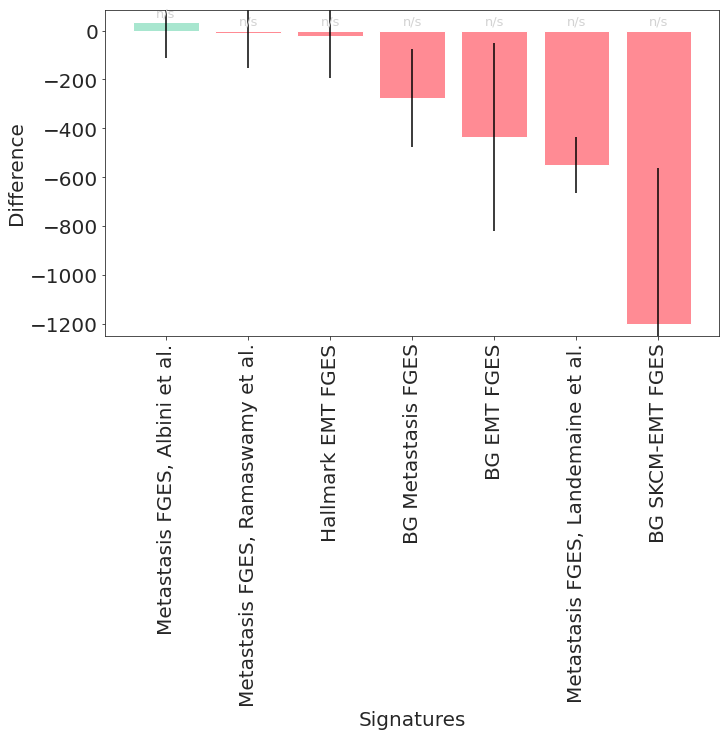

In [ ]:
out, out_stdev, out_mw_corrected = process_generic_dataset(
    df_pigm, pigm["Pigmentation_Score"]
)

TypeError: process_generic_dataset() missing 2 required positional arguments: 'group_col' and 'score_col'

In [ ]:
main_column = "High_Pigment"
df_means = out


dif

BG EMT FGES                           -434.432335
BG SKCM-EMT FGES                     -1197.873986
Hallmark EMT FGES                      -23.729310
BG Metastasis FGES                    -275.660149
Metastasis FGES, Ramaswamy et al.      -11.430124
Metastasis FGES, Landemaine et al.    -549.356549
Metastasis FGES, Albini et al.          34.745934
dtype: float64

In [88]:
lower_bounds = df_conf_intervals.min(axis=1)
upper_bounds = df_conf_intervals.max(axis=1)
error_bars = upper_bounds - lower_bounds

In [87]:
df_conf_intervals = out_stdev

In [89]:
error_bars

BG EMT FGES                           383.361981
BG SKCM-EMT FGES                      634.721705
Hallmark EMT FGES                     172.260908
BG Metastasis FGES                    199.348102
Metastasis FGES, Ramaswamy et al.     139.926287
Metastasis FGES, Landemaine et al.    115.218433
Metastasis FGES, Albini et al.        149.006029
dtype: float64

In [ ]:
pigm["Pigmentation_Score"]

Sample
TCGA-BF-A1PU    High_Pigment
TCGA-BF-A1PV     Low_Pigment
TCGA-BF-A1PX    High_Pigment
TCGA-BF-A1PZ     Low_Pigment
TCGA-BF-A1Q0     Low_Pigment
                    ...     
TCGA-GN-A26A    High_Pigment
TCGA-GN-A26C     Low_Pigment
TCGA-GN-A26D     Low_Pigment
TCGA-HR-A5NC     Low_Pigment
TCGA-IH-A3EA    High_Pigment
Name: Pigmentation_Score, Length: 323, dtype: object

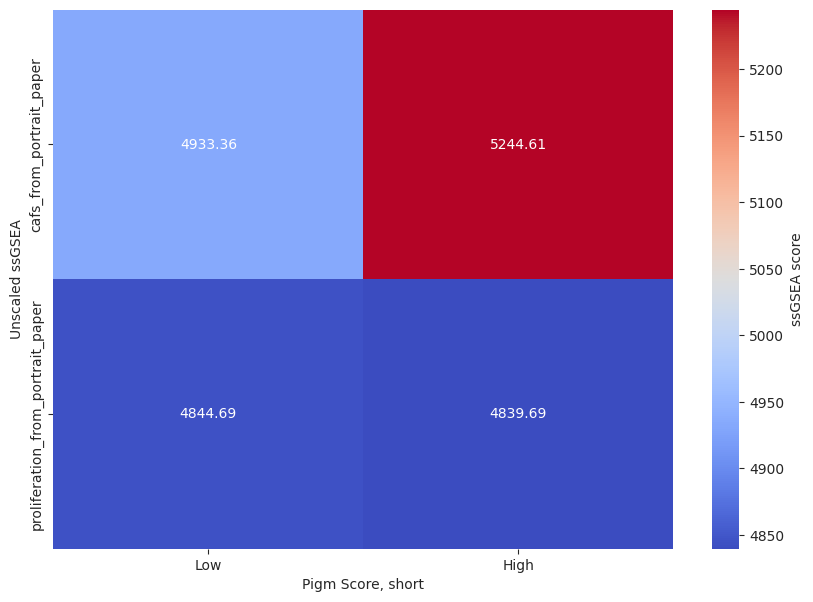

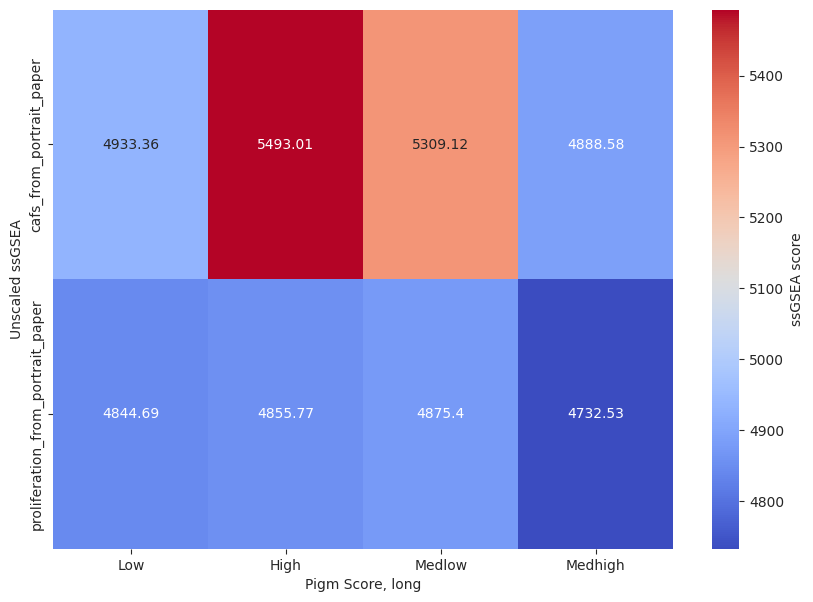

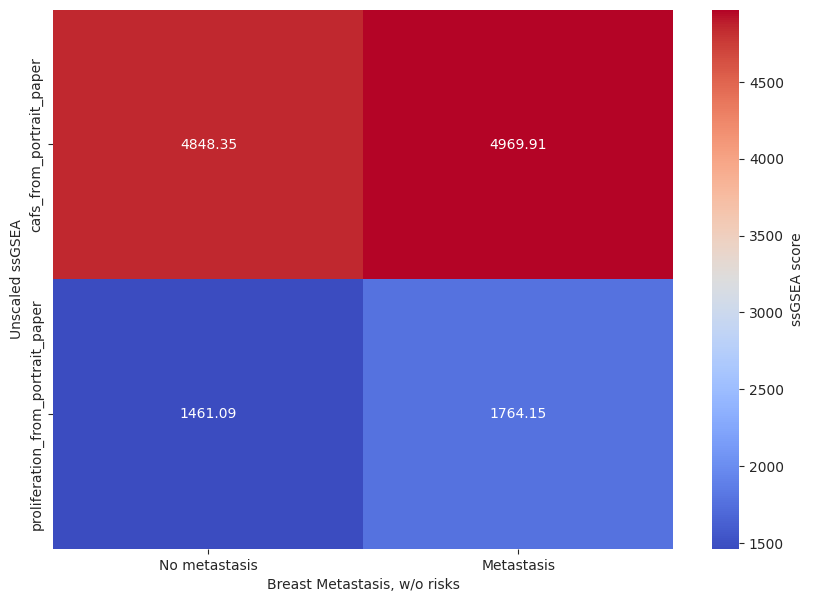

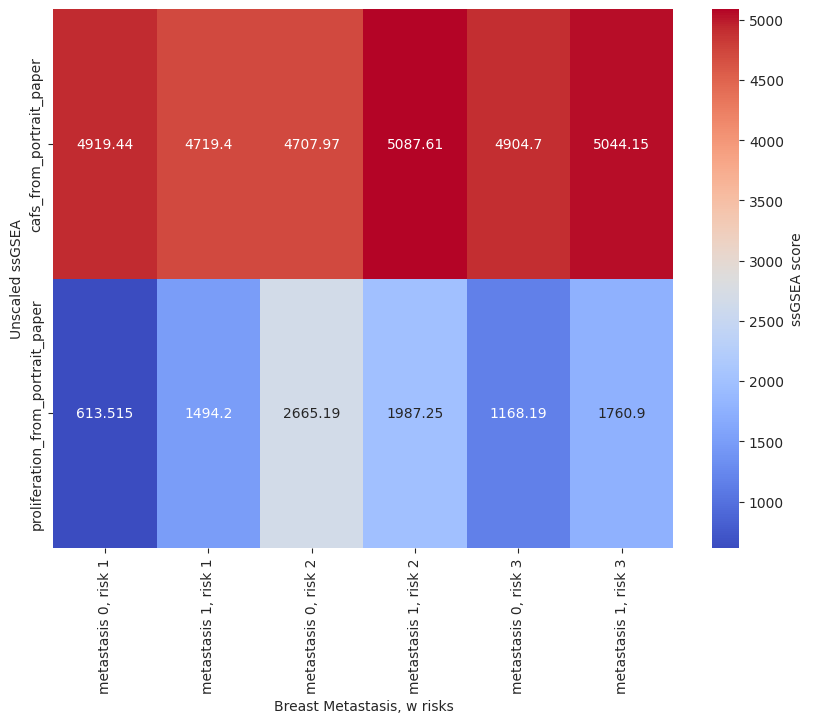

In [ ]:
for col in cols:
    x = pd.DataFrame(tables[col]).dropna().T
    #     x_sc = x.copy()
    #     x_sc = x_sc/x_sc.sum()
    #     x_sc = x_sc.T/x_sc.T.sum()
    #     x_sc = x_sc.T
    fig, ax = plt.subplots(figsize=(10, 7))
    sns.heatmap(
        x, annot=x, cmap="coolwarm", fmt="g", ax=ax, cbar_kws={"label": "ssGSEA score"}
    )
    ax.set_xlabel(col)
    ax.set_ylabel("Unscaled ssGSEA")

## Waterfall plot

In [ ]:
# c = 'Breast Metastasis, w risks'
c = "Pigm Score, short"
x = pd.DataFrame(tables[c]).dropna().T
x_std = pd.DataFrame(tables_stdev[c]).dropna().T
x

Low         High
BG EMT FGES                         2499.443902  2065.011567
BG SKCM-EMT FGES                    1457.611103   259.737117
Hallmark EMT FGES                   4351.985483  4328.256173
BG Metastasis FGES                  5864.574848  5588.914699
Metastasis FGES, Ramaswamy et al.   7625.862666  7614.432542
Metastasis FGES, Landemaine et al.  -162.100630  -711.457179
Metastasis FGES, Albini et al.      4446.942639  4481.688573

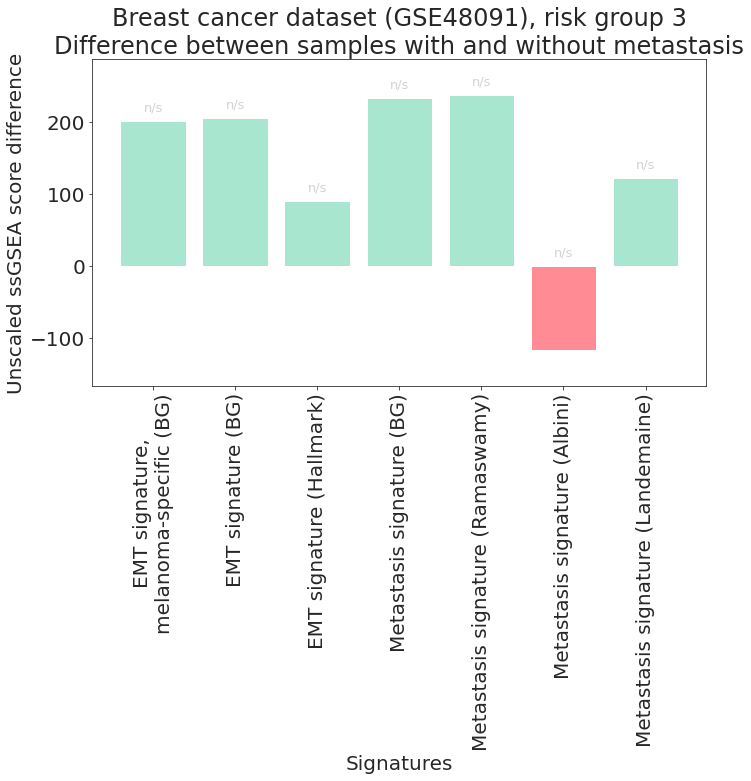

In [ ]:
out = {sign: {} for sign in emt_signs.keys()}
for sign in emt_signs.keys():
    out[sign]["Pigm Score, short"] = {
        "Low": df_pigm[sign]
        .reindex(
            pigm["Pigmentation_Score"][
                pigm["Pigmentation_Score"] == "Low_Pigment"
            ].index
        )
        .dropna()
        .mean(),
        "High": df_pigm[sign]
        .reindex(
            pigm["Pigmentation_Score"][
                pigm["Pigmentation_Score"] == "High_Pigment"
            ].index
        )
        .dropna()
        .mean(),
    }
    out[sign]["Pigm Score, long"] = {
        "Low": df_pigm[sign].reindex(pigm_long[pigm_long == 0].index).dropna().mean(),
        "Medlow": df_pigm[sign]
        .reindex(pigm_long[pigm_long == 1].index)
        .dropna()
        .mean(),
        "Medhigh": df_pigm[sign]
        .reindex(pigm_long[pigm_long == 2].index)
        .dropna()
        .mean(),
        "High": df_pigm[sign].reindex(pigm_long[pigm_long == 3].index).dropna().mean(),
    }
    out[sign]["Breast Metastasis, w/o risks"] = {
        "No metastasis": df_br[sign]
        .reindex(anno_br["metastasis_status"][anno_br["metastasis_status"] == 0].index)
        .dropna()
        .mean(),
        "Metastasis": df_br[sign]
        .reindex(anno_br["metastasis_status"][anno_br["metastasis_status"] == 1].index)
        .dropna()
        .mean(),
    }
    ser = anno_br["metastasis_status"].map(lambda x: f"metastasis {x}, ") + anno_br[
        "risk_sets"
    ].map(lambda x: f"risk {x}")
    out[sign]["Breast Metastasis, w risks"] = {
        x: df_br[sign].reindex(ser[ser == x].index).dropna().mean()
        for x in [
            "metastasis 0, risk 1",
            "metastasis 1, risk 1",
            "metastasis 0, risk 2",
            "metastasis 1, risk 2",
            "metastasis 0, risk 3",
            "metastasis 1, risk 3",
        ]
    }

pd.DataFrame(out[list(out.keys())[0]]).T.index
cols = [
    "Pigm Score, short",
    "Pigm Score, long",
    "Breast Metastasis, w/o risks",
    "Breast Metastasis, w risks",
]
tables = {col: {sign: None for sign in out.keys()} for col in cols}
for sign in out.keys():
    for col in cols:
        tables[col][sign] = pd.DataFrame(out[sign])[col]
out_stdev = {sign: {} for sign in emt_signs.keys()}
for sign in emt_signs.keys():
    out_stdev[sign]["Pigm Score, short"] = {
        "Low": df_pigm[sign]
        .reindex(
            pigm["Pigmentation_Score"][
                pigm["Pigmentation_Score"] == "Low_Pigment"
            ].index
        )
        .dropna()
        .std(),
        "High": df_pigm[sign]
        .reindex(
            pigm["Pigmentation_Score"][
                pigm["Pigmentation_Score"] == "High_Pigment"
            ].index
        )
        .dropna()
        .std(),
    }
    out_stdev[sign]["Pigm Score, long"] = {
        "Low": df_pigm[sign].reindex(pigm_long[pigm_long == 0].index).dropna().std(),
        "Medlow": df_pigm[sign].reindex(pigm_long[pigm_long == 1].index).dropna().std(),
        "Medhigh": df_pigm[sign]
        .reindex(pigm_long[pigm_long == 2].index)
        .dropna()
        .std(),
        "High": df_pigm[sign].reindex(pigm_long[pigm_long == 3].index).dropna().std(),
    }
    out_stdev[sign]["Breast Metastasis, w/o risks"] = {
        "No metastasis": df_br[sign]
        .reindex(anno_br["metastasis_status"][anno_br["metastasis_status"] == 0].index)
        .dropna()
        .std(),
        "Metastasis": df_br[sign]
        .reindex(anno_br["metastasis_status"][anno_br["metastasis_status"] == 1].index)
        .dropna()
        .std(),
    }
    ser = anno_br["metastasis_status"].map(lambda x: f"metastasis {x}, ") + anno_br[
        "risk_sets"
    ].map(lambda x: f"risk {x}")
    out_stdev[sign]["Breast Metastasis, w risks"] = {
        x: df_br[sign].reindex(ser[ser == x].index).dropna().std()
        for x in [
            "metastasis 0, risk 1",
            "metastasis 1, risk 1",
            "metastasis 0, risk 2",
            "metastasis 1, risk 2",
            "metastasis 0, risk 3",
            "metastasis 1, risk 3",
        ]
    }
pd.DataFrame(out_stdev[list(out.keys())[0]]).T.index
cols = [
    "Pigm Score, short",
    "Pigm Score, long",
    "Breast Metastasis, w/o risks",
    "Breast Metastasis, w risks",
]
tables_stdev = {col: {sign: None for sign in out_stdev.keys()} for col in cols}
for sign in out_stdev.keys():
    for col in cols:
        tables_stdev[col][sign] = pd.DataFrame(out_stdev[sign])[col]

out_mw = {sign: {} for sign in emt_signs.keys()}
for sign in emt_signs.keys():
    _, pv = mannwhitneyu(
        df_pigm[sign]
        .reindex(
            pigm["Pigmentation_Score"][
                pigm["Pigmentation_Score"] == "Low_Pigment"
            ].index
        )
        .dropna(),
        df_pigm[sign]
        .reindex(
            pigm["Pigmentation_Score"][
                pigm["Pigmentation_Score"] == "High_Pigment"
            ].index
        )
        .dropna(),
        alternative="two-sided",
    )
    out_mw[sign]["Pigm Score, short"] = pv
    _, pv = mannwhitneyu(
        df_br[sign]
        .reindex(anno_br["metastasis_status"][anno_br["metastasis_status"] == 1].index)
        .dropna(),
        df_br[sign]
        .reindex(anno_br["metastasis_status"][anno_br["metastasis_status"] == 0].index)
        .dropna(),
        alternative="two-sided",
    )
    out_mw[sign]["Breast Metastasis, w/o risks"] = pv

    riskgroup = 3
    ser = anno_br["metastasis_status"].map(lambda x: f"metastasis {x}, ") + anno_br[
        "risk_sets"
    ].map(lambda x: f"risk {x}")
    a = (
        df_br[sign]
        .reindex(ser[ser == f"metastasis 0, risk {riskgroup}"].index)
        .dropna()
    )
    b = (
        df_br[sign]
        .reindex(ser[ser == f"metastasis 1, risk {riskgroup}"].index)
        .dropna()
    )
    _, pv = mannwhitneyu(a, b, alternative="two-sided")
    out_mw[sign]["Breast Metastasis, w risks"] = pv
out_mw = pd.DataFrame(out_mw)
for i in out_mw.index:
    _, out_mw.loc[i], _, _ = multipletests(out_mw.loc[i], method="fdr_bh")
c = "Breast Metastasis, w risks"
# c = 'Pigm Score, short'
x = pd.DataFrame(tables[c]).dropna().T
x_std = pd.DataFrame(tables_stdev[c]).dropna().T


plt.rcParams["svg.fonttype"] = "none"
dif = x[f"metastasis 1, risk {riskgroup}"] - x[f"metastasis 0, risk {riskgroup}"]
# dif = x['Metastasis']-x['No metastasis']
# dif = x['Low']-x['High']
dif = dif.sort_values(ascending=False)
# dif = dif.reindex(['Main4_EMT_signature_SKCM_old',
#        'Main4_EMT_signature_old',  'HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION', 'Landemaine_BRCA_Lung_Met_UP','Main4_Metastasis_SOLID',
#        'Ramaswamy_Met_Up',
#        'Albini_Met_UP'])
dif = dif.reindex(
    [
        "BG SKCM-EMT FGES",
        "BG EMT FGES",
        "Hallmark EMT FGES",
        "BG Metastasis FGES",
        "Metastasis FGES, Ramaswamy et al.",
        "Metastasis FGES, Landemaine et al.",
        "Metastasis FGES, Albini et al.",
    ]
)

sns.set_style("ticks")
plt.rcParams.update({"font.size": 20})
# dif = pd.Series({sign:tn_ss_sc[sign][tn_labels_short=='cancer'].mean()-tn_ss_sc[sign][tn_labels_short=='normal'].mean() for sign in tn_ss_sc.columns})
p = []
for d in dif.index:
    if dif.loc[d] > 0:
        p.append("#a8e6cf")
    else:
        p.append("#ff8b94")
fig, ax = plt.subplots(figsize=(11, 6))
ax.bar(np.arange(0, len(dif.index)), dif, color=p)
plt.xticks([i for i in range(len(dif.index))])
ax.set_xticklabels(
    labels=[
        "EMT signature,\nmelanoma-specific (BG)",
        "EMT signature (BG)",
        "EMT signature (Hallmark)",
        "Metastasis signature (BG)",
        "Metastasis signature (Ramaswamy)",
        "Metastasis signature (Albini)",
        "Metastasis signature (Landemaine)",
    ],
    rotation=90,
)
ax.set_xlabel("Signatures")

ax.set_ylabel("Unscaled ssGSEA score difference")
ax.set_title(
    f"Breast cancer dataset (GSE48091), risk group {riskgroup}\nDifference between samples with and without metastasis"
)
# ax.set_ylabel('Unscaled ssGSEA score difference\nbetween Low and High')
# ax.set_title('TCGA pigmentation annotation\nDifference between low and high pigment score')
# ax.set_ylabel('Scaled ssGSEA score difference\nbetween Cancerous and Normal tissue')
# ax.set_title('Tumor-normal datasets, short\nDifference between Cancerous and Normal tissue')
for d in range(len(dif.index)):
    pv = out_mw.loc[c].loc[dif.index[d]]
    if pv <= 0.05:
        #         pv = 'p-value: {:0.1e}'.format(pv)
        if pv <= 0.001:
            pv = "***"
        elif pv <= 0.01:
            pv = "**"
        else:
            pv = "*"
    else:
        #         pv = 'p-value: {}'.format(round(pv,2))
        pv = "n/s"
    if dif.iloc[d] < 0:
        y = 10
    else:
        y = dif.iloc[d] + 10
    if pv != "n/s":
        ax.annotate(pv, (d, y), ha="center", va="center", size=17, c="dimgray")
    else:
        ax.annotate(pv, (d, y), ha="center", va="bottom", size=13, c="lightgray")
    plt.ylim(dif.min() - 50, dif.max() + 50)
    # plt.savefig(f"/home/nlukashevich/Chess_projects/Signature_validation_paper/Figures/Pigmentation_EMT_signatures_waterfall.svg", format="svg")

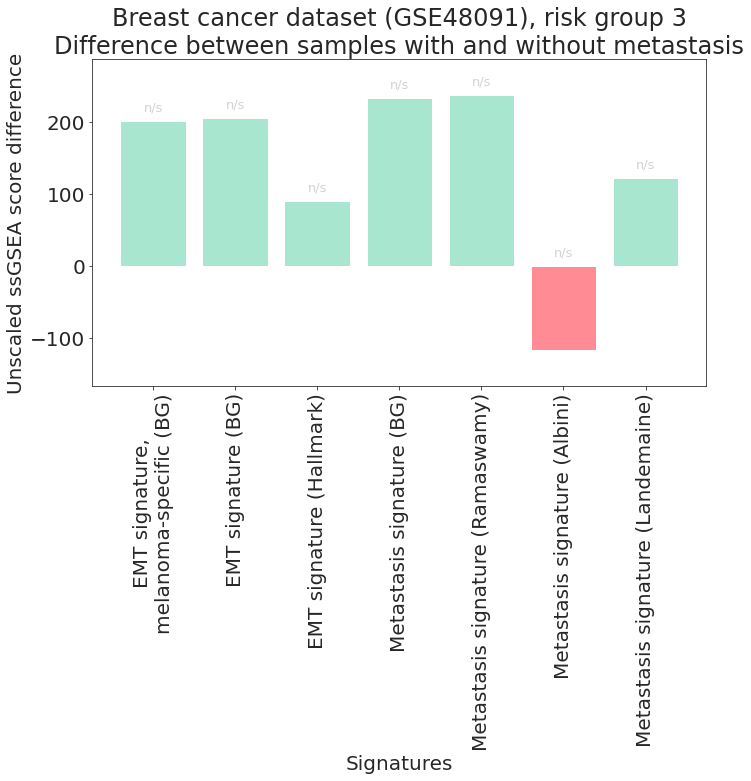

In [ ]:
plt.rcParams["svg.fonttype"] = "none"
dif = x[f"metastasis 1, risk {riskgroup}"] - x[f"metastasis 0, risk {riskgroup}"]
# dif = x['Metastasis']-x['No metastasis']
# dif = x['Low']-x['High']
dif = dif.sort_values(ascending=False)
# dif = dif.reindex(['Main4_EMT_signature_SKCM_old',
#        'Main4_EMT_signature_old',  'HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION', 'Landemaine_BRCA_Lung_Met_UP','Main4_Metastasis_SOLID',
#        'Ramaswamy_Met_Up',
#        'Albini_Met_UP'])
dif = dif.reindex(
    [
        "BG SKCM-EMT FGES",
        "BG EMT FGES",
        "Hallmark EMT FGES",
        "BG Metastasis FGES",
        "Metastasis FGES, Ramaswamy et al.",
        "Metastasis FGES, Landemaine et al.",
        "Metastasis FGES, Albini et al.",
    ]
)

sns.set_style("ticks")
plt.rcParams.update({"font.size": 20})
# dif = pd.Series({sign:tn_ss_sc[sign][tn_labels_short=='cancer'].mean()-tn_ss_sc[sign][tn_labels_short=='normal'].mean() for sign in tn_ss_sc.columns})
p = []
for d in dif.index:
    if dif.loc[d] > 0:
        p.append("#a8e6cf")
    else:
        p.append("#ff8b94")
fig, ax = plt.subplots(figsize=(11, 6))
ax.bar(np.arange(0, len(dif.index)), dif, color=p)
plt.xticks([i for i in range(len(dif.index))])
ax.set_xticklabels(
    labels=[
        "EMT signature,\nmelanoma-specific (BG)",
        "EMT signature (BG)",
        "EMT signature (Hallmark)",
        "Metastasis signature (BG)",
        "Metastasis signature (Ramaswamy)",
        "Metastasis signature (Albini)",
        "Metastasis signature (Landemaine)",
    ],
    rotation=90,
)
ax.set_xlabel("Signatures")

ax.set_ylabel("Unscaled ssGSEA score difference")
ax.set_title(
    f"Breast cancer dataset (GSE48091), risk group {riskgroup}\nDifference between samples with and without metastasis"
)
# ax.set_ylabel('Unscaled ssGSEA score difference\nbetween Low and High')
# ax.set_title('TCGA pigmentation annotation\nDifference between low and high pigment score')
# ax.set_ylabel('Scaled ssGSEA score difference\nbetween Cancerous and Normal tissue')
# ax.set_title('Tumor-normal datasets, short\nDifference between Cancerous and Normal tissue')
for d in range(len(dif.index)):
    pv = out_mw.loc[c].loc[dif.index[d]]
    if pv <= 0.05:
        #         pv = 'p-value: {:0.1e}'.format(pv)
        if pv <= 0.001:
            pv = "***"
        elif pv <= 0.01:
            pv = "**"
        else:
            pv = "*"
    else:
        #         pv = 'p-value: {}'.format(round(pv,2))
        pv = "n/s"
    if dif.iloc[d] < 0:
        y = 10
    else:
        y = dif.iloc[d] + 10
    if pv != "n/s":
        ax.annotate(pv, (d, y), ha="center", va="center", size=17, c="dimgray")
    else:
        ax.annotate(pv, (d, y), ha="center", va="bottom", size=13, c="lightgray")
    plt.ylim(dif.min() - 50, dif.max() + 50)
    # plt.savefig(f"/home/nlukashevich/Chess_projects/Signature_validation_paper/Figures/Pigmentation_EMT_signatures_waterfall.svg", format="svg")

## Patch heatmap

In [ ]:
h = "High_Pigment"
l = "Low_Pigment"
df = df_pigm_sc
labs = pigm["Pigmentation_Score"]

# h = 'cancer'
# l = 'normal'
# df = tn_ss_sc
# labs = tn_labels_short

# h = 'metastasis'
# l = 'no metastasis'
# met = anno_br['metastasis_status']
# met[met==0] = l
# met[met==1] = h
# df = df_br_sc
# labs = met

names = df.groupby(labs[labs.isin([h, l])]).median().T
for c in names.columns:
    names[c] = names[c].map(lambda x: f"{round(x, 2)}")
names

Pigmentation_Score                         High_Pigment Low_Pigment
Main4_EMT_signature                               -0.03        0.17
Main4_EMT_signature_SKCM                           0.25        0.11
EMT_mel_NL                                         0.03         0.2
Main4_EMT_signature_SKCM_old                      -0.16        0.29
HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION         0.28        0.12
Main4_Metastasis_SOLID                            -0.03        0.12
Ramaswamy_Met_Up                                  -0.13       -0.04
Landemaine_BRCA_Lung_Met_UP                       -0.22        0.29
Albini_Met_UP                                       0.2        0.03

In [ ]:
scs = df.groupby(labs[labs.isin([h, l])]).mean().T
scs = pd.DataFrame(
    index=scs.columns,
    columns=scs.index,
    data=np.array(pd.concat([scs[i] for i in scs.columns]).rank(pct=True)).reshape(
        names.shape[1], names.shape[0]
    ),
).T
sps = {sign: {h: None, l: None} for sign in df.columns}
for sign in df.columns:
    x = df[sign].reindex(labs[labs == h].index).dropna()
    y = df[sign].reindex(labs[labs == l].index).dropna()
    _, pv = mannwhitneyu(x, y)
    if x.mean() > y.mean() and pv <= 0.05:
        sps[sign][h] = pv
        sps[sign][l] = -pv
    elif x.mean() < y.mean() and pv <= 0.05:
        sps[sign][l] = pv
        sps[sign][h] = -pv
    else:
        sps[sign][l] = pv
        sps[sign][h] = pv
    print(sign, pv)
sps = pd.DataFrame(sps)
_, fdr, _, _ = multipletests(
    pd.concat([abs(sps.loc[i]) for i in sps.index]), method="fdr_bh"
)
sps = pd.DataFrame(
    index=sps.index,
    columns=sps.columns,
    data=np.array(
        fdr
        * pd.concat([sps.loc[i] for i in sps.index])
        / abs(pd.concat([sps.loc[i] for i in sps.index]))
    ).reshape(names.shape[1], names.shape[0]),
)
sps = sps.T

Main4_EMT_signature 0.15669271945694446
Main4_EMT_signature_SKCM 0.9107816080914007
EMT_mel_NL 0.0034406037789107744
Main4_EMT_signature_SKCM_old 9.143087031621014e-06
HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION 0.7664149919426162
Main4_Metastasis_SOLID 0.009737666983429163
Ramaswamy_Met_Up 0.5394241217039133
Landemaine_BRCA_Lung_Met_UP 2.9092286429943422e-05
Albini_Met_UP 0.5282910265043501


In [ ]:
for c in sps.columns:
    if len(sps[c][abs(sps[c]) > 0.05][sps[c] < 0].index) > 0:
        for i in sps[c][abs(sps[c]) > 0.05][sps[c] < 0].index:
            sps.at[i, c] = abs(sps.loc[i][c])

In [ ]:
for c in sps.columns:
    sps[c][sps[c] > 0.05] = 1
    sps[c][sps[c] < 0] = -1
    sps[c][~sps[c].isin([-1, 1])] = 0
sps

High_Pigment  Low_Pigment
Main4_EMT_signature                                  1.0          1.0
Main4_EMT_signature_SKCM                             1.0          1.0
EMT_mel_NL                                          -1.0          0.0
Main4_EMT_signature_SKCM_old                        -1.0          0.0
HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION           1.0          1.0
Main4_Metastasis_SOLID                              -1.0          0.0
Ramaswamy_Met_Up                                     1.0          1.0
Landemaine_BRCA_Lung_Met_UP                         -1.0          0.0
Albini_Met_UP                                        1.0          1.0

In [ ]:
# common={}
# common['breast'] = dict(sps=sps,scs=scs,names=names)
# common['tn'] = dict(sps=sps,scs=scs,names=names)
# common['mel'] = dict(sps=sps,scs=scs,names=names)
sps = pd.concat([common[i]["sps"] for i in common.keys()], axis=1)
scs = pd.concat([common[i]["scs"] for i in common.keys()], axis=1)
names = pd.concat([common[i]["names"] for i in common.keys()], axis=1)

In [ ]:
sps[sps == -1] = -20
sps[sps == 1] = 20

In [939]:
df

x              y  names  pvalues  \
0                          Main4_EMT_signature     metastasis   0.06     20.0   
1                     Main4_EMT_signature_SKCM     metastasis    0.2      0.0   
2                                   EMT_mel_NL     metastasis   0.13      0.0   
3                 Main4_EMT_signature_SKCM_old     metastasis   0.15      0.0   
4   HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION     metastasis   0.15      0.0   
5                       Main4_Metastasis_SOLID     metastasis   0.17      0.0   
6                             Ramaswamy_Met_Up     metastasis   0.11      0.0   
7                  Landemaine_BRCA_Lung_Met_UP     metastasis  -0.08    -20.0   
8                                Albini_Met_UP     metastasis   0.15      0.0   
9                          Main4_EMT_signature  no metastasis  -0.08     20.0   
10                    Main4_EMT_signature_SKCM  no metastasis   -0.1    -20.0   
11                                  EMT_mel_NL  no metastasis  -0.09    -20.0   
12                Main4_EMT_signature_SKCM_old  no metastasis   -0.1    -20.0   
13  HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION  no metastasis   -0.1    -20.0   
14                      Main4_Metastasis_SOLID  no metastasis  -0.09    -20.0   
15                            Ramaswamy_Met_Up  no metastasis  -0.06    -20.0   
16                 Landemaine_BRCA_Lung_Met_UP  no metastasis   0.05      0.0   
17                               Albini_Met_UP  no metastasis  -0.08    -20.0   
18                         Main4_EMT_signature         cancer   0.13     20.0   
19                    Main4_EMT_signature_SKCM         cancer   0.08     20.0   
20                                  EMT_mel_NL         cancer  -0.18    -20.0   
21                Main4_EMT_signature_SKCM_old         cancer   0.33      0.0   
22  HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION         cancer   0.35      0.0   
23                      Main4_Metastasis_SOLID         cancer  -0.07     20.0   
24                            Ramaswamy_Met_Up         cancer   0.49      0.0   
25                 Landemaine_BRCA_Lung_Met_UP         cancer  -0.28    -20.0   
26                               Albini_Met_UP         cancer   0.01     20.0   
27                         Main4_EMT_signature         normal  -0.03     20.0   
28                    Main4_EMT_signature_SKCM         normal    0.1     20.0   
29                                  EMT_mel_NL         normal   0.08      0.0   
30                Main4_EMT_signature_SKCM_old         normal  -0.04    -20.0   
31  HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION         normal  -0.17    -20.0   
32                      Main4_Metastasis_SOLID         normal   0.11     20.0   
33                            Ramaswamy_Met_Up         normal  -0.36    -20.0   
34                 Landemaine_BRCA_Lung_Met_UP         normal   0.09      0.0   
35                               Albini_Met_UP         normal   0.01     20.0   
36                         Main4_EMT_signature   High_Pigment  -0.03     20.0   
37                    Main4_EMT_signature_SKCM   High_Pigment   0.25     20.0   
38                                  EMT_mel_NL   High_Pigment   0.03    -20.0   
39                Main4_EMT_signature_SKCM_old   High_Pigment  -0.16    -20.0   
40  HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION   High_Pigment   0.28     20.0   
41                      Main4_Metastasis_SOLID   High_Pigment  -0.03    -20.0   
42                            Ramaswamy_Met_Up   High_Pigment  -0.13     20.0   
43                 Landemaine_BRCA_Lung_Met_UP   High_Pigment  -0.22    -20.0   
44                               Albini_Met_UP   High_Pigment    0.2     20.0   
45                         Main4_EMT_signature    Low_Pigment   0.17     20.0   
46                    Main4_EMT_signature_SKCM    Low_Pigment   0.11     20.0   
47                                  EMT_mel_NL    Low_Pigment    0.2      0.0   
48                Main4_EMT_signature_SKCM_old    Low_Pigment   0.29      0.

In [ ]:
import pandas as pd
from bokeh.palettes import RdBu
from bokeh.models import LinearColorMapper, ColumnDataSource, ColorBar
from bokeh.models.ranges import FactorRange
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, Label, LabelSet, Range1d

import numpy as np

output_notebook()

d = dict(
    x=list(sps.index) * len(sps.columns),
    y=[
        item
        for sublist in [
            [f"{c}_{sps.columns[c]}"] * len(sps.index) for c in range(len(sps.columns))
        ]
        for item in sublist
    ],
    names=list(pd.concat([names[c] for c in names.columns])),
    pvalues=list(pd.concat([sps[c] for c in sps.columns])),
    size=list(pd.concat([scs[c] for c in scs.columns])),
)

df = pd.DataFrame(d)

df["size"] = df["size"] * 20
# df['size'] = np.where(df['corr']<0, np.abs(df['corr']), df['corr'])*50
# added a new column to make the plot size

colors = ["crimson", "royalblue", "dimgray"]
exp_cmap = LinearColorMapper(palette=colors, low=-20, high=20)


p = figure(
    x_range=FactorRange(),
    y_range=FactorRange(),
    title="Scaled ssGSEA score",
    toolbar_location=None,
    tools="hover",
)

p.scatter(
    "x",
    "y",
    source=ColumnDataSource(df),
    fill_alpha=1,
    line_width=0,
    size="size",
    fill_color={"field": "pvalues", "transform": exp_cmap},
)

p.x_range.factors = sorted(df["x"].unique().tolist())
p.y_range.factors = sorted(df["y"].unique().tolist(), reverse=True)

p.grid.visible = False
p.xaxis.axis_line_alpha = 0
p.yaxis.axis_line_alpha = 0


p.xaxis.axis_label = "Signatures"
# p.yaxis.axis_label = 'Diagnoses'
p.yaxis.axis_label = "All values"
# p.yaxis.axis_label = 'Pigmentation annotation'


labels = LabelSet(
    x="x",
    y="y",
    text="names",
    source=ColumnDataSource(df),
    level="glyph",
    text_color="black",
    text_font_size="6pt",
    text_align="center",
    y_offset=-3,
    #                  text_outline_color ='black'
)
p.add_layout(labels)

# bar = ColorBar(color_mapper=exp_cmap, location=(0,0))
# p.add_layout(bar, "right")
p.xaxis.major_label_orientation = math.pi / 2

show(p)

# from bokeh.io import export_png

# export_png(p, filename="plot.png")

Loading BokehJS ...

<AxesSubplot:>

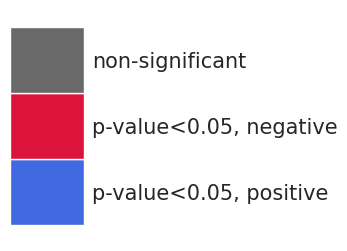

In [ ]:
fig, ax = plt.subplots(figsize=(1, 3))
patch_plot(
    {
        "p-value<0.05, negative": "crimson",
        "p-value<0.05, positive": "royalblue",
        "non-significant": "dimgray",
    },
    ax=ax,
)

# Making classifiers

In [ ]:
import optuna

RANDOM_SEED = 444
kfolds = KFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)
roc_auc_counts = {}


def tune(objective):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=1000)
    params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score} \nOptimized parameters: {params}")
    return params


def minmax01(series):
    from sklearn.preprocessing import MinMaxScaler

    scaler = MinMaxScaler(feature_range=(0, 1))
    array = scaler.fit_transform(pd.DataFrame(index=series.index, data=series))
    series = pd.Series(index=series.index, data=[i[0] for i in array])
    return series


def encode_labels(label):
    from sklearn.preprocessing import LabelEncoder

    label_encoder = LabelEncoder()
    array = label_encoder.fit_transform(label)
    series = pd.Series(index=label.index, data=array)
    return series

## LGBM

In [ ]:
mod = "lgm"


def lgb_objective(trial):
    try:
        param_grid = {
            "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
            "max_depth": trial.suggest_int("max_depth", 3, 12),
            "min_data_in_leaf": trial.suggest_int(
                "min_data_in_leaf", 200, 10000, step=100
            ),
            "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
            "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
            "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
            "bagging_fraction": trial.suggest_float(
                "bagging_fraction", 0.2, 0.95, step=0.1
            ),
            "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
            "feature_fraction": trial.suggest_float(
                "feature_fraction", 0.2, 0.95, step=0.1
            ),
        }
        model = lgbm.LGBMClassifier(
            objective="binary", random_state=RANDOM_SEED, **param_grid
        )
        score = cross_val_score(
            model, X_tune, y_tune, cv=kfolds, scoring="neg_root_mean_squared_error"
        ).mean()
        return score
    except:
        print("LGBM Classifier experienced some error")

## LR

In [ ]:
mod = "lr"


def lr_objective(trial):
    try:
        _solver = trial.suggest_categorical(
            "solver", ["newton-cg", "lbfgs", "liblinear"]
        )
        _penalty = trial.suggest_categorical(
            "penalty", ["l1", "l2", "elasticnet", "none"]
        )
        _C = trial.suggest_categorical("C", [100, 10, 1.0, 0.1, 0.01])
        model = LogisticRegression(
            penalty=_penalty, C=_C, solver=_solver, random_state=RANDOM_SEED
        )
        score = cross_val_score(
            model, X_tune, y_tune, cv=kfolds, scoring="neg_root_mean_squared_error"
        ).mean()
        return score
    except:
        print("Logistic regression experienced some error")

## training

In [ ]:
data = df_pigm_sc
dt = {}
coh = "SKCM"
to_add_name = "Stage, Gender, MFP, Melanogenesis genes"
label = pigm
to_add = True
expr = skcm_expr
by_sign = False
gmt = emt_gmt
# melanogenesis = median_scale(ssgsea_formula(skcm_expr.T, gmt_genes_alt_names({'Mel':GeneSet('Mel','', ['TFEB','MITF','GNAO1', 'DCT', 'KIT', 'TYRP1', 'FZD9', 'ADCY2', 'ADCY1', 'TYR', 'WNT4'])}, skcm_expr.columns)).T).clip(-3,3)
melanogenesis = expr[
    [
        "TFEB",
        "MITF",
        "GNAO1",
        "DCT",
        "KIT",
        "TYRP1",
        "FZD9",
        "ADCY2",
        "ADCY1",
        "TYR",
        "WNT4",
    ]
]
add = pd.concat(
    [
        skcm_anno["Stage"][skcm_anno["Stage"].isin(["I", "II", "III", "IV"])].dropna(),
        skcm_anno["Gender"].dropna(),
        skcm_anno["MFP"].dropna(),
        melanogenesis,
    ],
    axis=1,
)
pred = "pigment score"

In [ ]:
data = df_br_sc
dt = {}
coh = "GSE48091"
label = anno_br["metastasis_status"]
by_sign = False
expr = expr_br.T
to_add = True
add = pd.concat([anno_br["risk_sets"]], axis=1)
to_add_name = "Risk sets"
gmt = emt_gmt
pred = "metastasis"

In [ ]:
from sklearn import metrics

cv = KFold(n_splits=3)
for sign in list(data.columns) + ["raw"]:
    if sign != "raw":
        if by_sign:
            signature = data[sign]
        else:
            signature = expr[gmt_genes_alt_names(gmt, expr.columns)[sign].genes]
    label = label[~label.index.duplicated()]
    signature = signature[~signature.index.duplicated()]
    if to_add:
        if sign != "raw":
            add = add[~add.index.duplicated()]
            label, signature, add = to_common_samples(
                (label.dropna(), signature.dropna(), add.dropna())
            )
            signature = pd.concat([signature, add], axis=1)
        else:
            add = add[~add.index.duplicated()]
            label, add = to_common_samples((label.dropna(), add.dropna()))
            signature = add
    else:
        label, signature = to_common_samples((label.dropna(), signature.dropna()))
    signature = signature.rank(pct=True)
    label = encode_labels(label)

    X_tune, X_val, y_tune, y_val = train_test_split(signature, label, test_size=0.6)

    params = tune(lr_objective)
    #         params = tune(lgb_objective)

    name = f"{sign}"

    dt[name] = {
        "fprs": [],
        "tprs": [],
        "roc_aucs": [],
        "precisions": [],
        "recalls": [],
        "pr_aucs": [],
        "fscores": [],
        "accuracies": [],
        "average_precisions": [],
    }

    for i, (train, test) in enumerate(cv.split(X_val, y_val)):
        model = LogisticRegression(
            C=params["C"], solver=params["solver"], penalty=params["penalty"]
        )
        #                 model = lgbm.LGBMClassifier(objective="binary",random_state=RANDOM_SEED, **params)
        X_train, y_train, X_test, y_test = (
            X_val.iloc[train],
            y_val.iloc[train],
            X_val.iloc[test],
            y_val.iloc[test],
        )
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
        aucs = round(metrics.roc_auc_score(y_test, y_pred), 5)
        precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred)
        auc_precision_recall = metrics.auc(recall, precision)
        av_precision = round(metrics.average_precision_score(y_test, y_pred), 5)
        y_pred = pd.DataFrame(y_pred)
        y_pred = (y_pred > y_pred.quantile(0.75)).astype("int")[0]
        fscore = round(metrics.f1_score(y_test, y_pred), 5)
        accuracy = round(metrics.accuracy_score(y_test, y_pred), 5)
        dt[name]["fprs"].append(fpr)
        dt[name]["tprs"].append(tpr)
        dt[name]["roc_aucs"].append(aucs)
        dt[name]["precisions"].append(precision)
        dt[name]["recalls"].append(recall)
        dt[name]["pr_aucs"].append(auc_precision_recall)
        dt[name]["fscores"].append(fscore)
        dt[name]["average_precisions"].append(av_precision)
        dt[name]["accuracies"].append(accuracy)

[I 2022-12-05 22:15:53,471] A new study created in memory with name: no-name-1b3b54fe-0a06-4384-87a8-3d4050c6e570
[I 2022-12-05 22:15:53,493] Trial 0 finished with value: -0.5533205320189608 and parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.01}. Best is trial 0 with value: -0.5533205320189608.
[W 2022-12-05 22:15:53,499] Trial 1 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:53,503] Trial 2 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:53,508] Trial 3 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:53,513] Trial 4 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:53,518] Trial 5 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:53,528] Trial 6 failed, because the value None could not be cast to float.
[I 2022-12-05 22:15:53,548] Trial 7 finished with value: -0.6000964627917273 and parameters: {'solver': 'liblinear', 'penalty

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error


[I 2022-12-05 22:15:53,716] Trial 16 finished with value: -0.6064663625277643 and parameters: {'solver': 'newton-cg', 'penalty': 'none', 'C': 100}. Best is trial 0 with value: -0.5533205320189608.
[I 2022-12-05 22:15:53,733] Trial 17 finished with value: -0.6000964627917273 and parameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 10}. Best is trial 0 with value: -0.5533205320189608.
[I 2022-12-05 22:15:53,756] Trial 18 finished with value: -0.5533205320189608 and parameters: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 0.01}. Best is trial 0 with value: -0.5533205320189608.
[W 2022-12-05 22:15:53,763] Trial 19 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:53,770] Trial 20 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:53,776] Trial 21 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:53,783] Trial 22 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:53,789] T

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:15:53,967] Trial 51 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:53,974] Trial 52 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:53,980] Trial 53 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:53,986] Trial 54 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:53,993] Trial 55 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:53,999] Trial 56 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:54,006] Trial 57 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:54,012] Trial 58 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:54,019] Trial 59 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:54,025] Trial 60 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:54,031] Trial 61 fai

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:15:54,172] Trial 83 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:54,179] Trial 84 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:54,185] Trial 85 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:54,191] Trial 86 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:54,197] Trial 87 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:54,204] Trial 88 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:54,210] Trial 89 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:54,216] Trial 90 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:54,222] Trial 91 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:54,229] Trial 92 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:54,236] Trial 93 fai

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:15:54,377] Trial 114 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:54,384] Trial 115 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:54,390] Trial 116 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:54,397] Trial 117 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:54,403] Trial 118 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:54,410] Trial 119 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:54,416] Trial 120 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:54,423] Trial 121 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:54,429] Trial 122 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:54,436] Trial 123 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:54,442] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:15:54,584] Trial 146 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:54,591] Trial 147 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:54,597] Trial 148 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:54,604] Trial 149 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:54,610] Trial 150 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:54,616] Trial 151 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:54,623] Trial 152 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:54,629] Trial 153 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:54,636] Trial 154 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:54,642] Trial 155 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:54,648] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:15:54,789] Trial 178 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:54,795] Trial 179 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:54,802] Trial 180 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:54,808] Trial 181 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:54,814] Trial 182 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:54,820] Trial 183 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:54,827] Trial 184 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:54,833] Trial 185 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:54,840] Trial 186 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:54,846] Trial 187 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:54,853] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:15:54,994] Trial 210 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:55,000] Trial 211 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:55,007] Trial 212 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:55,013] Trial 213 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:55,019] Trial 214 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:55,025] Trial 215 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:55,032] Trial 216 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:55,039] Trial 217 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:55,045] Trial 218 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:55,051] Trial 219 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:55,057] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:15:55,199] Trial 242 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:55,206] Trial 243 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:55,212] Trial 244 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:55,219] Trial 245 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:55,225] Trial 246 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:55,231] Trial 247 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:55,238] Trial 248 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:55,244] Trial 249 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:55,251] Trial 250 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:55,257] Trial 251 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:55,263] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:15:55,406] Trial 274 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:55,413] Trial 275 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:55,420] Trial 276 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:55,426] Trial 277 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:55,433] Trial 278 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:55,439] Trial 279 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:55,446] Trial 280 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:55,452] Trial 281 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:55,459] Trial 282 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:55,465] Trial 283 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:55,472] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:15:55,611] Trial 305 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:55,618] Trial 306 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:55,624] Trial 307 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:55,631] Trial 308 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:55,638] Trial 309 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:55,644] Trial 310 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:55,651] Trial 311 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:55,658] Trial 312 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:55,665] Trial 313 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:55,672] Trial 314 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:55,678] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[I 2022-12-05 22:15:55,840] Trial 336 finished with value: -0.6064663625277643 and parameters: {'solver': 'lbfgs', 'penalty': 'none', 'C': 1.0}. Best is trial 0 with value: -0.5533205320189608.
[W 2022-12-05 22:15:55,847] Trial 337 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:55,854] Trial 338 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:55,861] Trial 339 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:55,868] Trial 340 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:55,874] Trial 341 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:55,881] Trial 342 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:55,888] Trial 343 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:55,895] Trial 344 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:55,901] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:15:56,049] Trial 367 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:56,057] Trial 368 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:56,063] Trial 369 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:56,070] Trial 370 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:56,076] Trial 371 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:56,083] Trial 372 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:56,090] Trial 373 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:56,096] Trial 374 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:56,103] Trial 375 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:56,109] Trial 376 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:56,116] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:15:56,254] Trial 398 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:56,261] Trial 399 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:56,268] Trial 400 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:56,274] Trial 401 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:56,281] Trial 402 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:56,288] Trial 403 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:56,294] Trial 404 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:56,301] Trial 405 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:56,307] Trial 406 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:56,314] Trial 407 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:56,320] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:15:56,461] Trial 429 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:56,468] Trial 430 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:56,474] Trial 431 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:56,481] Trial 432 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:56,487] Trial 433 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:56,494] Trial 434 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:56,500] Trial 435 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:56,507] Trial 436 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:56,514] Trial 437 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:56,520] Trial 438 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:56,527] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:15:56,668] Trial 460 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:56,675] Trial 461 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:56,681] Trial 462 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:56,688] Trial 463 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:56,695] Trial 464 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:56,703] Trial 465 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:56,709] Trial 466 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:56,716] Trial 467 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:56,724] Trial 468 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:56,730] Trial 469 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:56,737] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:15:56,872] Trial 490 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:56,880] Trial 491 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:56,886] Trial 492 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:56,893] Trial 493 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:56,900] Trial 494 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:56,906] Trial 495 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:56,913] Trial 496 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:56,920] Trial 497 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:56,927] Trial 498 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:56,934] Trial 499 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:56,941] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:15:57,078] Trial 520 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:57,085] Trial 521 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:57,092] Trial 522 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:57,099] Trial 523 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:57,106] Trial 524 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:57,112] Trial 525 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:57,119] Trial 526 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:57,126] Trial 527 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:57,133] Trial 528 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:57,140] Trial 529 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:57,146] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:15:57,284] Trial 550 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:57,292] Trial 551 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:57,298] Trial 552 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:57,305] Trial 553 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:57,312] Trial 554 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:57,319] Trial 555 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:57,326] Trial 556 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:57,333] Trial 557 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:57,339] Trial 558 failed, because the value None could not be cast to float.
[I 2022-12-05 22:15:57,356] Trial 559 finished with value: -0.5533205320189608 and parameters: {'solver': 'liblinear', 'penalty

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:15:57,489] Trial 578 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:57,496] Trial 579 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:57,503] Trial 580 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:57,509] Trial 581 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:57,516] Trial 582 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:57,523] Trial 583 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:57,530] Trial 584 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:57,537] Trial 585 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:57,544] Trial 586 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:57,550] Trial 587 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:57,557] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:15:57,691] Trial 606 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:57,698] Trial 607 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:57,705] Trial 608 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:57,712] Trial 609 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:57,719] Trial 610 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:57,726] Trial 611 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:57,733] Trial 612 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:57,740] Trial 613 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:57,747] Trial 614 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:57,753] Trial 615 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:57,760] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:15:57,899] Trial 636 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:57,905] Trial 637 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:57,913] Trial 638 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:57,920] Trial 639 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:57,927] Trial 640 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:57,934] Trial 641 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:57,940] Trial 642 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:57,947] Trial 643 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:57,954] Trial 644 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:57,961] Trial 645 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:57,967] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:15:58,104] Trial 666 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:58,111] Trial 667 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:58,117] Trial 668 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:58,124] Trial 669 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:58,130] Trial 670 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:58,137] Trial 671 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:58,143] Trial 672 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:58,150] Trial 673 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:58,157] Trial 674 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:58,164] Trial 675 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:58,171] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:15:58,307] Trial 696 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:58,314] Trial 697 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:58,320] Trial 698 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:58,327] Trial 699 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:58,334] Trial 700 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:58,341] Trial 701 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:58,348] Trial 702 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:58,354] Trial 703 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:58,361] Trial 704 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:58,368] Trial 705 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:58,374] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:15:58,512] Trial 726 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:58,519] Trial 727 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:58,526] Trial 728 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:58,533] Trial 729 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:58,540] Trial 730 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:58,547] Trial 731 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:58,553] Trial 732 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:58,560] Trial 733 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:58,567] Trial 734 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:58,574] Trial 735 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:58,581] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:15:58,717] Trial 754 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:58,724] Trial 755 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:58,731] Trial 756 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:58,738] Trial 757 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:58,744] Trial 758 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:58,751] Trial 759 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:58,758] Trial 760 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:58,765] Trial 761 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:58,771] Trial 762 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:58,778] Trial 763 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:58,785] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:15:58,919] Trial 784 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:58,926] Trial 785 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:58,933] Trial 786 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:58,940] Trial 787 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:58,946] Trial 788 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:58,953] Trial 789 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:58,959] Trial 790 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:58,966] Trial 791 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:58,973] Trial 792 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:58,980] Trial 793 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:58,987] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:15:59,126] Trial 816 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:59,132] Trial 817 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:59,138] Trial 818 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:59,144] Trial 819 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:59,151] Trial 820 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:59,157] Trial 821 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:59,164] Trial 822 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:59,170] Trial 823 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:59,176] Trial 824 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:59,182] Trial 825 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:59,189] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:15:59,333] Trial 849 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:59,339] Trial 850 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:59,345] Trial 851 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:59,351] Trial 852 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:59,357] Trial 853 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:59,363] Trial 854 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:59,369] Trial 855 failed, because the value None could not be cast to float.
[I 2022-12-05 22:15:59,389] Trial 856 finished with value: -0.5533205320189608 and parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.01}. Best is trial 0 with value: -0.5533205320189608.
[W 2022-12-05 22:15:59,395] Trial 857 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:59,401] Tri

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:15:59,540] Trial 880 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:59,546] Trial 881 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:59,552] Trial 882 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:59,558] Trial 883 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:59,564] Trial 884 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:59,571] Trial 885 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:59,577] Trial 886 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:59,583] Trial 887 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:59,590] Trial 888 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:59,597] Trial 889 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:59,604] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:15:59,742] Trial 910 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:59,749] Trial 911 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:59,756] Trial 912 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:59,763] Trial 913 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:59,771] Trial 914 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:59,778] Trial 915 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:59,785] Trial 916 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:59,791] Trial 917 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:59,798] Trial 918 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:59,805] Trial 919 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:59,812] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error


[I 2022-12-05 22:15:59,952] Trial 935 finished with value: -0.5533205320189608 and parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.01}. Best is trial 0 with value: -0.5533205320189608.
[W 2022-12-05 22:15:59,959] Trial 936 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:59,966] Trial 937 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:59,973] Trial 938 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:59,981] Trial 939 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:59,988] Trial 940 failed, because the value None could not be cast to float.
[W 2022-12-05 22:15:59,995] Trial 941 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:00,002] Trial 942 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:00,009] Trial 943 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:00,016] Tri

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:00,161] Trial 963 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:00,169] Trial 964 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:00,177] Trial 965 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:00,184] Trial 966 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:00,192] Trial 967 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:00,199] Trial 968 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:00,207] Trial 969 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:00,215] Trial 970 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:00,223] Trial 971 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:00,230] Trial 972 failed, because the value None could not be cast to float.
[I 2022-12-05 22:16:00,254] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:00,369] Trial 988 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:00,376] Trial 989 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:00,383] Trial 990 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:00,390] Trial 991 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:00,397] Trial 992 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:00,404] Trial 993 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:00,411] Trial 994 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:00,418] Trial 995 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:00,425] Trial 996 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:00,432] Trial 997 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:00,440] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Best score: -0.5533205320189608 
Optimized parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.01}


[I 2022-12-05 22:16:02,362] A new study created in memory with name: no-name-df2a8d4e-1dae-4d07-a447-1f9d186a3413
[I 2022-12-05 22:16:02,384] Trial 0 finished with value: -0.559217595954653 and parameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 1.0}. Best is trial 0 with value: -0.559217595954653.
[W 2022-12-05 22:16:02,391] Trial 1 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:02,398] Trial 2 failed, because the value None could not be cast to float.
[I 2022-12-05 22:16:02,430] Trial 3 finished with value: -0.5663944377958459 and parameters: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 10}. Best is trial 0 with value: -0.559217595954653.
[W 2022-12-05 22:16:02,437] Trial 4 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:02,447] Trial 5 failed, because the value None could not be cast to float.
[I 2022-12-05 22:16:02,476] Trial 6 finished with value: -0.559217595954653 and parameters: {'solver': 'newton-cg', 'penal

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error


[W 2022-12-05 22:16:02,594] Trial 14 failed, because the value None could not be cast to float.
[I 2022-12-05 22:16:02,614] Trial 15 finished with value: -0.559217595954653 and parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.1}. Best is trial 0 with value: -0.559217595954653.
[I 2022-12-05 22:16:02,636] Trial 16 finished with value: -0.5590665439172652 and parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 1.0}. Best is trial 16 with value: -0.5590665439172652.
[W 2022-12-05 22:16:02,641] Trial 17 failed, because the value None could not be cast to float.
[I 2022-12-05 22:16:02,665] Trial 18 finished with value: -0.5735792664925367 and parameters: {'solver': 'lbfgs', 'penalty': 'none', 'C': 100}. Best is trial 16 with value: -0.5590665439172652.
[W 2022-12-05 22:16:02,671] Trial 19 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:02,678] Trial 20 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:02,684] Trial 21 fail

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:02,850] Trial 46 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:02,857] Trial 47 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:02,863] Trial 48 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:02,870] Trial 49 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:02,877] Trial 50 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:02,884] Trial 51 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:02,896] Trial 52 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:02,902] Trial 53 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:02,909] Trial 54 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:02,915] Trial 55 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:02,922] Trial 56 fai

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:03,054] Trial 76 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:03,061] Trial 77 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:03,067] Trial 78 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:03,074] Trial 79 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:03,080] Trial 80 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:03,086] Trial 81 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:03,092] Trial 82 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:03,099] Trial 83 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:03,105] Trial 84 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:03,111] Trial 85 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:03,118] Trial 86 fai

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:03,259] Trial 108 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:03,266] Trial 109 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:03,272] Trial 110 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:03,278] Trial 111 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:03,284] Trial 112 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:03,290] Trial 113 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:03,296] Trial 114 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:03,303] Trial 115 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:03,309] Trial 116 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:03,316] Trial 117 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:03,322] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:03,466] Trial 141 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:03,473] Trial 142 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:03,479] Trial 143 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:03,485] Trial 144 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:03,492] Trial 145 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:03,498] Trial 146 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:03,504] Trial 147 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:03,510] Trial 148 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:03,517] Trial 149 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:03,523] Trial 150 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:03,529] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:03,670] Trial 173 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:03,677] Trial 174 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:03,683] Trial 175 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:03,690] Trial 176 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:03,696] Trial 177 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:03,703] Trial 178 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:03,709] Trial 179 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:03,715] Trial 180 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:03,722] Trial 181 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:03,728] Trial 182 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:03,734] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:03,875] Trial 203 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:03,882] Trial 204 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:03,888] Trial 205 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:03,894] Trial 206 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:03,901] Trial 207 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:03,907] Trial 208 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:03,914] Trial 209 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:03,920] Trial 210 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:03,927] Trial 211 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:03,933] Trial 212 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:03,940] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:04,078] Trial 231 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:04,085] Trial 232 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:04,093] Trial 233 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:04,100] Trial 234 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:04,107] Trial 235 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:04,114] Trial 236 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:04,121] Trial 237 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:04,129] Trial 238 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:04,136] Trial 239 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:04,143] Trial 240 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:04,151] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:04,281] Trial 260 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:04,289] Trial 261 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:04,295] Trial 262 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:04,301] Trial 263 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:04,307] Trial 264 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:04,313] Trial 265 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:04,320] Trial 266 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:04,326] Trial 267 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:04,333] Trial 268 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:04,339] Trial 269 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:04,346] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:04,483] Trial 291 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:04,490] Trial 292 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:04,497] Trial 293 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:04,503] Trial 294 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:04,509] Trial 295 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:04,516] Trial 296 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:04,522] Trial 297 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:04,529] Trial 298 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:04,536] Trial 299 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:04,542] Trial 300 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:04,549] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:04,688] Trial 322 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:04,695] Trial 323 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:04,702] Trial 324 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:04,708] Trial 325 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:04,714] Trial 326 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:04,721] Trial 327 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:04,727] Trial 328 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:04,733] Trial 329 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:04,740] Trial 330 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:04,746] Trial 331 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:04,753] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:04,892] Trial 353 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:04,899] Trial 354 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:04,906] Trial 355 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:04,913] Trial 356 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:04,919] Trial 357 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:04,926] Trial 358 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:04,932] Trial 359 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:04,938] Trial 360 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:04,945] Trial 361 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:04,951] Trial 362 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:04,958] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:05,103] Trial 385 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:05,110] Trial 386 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:05,116] Trial 387 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:05,123] Trial 388 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:05,129] Trial 389 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:05,136] Trial 390 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:05,143] Trial 391 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:05,149] Trial 392 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:05,156] Trial 393 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:05,163] Trial 394 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:05,169] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:05,309] Trial 416 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:05,316] Trial 417 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:05,322] Trial 418 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:05,329] Trial 419 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:05,336] Trial 420 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:05,342] Trial 421 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:05,349] Trial 422 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:05,356] Trial 423 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:05,363] Trial 424 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:05,370] Trial 425 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:05,377] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:05,514] Trial 446 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:05,521] Trial 447 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:05,527] Trial 448 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:05,534] Trial 449 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:05,541] Trial 450 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:05,548] Trial 451 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:05,555] Trial 452 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:05,562] Trial 453 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:05,569] Trial 454 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:05,576] Trial 455 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:05,583] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:05,719] Trial 475 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:05,727] Trial 476 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:05,734] Trial 477 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:05,742] Trial 478 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:05,749] Trial 479 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:05,757] Trial 480 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:05,765] Trial 481 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:05,773] Trial 482 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:05,781] Trial 483 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:05,789] Trial 484 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:05,797] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:05,923] Trial 501 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:05,932] Trial 502 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:05,940] Trial 503 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:05,948] Trial 504 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:05,956] Trial 505 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:05,963] Trial 506 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:05,971] Trial 507 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:05,978] Trial 508 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:05,986] Trial 509 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:05,993] Trial 510 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:06,001] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:06,131] Trial 528 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:06,139] Trial 529 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:06,146] Trial 530 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:06,153] Trial 531 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:06,161] Trial 532 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:06,168] Trial 533 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:06,176] Trial 534 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:06,183] Trial 535 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:06,190] Trial 536 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:06,198] Trial 537 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:06,205] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:06,335] Trial 555 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:06,343] Trial 556 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:06,350] Trial 557 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:06,358] Trial 558 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:06,365] Trial 559 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:06,373] Trial 560 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:06,380] Trial 561 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:06,387] Trial 562 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:06,395] Trial 563 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:06,403] Trial 564 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:06,410] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:06,537] Trial 582 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:06,545] Trial 583 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:06,553] Trial 584 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:06,560] Trial 585 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:06,568] Trial 586 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:06,575] Trial 587 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:06,583] Trial 588 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:06,590] Trial 589 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:06,598] Trial 590 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:06,605] Trial 591 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:06,612] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:06,741] Trial 608 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:06,749] Trial 609 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:06,757] Trial 610 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:06,764] Trial 611 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:06,771] Trial 612 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:06,779] Trial 613 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:06,787] Trial 614 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:06,795] Trial 615 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:06,802] Trial 616 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:06,809] Trial 617 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:06,817] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:06,945] Trial 635 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:06,952] Trial 636 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:06,960] Trial 637 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:06,967] Trial 638 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:06,975] Trial 639 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:06,982] Trial 640 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:06,989] Trial 641 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:06,997] Trial 642 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:07,004] Trial 643 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:07,011] Trial 644 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:07,019] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:07,152] Trial 662 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:07,160] Trial 663 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:07,166] Trial 664 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:07,173] Trial 665 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:07,180] Trial 666 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:07,186] Trial 667 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:07,193] Trial 668 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:07,200] Trial 669 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:07,207] Trial 670 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:07,214] Trial 671 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:07,221] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:07,354] Trial 691 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:07,361] Trial 692 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:07,369] Trial 693 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:07,376] Trial 694 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:07,383] Trial 695 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:07,389] Trial 696 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:07,397] Trial 697 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:07,404] Trial 698 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:07,411] Trial 699 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:07,418] Trial 700 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:07,425] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:07,559] Trial 720 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:07,566] Trial 721 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:07,573] Trial 722 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:07,580] Trial 723 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:07,587] Trial 724 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:07,594] Trial 725 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:07,601] Trial 726 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:07,608] Trial 727 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:07,615] Trial 728 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:07,622] Trial 729 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:07,629] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:07,763] Trial 749 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:07,770] Trial 750 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:07,777] Trial 751 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:07,785] Trial 752 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:07,792] Trial 753 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:07,800] Trial 754 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:07,807] Trial 755 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:07,813] Trial 756 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:07,820] Trial 757 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:07,827] Trial 758 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:07,834] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:07,966] Trial 778 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:07,973] Trial 779 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:07,980] Trial 780 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:07,987] Trial 781 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:07,994] Trial 782 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:08,002] Trial 783 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:08,008] Trial 784 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:08,015] Trial 785 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:08,022] Trial 786 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:08,029] Trial 787 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:08,037] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:08,169] Trial 805 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:08,176] Trial 806 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:08,183] Trial 807 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:08,190] Trial 808 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:08,197] Trial 809 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:08,204] Trial 810 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:08,212] Trial 811 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:08,219] Trial 812 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:08,226] Trial 813 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:08,233] Trial 814 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:08,240] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:08,376] Trial 834 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:08,383] Trial 835 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:08,389] Trial 836 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:08,396] Trial 837 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:08,403] Trial 838 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:08,410] Trial 839 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:08,417] Trial 840 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:08,424] Trial 841 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:08,432] Trial 842 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:08,439] Trial 843 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:08,446] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:08,580] Trial 862 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:08,587] Trial 863 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:08,594] Trial 864 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:08,601] Trial 865 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:08,608] Trial 866 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:08,615] Trial 867 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:08,621] Trial 868 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:08,628] Trial 869 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:08,635] Trial 870 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:08,642] Trial 871 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:08,649] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:08,784] Trial 891 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:08,796] Trial 892 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:08,803] Trial 893 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:08,810] Trial 894 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:08,817] Trial 895 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:08,825] Trial 896 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:08,832] Trial 897 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:08,839] Trial 898 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:08,846] Trial 899 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:08,854] Trial 900 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:08,861] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:08,992] Trial 917 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:08,999] Trial 918 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:09,006] Trial 919 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:09,013] Trial 920 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:09,021] Trial 921 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:09,028] Trial 922 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:09,035] Trial 923 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:09,042] Trial 924 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:09,049] Trial 925 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:09,057] Trial 926 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:09,064] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:09,200] Trial 945 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:09,207] Trial 946 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:09,214] Trial 947 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:09,221] Trial 948 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:09,228] Trial 949 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:09,235] Trial 950 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:09,242] Trial 951 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:09,249] Trial 952 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:09,256] Trial 953 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:09,263] Trial 954 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:09,271] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:09,405] Trial 974 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:09,413] Trial 975 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:09,420] Trial 976 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:09,427] Trial 977 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:09,434] Trial 978 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:09,441] Trial 979 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:09,448] Trial 980 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:09,455] Trial 981 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:09,462] Trial 982 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:09,469] Trial 983 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:09,477] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[I 2022-12-05 22:16:11,461] A new study created in memory with name: no-name-bbc34335-d7af-45be-9099-5fe656de4f7e
[W 2022-12-05 22:16:11,469] Trial 0 failed, because the value None could not be cast to float.
[I 2022-12-05 22:16:11,522] Trial 1 finished with value: -0.5507974827318858 and parameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.1}. Best is trial 1 with value: -0.5507974827318858.


Logistic regression experienced some error


[I 2022-12-05 22:16:11,722] Trial 2 finished with value: -0.602110895161737 and parameters: {'solver': 'newton-cg', 'penalty': 'none', 'C': 10}. Best is trial 1 with value: -0.5507974827318858.
[I 2022-12-05 22:16:11,783] Trial 3 finished with value: -0.4959533941127922 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.1}. Best is trial 3 with value: -0.4959533941127922.
[I 2022-12-05 22:16:12,042] Trial 4 finished with value: -0.5648971413303929 and parameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 100}. Best is trial 3 with value: -0.4959533941127922.
[I 2022-12-05 22:16:12,700] Trial 5 finished with value: -0.602110895161737 and parameters: {'solver': 'newton-cg', 'penalty': 'none', 'C': 100}. Best is trial 3 with value: -0.4959533941127922.
[W 2022-12-05 22:16:12,711] Trial 6 failed, because the value None could not be cast to float.


Logistic regression experienced some error


[I 2022-12-05 22:16:12,956] Trial 7 finished with value: -0.5756196884879029 and parameters: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 100}. Best is trial 3 with value: -0.4959533941127922.
[W 2022-12-05 22:16:12,966] Trial 8 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:12,976] Trial 9 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:12,985] Trial 10 failed, because the value None could not be cast to float.


Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error


[I 2022-12-05 22:16:13,183] Trial 11 finished with value: -0.602110895161737 and parameters: {'solver': 'newton-cg', 'penalty': 'none', 'C': 100}. Best is trial 3 with value: -0.4959533941127922.
[I 2022-12-05 22:16:13,279] Trial 12 finished with value: -0.5507974827318858 and parameters: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 0.01}. Best is trial 3 with value: -0.4959533941127922.
[W 2022-12-05 22:16:13,289] Trial 13 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:13,299] Trial 14 failed, because the value None could not be cast to float.


Logistic regression experienced some error
Logistic regression experienced some error


[I 2022-12-05 22:16:13,493] Trial 15 finished with value: -0.5682471067067169 and parameters: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 10}. Best is trial 3 with value: -0.4959533941127922.
[I 2022-12-05 22:16:13,617] Trial 16 finished with value: -0.5004575934116223 and parameters: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 0.1}. Best is trial 3 with value: -0.4959533941127922.
[W 2022-12-05 22:16:13,629] Trial 17 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:13,641] Trial 18 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:13,652] Trial 19 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:13,664] Trial 20 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:13,676] Trial 21 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:13,688] Trial 22 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:13,700] Trial 2

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:13,834] Trial 43 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:13,840] Trial 44 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:13,846] Trial 45 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:13,852] Trial 46 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:13,858] Trial 47 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:13,865] Trial 48 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:13,871] Trial 49 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:13,877] Trial 50 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:13,884] Trial 51 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:13,891] Trial 52 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:13,897] Trial 53 fai

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:14,040] Trial 75 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:14,047] Trial 76 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:14,053] Trial 77 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:14,060] Trial 78 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:14,066] Trial 79 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:14,072] Trial 80 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:14,079] Trial 81 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:14,085] Trial 82 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:14,092] Trial 83 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:14,098] Trial 84 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:14,104] Trial 85 fai

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:14,245] Trial 107 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:14,251] Trial 108 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:14,258] Trial 109 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:14,264] Trial 110 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:14,270] Trial 111 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:14,276] Trial 112 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:14,283] Trial 113 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:14,289] Trial 114 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:14,295] Trial 115 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:14,302] Trial 116 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:14,308] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:14,450] Trial 139 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:14,456] Trial 140 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:14,462] Trial 141 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:14,468] Trial 142 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:14,475] Trial 143 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:14,481] Trial 144 failed, because the value None could not be cast to float.


Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error


[I 2022-12-05 22:16:14,985] Trial 145 finished with value: -0.565384206235056 and parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 1.0}. Best is trial 3 with value: -0.4959533941127922.
[W 2022-12-05 22:16:14,996] Trial 146 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:15,006] Trial 147 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:15,016] Trial 148 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:15,026] Trial 149 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:15,037] Trial 150 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:15,047] Trial 151 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:15,057] Trial 152 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:15,068] Trial 153 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:15,081] Trial

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:15,200] Trial 172 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:15,206] Trial 173 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:15,213] Trial 174 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:15,219] Trial 175 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:15,227] Trial 176 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:15,233] Trial 177 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:15,240] Trial 178 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:15,247] Trial 179 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:15,255] Trial 180 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:15,261] Trial 181 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:15,268] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:15,404] Trial 203 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:15,411] Trial 204 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:15,418] Trial 205 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:15,424] Trial 206 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:15,430] Trial 207 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:15,437] Trial 208 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:15,443] Trial 209 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:15,450] Trial 210 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:15,457] Trial 211 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:15,463] Trial 212 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:15,470] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:15,608] Trial 234 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:15,615] Trial 235 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:15,621] Trial 236 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:15,628] Trial 237 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:15,635] Trial 238 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:15,641] Trial 239 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:15,648] Trial 240 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:15,654] Trial 241 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:15,661] Trial 242 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:15,667] Trial 243 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:15,674] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:15,814] Trial 265 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:15,820] Trial 266 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:15,827] Trial 267 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:15,833] Trial 268 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:15,845] Trial 269 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:15,854] Trial 270 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:15,861] Trial 271 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:15,868] Trial 272 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:15,874] Trial 273 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:15,881] Trial 274 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:15,888] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:16,018] Trial 294 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:16,025] Trial 295 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:16,032] Trial 296 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:16,039] Trial 297 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:16,045] Trial 298 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:16,052] Trial 299 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:16,059] Trial 300 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:16,066] Trial 301 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:16,073] Trial 302 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:16,080] Trial 303 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:16,087] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:16,224] Trial 324 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:16,231] Trial 325 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:16,238] Trial 326 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:16,245] Trial 327 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:16,252] Trial 328 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:16,258] Trial 329 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:16,265] Trial 330 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:16,272] Trial 331 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:16,279] Trial 332 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:16,286] Trial 333 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:16,293] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:16,430] Trial 354 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:16,437] Trial 355 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:16,444] Trial 356 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:16,450] Trial 357 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:16,457] Trial 358 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:16,464] Trial 359 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:16,470] Trial 360 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:16,477] Trial 361 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:16,484] Trial 362 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:16,491] Trial 363 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:16,498] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:16,638] Trial 384 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:16,645] Trial 385 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:16,653] Trial 386 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:16,660] Trial 387 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:16,667] Trial 388 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:16,674] Trial 389 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:16,681] Trial 390 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:16,688] Trial 391 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:16,696] Trial 392 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:16,703] Trial 393 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:16,710] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:16,845] Trial 413 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:16,853] Trial 414 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:16,860] Trial 415 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:16,866] Trial 416 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:16,873] Trial 417 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:16,880] Trial 418 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:16,887] Trial 419 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:16,894] Trial 420 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:16,900] Trial 421 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:16,907] Trial 422 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:16,915] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:17,049] Trial 442 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:17,056] Trial 443 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:17,063] Trial 444 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:17,070] Trial 445 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:17,077] Trial 446 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:17,084] Trial 447 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:17,091] Trial 448 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:17,098] Trial 449 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:17,105] Trial 450 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:17,112] Trial 451 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:17,119] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:17,252] Trial 471 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:17,259] Trial 472 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:17,266] Trial 473 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:17,273] Trial 474 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:17,280] Trial 475 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:17,288] Trial 476 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:17,294] Trial 477 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:17,302] Trial 478 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:17,308] Trial 479 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:17,316] Trial 480 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:17,323] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:17,456] Trial 500 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:17,463] Trial 501 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:17,470] Trial 502 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:17,477] Trial 503 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:17,484] Trial 504 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:17,491] Trial 505 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:17,498] Trial 506 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:17,505] Trial 507 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:17,512] Trial 508 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:17,519] Trial 509 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:17,526] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:17,661] Trial 530 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:17,668] Trial 531 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:17,674] Trial 532 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:17,681] Trial 533 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:17,687] Trial 534 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:17,693] Trial 535 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:17,699] Trial 536 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:17,706] Trial 537 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:17,712] Trial 538 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:17,718] Trial 539 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:17,725] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:17,864] Trial 562 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:17,871] Trial 563 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:17,877] Trial 564 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:17,884] Trial 565 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:17,890] Trial 566 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:17,896] Trial 567 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:17,903] Trial 568 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:17,909] Trial 569 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:17,916] Trial 570 failed, because the value None could not be cast to float.
[I 2022-12-05 22:16:17,945] Trial 571 finished with value: -0.4959533941127922 and parameters: {'solver': 'liblinear', 'penalty

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:18,071] Trial 590 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:18,077] Trial 591 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:18,084] Trial 592 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:18,090] Trial 593 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:18,096] Trial 594 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:18,102] Trial 595 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:18,109] Trial 596 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:18,115] Trial 597 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:18,121] Trial 598 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:18,127] Trial 599 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:18,133] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:18,277] Trial 622 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:18,284] Trial 623 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:18,290] Trial 624 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:18,296] Trial 625 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:18,303] Trial 626 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:18,309] Trial 627 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:18,316] Trial 628 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:18,322] Trial 629 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:18,329] Trial 630 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:18,336] Trial 631 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:18,343] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:18,479] Trial 652 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:18,486] Trial 653 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:18,493] Trial 654 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:18,500] Trial 655 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:18,507] Trial 656 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:18,514] Trial 657 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:18,520] Trial 658 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:18,527] Trial 659 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:18,534] Trial 660 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:18,541] Trial 661 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:18,548] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:18,684] Trial 682 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:18,691] Trial 683 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:18,698] Trial 684 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:18,705] Trial 685 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:18,711] Trial 686 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:18,718] Trial 687 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:18,725] Trial 688 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:18,731] Trial 689 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:18,739] Trial 690 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:18,745] Trial 691 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:18,752] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:18,888] Trial 712 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:18,895] Trial 713 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:18,902] Trial 714 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:18,909] Trial 715 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:18,916] Trial 716 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:18,922] Trial 717 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:18,929] Trial 718 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:18,936] Trial 719 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:18,943] Trial 720 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:18,950] Trial 721 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:18,956] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:19,094] Trial 742 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:19,101] Trial 743 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:19,107] Trial 744 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:19,114] Trial 745 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:19,121] Trial 746 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:19,127] Trial 747 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:19,134] Trial 748 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:19,141] Trial 749 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:19,148] Trial 750 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:19,154] Trial 751 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:19,161] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:19,301] Trial 773 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:19,307] Trial 774 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:19,314] Trial 775 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:19,320] Trial 776 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:19,327] Trial 777 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:19,333] Trial 778 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:19,340] Trial 779 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:19,347] Trial 780 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:19,353] Trial 781 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:19,360] Trial 782 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:19,367] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:19,509] Trial 804 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:19,516] Trial 805 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:19,523] Trial 806 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:19,530] Trial 807 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:19,537] Trial 808 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:19,545] Trial 809 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:19,552] Trial 810 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:19,559] Trial 811 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:19,566] Trial 812 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:19,573] Trial 813 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:19,580] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:19,717] Trial 833 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:19,724] Trial 834 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:19,732] Trial 835 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:19,739] Trial 836 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:19,747] Trial 837 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:19,754] Trial 838 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:19,761] Trial 839 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:19,768] Trial 840 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:19,775] Trial 841 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:19,782] Trial 842 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:19,789] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:19,921] Trial 861 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:19,929] Trial 862 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:19,936] Trial 863 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:19,943] Trial 864 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:19,950] Trial 865 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:19,957] Trial 866 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:19,965] Trial 867 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:19,972] Trial 868 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:19,980] Trial 869 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:19,987] Trial 870 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:19,994] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:20,125] Trial 889 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:20,133] Trial 890 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:20,140] Trial 891 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:20,147] Trial 892 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:20,154] Trial 893 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:20,162] Trial 894 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:20,169] Trial 895 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:20,176] Trial 896 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:20,184] Trial 897 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:20,191] Trial 898 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:20,198] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:20,331] Trial 917 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:20,339] Trial 918 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:20,346] Trial 919 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:20,353] Trial 920 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:20,361] Trial 921 failed, because the value None could not be cast to float.
[I 2022-12-05 22:16:20,391] Trial 922 finished with value: -0.4959533941127922 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.1}. Best is trial 3 with value: -0.4959533941127922.
[W 2022-12-05 22:16:20,403] Trial 923 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:20,411] Trial 924 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:20,418] Trial 925 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:20,427] 

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error


[W 2022-12-05 22:16:20,536] Trial 935 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:20,549] Trial 936 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:20,561] Trial 937 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:20,569] Trial 938 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:20,577] Trial 939 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:20,584] Trial 940 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:20,592] Trial 941 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:20,600] Trial 942 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:20,608] Trial 943 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:20,616] Trial 944 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:20,624] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:20,741] Trial 960 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:20,749] Trial 961 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:20,756] Trial 962 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:20,764] Trial 963 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:20,771] Trial 964 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:20,778] Trial 965 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:20,786] Trial 966 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:20,794] Trial 967 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:20,801] Trial 968 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:20,809] Trial 969 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:20,816] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:20,943] Trial 987 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:20,951] Trial 988 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:20,958] Trial 989 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:20,965] Trial 990 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:20,972] Trial 991 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:20,979] Trial 992 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:20,986] Trial 993 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:20,994] Trial 994 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:21,001] Trial 995 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:21,008] Trial 996 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:21,016] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Best score: -0.4959533941127922 
Optimized parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.1}


[I 2022-12-05 22:16:22,846] A new study created in memory with name: no-name-edfcd6d9-aca5-47ab-be7a-b4966a57ec9f
[I 2022-12-05 22:16:22,883] Trial 0 finished with value: -0.53720091286156 and parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.01}. Best is trial 0 with value: -0.53720091286156.
[W 2022-12-05 22:16:22,892] Trial 1 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:22,902] Trial 2 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:22,909] Trial 3 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:22,915] Trial 4 failed, because the value None could not be cast to float.
[I 2022-12-05 22:16:22,937] Trial 5 finished with value: -0.53720091286156 and parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.01}. Best is trial 0 with value: -0.53720091286156.
[I 2022-12-05 22:16:22,970] Trial 6 finished with value: -0.5090848197624 and parameters: {'solver': 'newton-cg', 'penalty': 'none',

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error


[I 2022-12-05 22:16:23,100] Trial 18 finished with value: -0.53720091286156 and parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.01}. Best is trial 6 with value: -0.5090848197624.
[W 2022-12-05 22:16:23,105] Trial 19 failed, because the value None could not be cast to float.
[I 2022-12-05 22:16:23,120] Trial 20 finished with value: -0.5181806695144225 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 1.0}. Best is trial 6 with value: -0.5090848197624.
[I 2022-12-05 22:16:23,145] Trial 21 finished with value: -0.5090848197624 and parameters: {'solver': 'lbfgs', 'penalty': 'none', 'C': 10}. Best is trial 6 with value: -0.5090848197624.
[I 2022-12-05 22:16:23,175] Trial 22 finished with value: -0.505530912465891 and parameters: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 100}. Best is trial 22 with value: -0.505530912465891.
[W 2022-12-05 22:16:23,182] Trial 23 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:23,188] Trial 24 failed, beca

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error


[W 2022-12-05 22:16:23,312] Trial 44 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:23,319] Trial 45 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:23,325] Trial 46 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:23,331] Trial 47 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:23,337] Trial 48 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:23,343] Trial 49 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:23,350] Trial 50 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:23,356] Trial 51 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:23,362] Trial 52 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:23,368] Trial 53 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:23,374] Trial 54 fai

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:23,517] Trial 77 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:23,523] Trial 78 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:23,529] Trial 79 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:23,535] Trial 80 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:23,541] Trial 81 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:23,547] Trial 82 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:23,554] Trial 83 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:23,560] Trial 84 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:23,567] Trial 85 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:23,573] Trial 86 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:23,580] Trial 87 fai

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:23,723] Trial 110 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:23,730] Trial 111 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:23,736] Trial 112 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:23,742] Trial 113 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:23,748] Trial 114 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:23,755] Trial 115 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:23,761] Trial 116 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:23,767] Trial 117 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:23,774] Trial 118 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:23,780] Trial 119 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:23,787] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:23,927] Trial 140 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:23,934] Trial 141 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:23,941] Trial 142 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:23,948] Trial 143 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:23,955] Trial 144 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:23,962] Trial 145 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:23,969] Trial 146 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:23,976] Trial 147 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:23,983] Trial 148 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:23,990] Trial 149 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:23,997] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:24,132] Trial 171 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:24,139] Trial 172 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:24,145] Trial 173 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:24,150] Trial 174 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:24,156] Trial 175 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:24,162] Trial 176 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:24,168] Trial 177 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:24,174] Trial 178 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:24,180] Trial 179 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:24,186] Trial 180 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:24,192] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:24,339] Trial 204 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:24,345] Trial 205 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:24,351] Trial 206 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:24,358] Trial 207 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:24,364] Trial 208 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:24,371] Trial 209 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:24,377] Trial 210 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:24,383] Trial 211 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:24,390] Trial 212 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:24,396] Trial 213 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:24,403] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:24,542] Trial 235 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:24,549] Trial 236 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:24,555] Trial 237 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:24,561] Trial 238 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:24,568] Trial 239 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:24,574] Trial 240 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:24,581] Trial 241 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:24,587] Trial 242 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:24,594] Trial 243 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:24,600] Trial 244 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:24,607] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:24,745] Trial 265 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:24,752] Trial 266 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:24,759] Trial 267 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:24,765] Trial 268 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:24,772] Trial 269 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:24,779] Trial 270 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:24,786] Trial 271 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:24,792] Trial 272 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:24,798] Trial 273 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:24,805] Trial 274 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:24,812] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:24,951] Trial 296 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:24,958] Trial 297 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:24,965] Trial 298 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:24,971] Trial 299 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:24,978] Trial 300 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:24,984] Trial 301 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:24,990] Trial 302 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:24,997] Trial 303 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:25,004] Trial 304 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:25,010] Trial 305 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:25,017] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:25,154] Trial 327 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:25,161] Trial 328 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:25,168] Trial 329 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:25,174] Trial 330 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:25,181] Trial 331 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:25,187] Trial 332 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:25,194] Trial 333 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:25,200] Trial 334 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:25,207] Trial 335 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:25,214] Trial 336 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:25,220] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:25,359] Trial 358 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:25,366] Trial 359 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:25,373] Trial 360 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:25,379] Trial 361 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:25,385] Trial 362 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:25,392] Trial 363 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:25,398] Trial 364 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:25,404] Trial 365 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:25,411] Trial 366 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:25,418] Trial 367 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:25,424] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:25,563] Trial 389 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:25,570] Trial 390 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:25,576] Trial 391 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:25,583] Trial 392 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:25,589] Trial 393 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:25,596] Trial 394 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:25,602] Trial 395 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:25,609] Trial 396 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:25,615] Trial 397 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:25,622] Trial 398 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:25,628] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:25,767] Trial 420 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:25,774] Trial 421 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:25,780] Trial 422 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:25,787] Trial 423 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:25,794] Trial 424 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:25,800] Trial 425 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:25,807] Trial 426 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:25,814] Trial 427 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:25,820] Trial 428 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:25,827] Trial 429 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:25,833] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:25,972] Trial 451 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:25,979] Trial 452 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:25,985] Trial 453 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:25,991] Trial 454 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:25,998] Trial 455 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:26,004] Trial 456 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:26,011] Trial 457 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:26,017] Trial 458 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:26,024] Trial 459 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:26,031] Trial 460 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:26,037] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:26,177] Trial 482 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:26,184] Trial 483 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:26,190] Trial 484 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:26,197] Trial 485 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:26,203] Trial 486 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:26,210] Trial 487 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:26,216] Trial 488 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:26,223] Trial 489 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:26,229] Trial 490 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:26,236] Trial 491 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:26,247] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:26,385] Trial 510 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:26,393] Trial 511 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:26,401] Trial 512 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:26,409] Trial 513 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:26,416] Trial 514 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:26,424] Trial 515 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:26,432] Trial 516 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:26,443] Trial 517 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:26,452] Trial 518 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:26,460] Trial 519 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:26,468] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:26,592] Trial 536 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:26,599] Trial 537 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:26,607] Trial 538 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:26,614] Trial 539 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:26,621] Trial 540 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:26,629] Trial 541 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:26,637] Trial 542 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:26,644] Trial 543 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:26,652] Trial 544 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:26,660] Trial 545 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:26,668] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:26,796] Trial 562 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:26,804] Trial 563 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:26,810] Trial 564 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:26,817] Trial 565 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:26,824] Trial 566 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:26,831] Trial 567 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:26,838] Trial 568 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:26,845] Trial 569 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:26,852] Trial 570 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:26,859] Trial 571 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:26,866] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:27,005] Trial 592 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:27,011] Trial 593 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:27,018] Trial 594 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:27,025] Trial 595 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:27,032] Trial 596 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:27,039] Trial 597 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:27,046] Trial 598 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:27,053] Trial 599 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:27,060] Trial 600 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:27,067] Trial 601 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:27,074] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:27,207] Trial 621 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:27,214] Trial 622 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:27,220] Trial 623 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:27,227] Trial 624 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:27,234] Trial 625 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:27,241] Trial 626 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:27,248] Trial 627 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:27,255] Trial 628 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:27,262] Trial 629 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:27,269] Trial 630 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:27,276] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:27,410] Trial 650 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:27,417] Trial 651 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:27,424] Trial 652 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:27,431] Trial 653 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:27,438] Trial 654 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:27,445] Trial 655 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:27,452] Trial 656 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:27,459] Trial 657 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:27,466] Trial 658 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:27,473] Trial 659 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:27,480] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:27,614] Trial 679 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:27,621] Trial 680 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:27,628] Trial 681 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:27,635] Trial 682 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:27,642] Trial 683 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:27,649] Trial 684 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:27,656] Trial 685 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:27,664] Trial 686 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:27,671] Trial 687 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:27,678] Trial 688 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:27,685] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:27,819] Trial 708 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:27,826] Trial 709 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:27,833] Trial 710 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:27,840] Trial 711 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:27,847] Trial 712 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:27,853] Trial 713 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:27,860] Trial 714 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:27,867] Trial 715 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:27,874] Trial 716 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:27,881] Trial 717 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:27,888] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:28,023] Trial 737 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:28,030] Trial 738 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:28,037] Trial 739 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:28,044] Trial 740 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:28,051] Trial 741 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:28,057] Trial 742 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:28,064] Trial 743 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:28,072] Trial 744 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:28,079] Trial 745 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:28,086] Trial 746 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:28,093] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:28,226] Trial 766 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:28,234] Trial 767 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:28,240] Trial 768 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:28,247] Trial 769 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:28,254] Trial 770 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:28,261] Trial 771 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:28,268] Trial 772 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:28,275] Trial 773 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:28,282] Trial 774 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:28,290] Trial 775 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:28,297] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:28,433] Trial 795 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:28,440] Trial 796 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:28,446] Trial 797 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:28,453] Trial 798 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:28,459] Trial 799 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:28,466] Trial 800 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:28,474] Trial 801 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:28,481] Trial 802 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:28,488] Trial 803 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:28,495] Trial 804 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:28,502] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:28,638] Trial 824 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:28,645] Trial 825 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:28,652] Trial 826 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:28,659] Trial 827 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:28,666] Trial 828 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:28,673] Trial 829 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:28,680] Trial 830 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:28,687] Trial 831 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:28,694] Trial 832 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:28,701] Trial 833 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:28,708] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:28,844] Trial 853 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:28,851] Trial 854 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:28,858] Trial 855 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:28,865] Trial 856 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:28,872] Trial 857 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:28,879] Trial 858 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:28,886] Trial 859 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:28,893] Trial 860 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:28,900] Trial 861 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:28,907] Trial 862 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:28,914] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:29,048] Trial 882 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:29,056] Trial 883 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:29,063] Trial 884 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:29,070] Trial 885 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:29,077] Trial 886 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:29,084] Trial 887 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:29,091] Trial 888 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:29,098] Trial 889 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:29,105] Trial 890 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:29,112] Trial 891 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:29,120] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:29,253] Trial 911 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:29,260] Trial 912 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:29,267] Trial 913 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:29,274] Trial 914 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:29,281] Trial 915 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:29,288] Trial 916 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:29,295] Trial 917 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:29,302] Trial 918 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:29,309] Trial 919 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:29,316] Trial 920 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:29,324] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:29,458] Trial 940 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:29,465] Trial 941 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:29,472] Trial 942 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:29,479] Trial 943 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:29,486] Trial 944 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:29,493] Trial 945 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:29,500] Trial 946 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:29,507] Trial 947 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:29,514] Trial 948 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:29,521] Trial 949 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:29,528] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:29,662] Trial 969 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:29,670] Trial 970 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:29,677] Trial 971 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:29,684] Trial 972 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:29,691] Trial 973 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:29,698] Trial 974 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:29,705] Trial 975 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:29,712] Trial 976 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:29,719] Trial 977 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:29,726] Trial 978 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:29,733] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:29,867] Trial 998 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:29,874] Trial 999 failed, because the value None could not be cast to float.


Logistic regression experienced some error
Logistic regression experienced some error
Best score: -0.505530912465891 
Optimized parameters: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 100}


[I 2022-12-05 22:16:31,801] A new study created in memory with name: no-name-dac9bff9-d4ed-4817-8ca5-a02b35fd8904
[I 2022-12-05 22:16:31,819] Trial 0 finished with value: -0.5585779101818849 and parameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 1.0}. Best is trial 0 with value: -0.5585779101818849.
[I 2022-12-05 22:16:31,837] Trial 1 finished with value: -0.5716740268487591 and parameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 10}. Best is trial 0 with value: -0.5585779101818849.
[I 2022-12-05 22:16:31,861] Trial 2 finished with value: -0.5436278806280506 and parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.01}. Best is trial 2 with value: -0.5436278806280506.
[W 2022-12-05 22:16:31,867] Trial 3 failed, because the value None could not be cast to float.
[I 2022-12-05 22:16:31,898] Trial 4 finished with value: -0.5782514366357948 and parameters: {'solver': 'lbfgs', 'penalty': 'none', 'C': 10}. Best is trial 2 with value: -0.5436278806280506.
[W 2022-12-05 22:16:31

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error


[W 2022-12-05 22:16:32,071] Trial 16 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:32,078] Trial 17 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:32,084] Trial 18 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:32,090] Trial 19 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:32,097] Trial 20 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:32,103] Trial 21 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:32,109] Trial 22 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:32,116] Trial 23 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:32,122] Trial 24 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:32,128] Trial 25 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:32,134] Trial 26 fai

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:32,275] Trial 48 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:32,281] Trial 49 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:32,288] Trial 50 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:32,295] Trial 51 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:32,301] Trial 52 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:32,307] Trial 53 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:32,314] Trial 54 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:32,320] Trial 55 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:32,327] Trial 56 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:32,333] Trial 57 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:32,339] Trial 58 fai

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:32,481] Trial 76 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:32,488] Trial 77 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:32,494] Trial 78 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:32,500] Trial 79 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:32,507] Trial 80 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:32,513] Trial 81 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:32,520] Trial 82 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:32,530] Trial 83 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:32,540] Trial 84 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:32,547] Trial 85 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:32,554] Trial 86 fai

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:32,689] Trial 105 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:32,696] Trial 106 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:32,703] Trial 107 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:32,709] Trial 108 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:32,716] Trial 109 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:32,724] Trial 110 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:32,731] Trial 111 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:32,738] Trial 112 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:32,744] Trial 113 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:32,750] Trial 114 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:32,757] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:32,895] Trial 136 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:32,902] Trial 137 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:32,909] Trial 138 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:32,915] Trial 139 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:32,921] Trial 140 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:32,928] Trial 141 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:32,935] Trial 142 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:32,941] Trial 143 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:32,948] Trial 144 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:32,954] Trial 145 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:32,961] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:33,100] Trial 166 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:33,107] Trial 167 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:33,115] Trial 168 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:33,122] Trial 169 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:33,128] Trial 170 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:33,136] Trial 171 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:33,143] Trial 172 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:33,150] Trial 173 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:33,158] Trial 174 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:33,165] Trial 175 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:33,173] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:33,303] Trial 194 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:33,311] Trial 195 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:33,318] Trial 196 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:33,326] Trial 197 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:33,333] Trial 198 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:33,340] Trial 199 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:33,347] Trial 200 failed, because the value None could not be cast to float.
[I 2022-12-05 22:16:33,372] Trial 201 finished with value: -0.5436278806280506 and parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.01}. Best is trial 2 with value: -0.5436278806280506.
[W 2022-12-05 22:16:33,380] Trial 202 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:33,387] Tri

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:33,517] Trial 220 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:33,525] Trial 221 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:33,533] Trial 222 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:33,541] Trial 223 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:33,548] Trial 224 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:33,556] Trial 225 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:33,564] Trial 226 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:33,572] Trial 227 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:33,579] Trial 228 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:33,587] Trial 229 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:33,595] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:33,724] Trial 249 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:33,731] Trial 250 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:33,738] Trial 251 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:33,744] Trial 252 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:33,751] Trial 253 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:33,757] Trial 254 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:33,763] Trial 255 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:33,769] Trial 256 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:33,775] Trial 257 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:33,781] Trial 258 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:33,788] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:33,927] Trial 281 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:33,934] Trial 282 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:33,941] Trial 283 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:33,947] Trial 284 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:33,954] Trial 285 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:33,961] Trial 286 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:33,967] Trial 287 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:33,974] Trial 288 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:33,980] Trial 289 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:33,987] Trial 290 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:33,994] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:34,135] Trial 311 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:34,142] Trial 312 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:34,148] Trial 313 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:34,155] Trial 314 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:34,162] Trial 315 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:34,168] Trial 316 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:34,175] Trial 317 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:34,182] Trial 318 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:34,188] Trial 319 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:34,195] Trial 320 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:34,202] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:34,344] Trial 342 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:34,351] Trial 343 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:34,357] Trial 344 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:34,364] Trial 345 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:34,370] Trial 346 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:34,377] Trial 347 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:34,384] Trial 348 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:34,391] Trial 349 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:34,398] Trial 350 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:34,404] Trial 351 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:34,412] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:34,548] Trial 372 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:34,555] Trial 373 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:34,562] Trial 374 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:34,568] Trial 375 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:34,575] Trial 376 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:34,582] Trial 377 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:34,589] Trial 378 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:34,596] Trial 379 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:34,602] Trial 380 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:34,609] Trial 381 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:34,617] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:34,753] Trial 402 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:34,760] Trial 403 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:34,766] Trial 404 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:34,773] Trial 405 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:34,779] Trial 406 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:34,787] Trial 407 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:34,794] Trial 408 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:34,800] Trial 409 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:34,807] Trial 410 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:34,814] Trial 411 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:34,821] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:34,957] Trial 432 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:34,964] Trial 433 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:34,970] Trial 434 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:34,977] Trial 435 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:34,983] Trial 436 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:34,990] Trial 437 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:34,997] Trial 438 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:35,003] Trial 439 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:35,010] Trial 440 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:35,017] Trial 441 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:35,024] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:35,161] Trial 462 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:35,168] Trial 463 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:35,174] Trial 464 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:35,181] Trial 465 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:35,187] Trial 466 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:35,194] Trial 467 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:35,201] Trial 468 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:35,207] Trial 469 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:35,214] Trial 470 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:35,221] Trial 471 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:35,228] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:35,364] Trial 492 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:35,371] Trial 493 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:35,378] Trial 494 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:35,385] Trial 495 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:35,391] Trial 496 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:35,398] Trial 497 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:35,405] Trial 498 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:35,412] Trial 499 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:35,419] Trial 500 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:35,425] Trial 501 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:35,432] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:35,570] Trial 521 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:35,578] Trial 522 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:35,585] Trial 523 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:35,593] Trial 524 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:35,605] Trial 525 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:35,614] Trial 526 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:35,622] Trial 527 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:35,630] Trial 528 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:35,637] Trial 529 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:35,645] Trial 530 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:35,653] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:35,779] Trial 547 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:35,787] Trial 548 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:35,795] Trial 549 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:35,803] Trial 550 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:35,811] Trial 551 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:35,819] Trial 552 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:35,827] Trial 553 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:35,835] Trial 554 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:35,843] Trial 555 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:35,851] Trial 556 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:35,859] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:35,980] Trial 574 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:35,987] Trial 575 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:35,994] Trial 576 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:36,001] Trial 577 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:36,007] Trial 578 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:36,015] Trial 579 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:36,022] Trial 580 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:36,029] Trial 581 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:36,036] Trial 582 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:36,043] Trial 583 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:36,049] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:36,184] Trial 601 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:36,191] Trial 602 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:36,198] Trial 603 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:36,205] Trial 604 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:36,212] Trial 605 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:36,219] Trial 606 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:36,226] Trial 607 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:36,233] Trial 608 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:36,240] Trial 609 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:36,247] Trial 610 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:36,253] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:36,392] Trial 631 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:36,399] Trial 632 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:36,407] Trial 633 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:36,415] Trial 634 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:36,422] Trial 635 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:36,429] Trial 636 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:36,437] Trial 637 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:36,444] Trial 638 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:36,451] Trial 639 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:36,459] Trial 640 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:36,466] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:36,599] Trial 659 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:36,606] Trial 660 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:36,613] Trial 661 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:36,621] Trial 662 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:36,628] Trial 663 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:36,636] Trial 664 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:36,643] Trial 665 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:36,650] Trial 666 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:36,658] Trial 667 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:36,665] Trial 668 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:36,672] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[I 2022-12-05 22:16:36,821] Trial 687 finished with value: -0.5436278806280506 and parameters: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 0.01}. Best is trial 2 with value: -0.5436278806280506.
[W 2022-12-05 22:16:36,828] Trial 688 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:36,835] Trial 689 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:36,842] Trial 690 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:36,849] Trial 691 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:36,856] Trial 692 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:36,863] Trial 693 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:36,870] Trial 694 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:36,877] Trial 695 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:36,884]

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:37,033] Trial 717 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:37,041] Trial 718 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:37,047] Trial 719 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:37,054] Trial 720 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:37,060] Trial 721 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:37,067] Trial 722 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:37,074] Trial 723 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:37,081] Trial 724 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:37,088] Trial 725 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:37,095] Trial 726 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:37,102] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:37,236] Trial 746 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:37,243] Trial 747 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:37,250] Trial 748 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:37,257] Trial 749 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:37,264] Trial 750 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:37,271] Trial 751 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:37,278] Trial 752 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:37,285] Trial 753 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:37,292] Trial 754 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:37,299] Trial 755 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:37,306] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:37,439] Trial 775 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:37,447] Trial 776 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:37,454] Trial 777 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:37,461] Trial 778 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:37,468] Trial 779 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:37,475] Trial 780 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:37,482] Trial 781 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:37,489] Trial 782 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:37,496] Trial 783 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:37,503] Trial 784 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:37,509] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:37,644] Trial 804 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:37,651] Trial 805 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:37,658] Trial 806 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:37,665] Trial 807 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:37,672] Trial 808 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:37,679] Trial 809 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:37,687] Trial 810 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:37,693] Trial 811 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:37,700] Trial 812 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:37,707] Trial 813 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:37,714] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:37,848] Trial 833 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:37,856] Trial 834 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:37,863] Trial 835 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:37,870] Trial 836 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:37,877] Trial 837 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:37,884] Trial 838 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:37,891] Trial 839 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:37,898] Trial 840 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:37,905] Trial 841 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:37,912] Trial 842 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:37,919] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:38,056] Trial 862 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:38,063] Trial 863 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:38,070] Trial 864 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:38,077] Trial 865 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:38,084] Trial 866 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:38,091] Trial 867 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:38,098] Trial 868 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:38,105] Trial 869 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:38,113] Trial 870 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:38,120] Trial 871 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:38,127] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:38,263] Trial 890 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:38,271] Trial 891 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:38,278] Trial 892 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:38,285] Trial 893 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:38,292] Trial 894 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:38,300] Trial 895 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:38,307] Trial 896 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:38,314] Trial 897 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:38,321] Trial 898 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:38,328] Trial 899 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:38,335] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:38,465] Trial 918 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:38,473] Trial 919 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:38,480] Trial 920 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:38,488] Trial 921 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:38,496] Trial 922 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:38,502] Trial 923 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:38,509] Trial 924 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:38,516] Trial 925 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:38,524] Trial 926 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:38,530] Trial 927 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:38,538] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:38,669] Trial 943 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:38,678] Trial 944 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:38,685] Trial 945 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:38,692] Trial 946 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:38,700] Trial 947 failed, because the value None could not be cast to float.
[I 2022-12-05 22:16:38,726] Trial 948 finished with value: -0.5436278806280506 and parameters: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 0.01}. Best is trial 2 with value: -0.5436278806280506.
[W 2022-12-05 22:16:38,733] Trial 949 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:38,741] Trial 950 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:38,748] Trial 951 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:38,756]

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:38,872] Trial 968 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:38,880] Trial 969 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:38,887] Trial 970 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:38,895] Trial 971 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:38,902] Trial 972 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:38,910] Trial 973 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:38,917] Trial 974 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:38,924] Trial 975 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:38,931] Trial 976 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:38,938] Trial 977 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:38,945] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:39,076] Trial 996 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:39,084] Trial 997 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:39,091] Trial 998 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:39,098] Trial 999 failed, because the value None could not be cast to float.


Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Best score: -0.5436278806280506 
Optimized parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.01}


[I 2022-12-05 22:16:40,865] A new study created in memory with name: no-name-3ad3df5b-8315-4800-916f-58c7720692c0
[W 2022-12-05 22:16:40,875] Trial 0 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:40,884] Trial 1 failed, because the value None could not be cast to float.
[I 2022-12-05 22:16:40,900] Trial 2 finished with value: -0.6142976049956076 and parameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 100}. Best is trial 2 with value: -0.6142976049956076.
[I 2022-12-05 22:16:40,925] Trial 3 finished with value: -0.6142976049956076 and parameters: {'solver': 'lbfgs', 'penalty': 'none', 'C': 1.0}. Best is trial 2 with value: -0.6142976049956076.
[I 2022-12-05 22:16:40,954] Trial 4 finished with value: -0.6142976049956076 and parameters: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 100}. Best is trial 2 with value: -0.6142976049956076.
[I 2022-12-05 22:16:40,978] Trial 5 finished with value: -0.6142976049956076 and parameters: {'solver': 'lbfgs', 'pe

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error


[I 2022-12-05 22:16:41,100] Trial 16 finished with value: -0.6142976049956076 and parameters: {'solver': 'newton-cg', 'penalty': 'none', 'C': 0.01}. Best is trial 13 with value: -0.5835198633550113.
[W 2022-12-05 22:16:41,107] Trial 17 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:41,112] Trial 18 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:41,118] Trial 19 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:41,127] Trial 20 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:41,134] Trial 21 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:41,141] Trial 22 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:41,146] Trial 23 failed, because the value None could not be cast to float.
[I 2022-12-05 22:16:41,174] Trial 24 finished with value: -0.5835198633550113 and parameters: {'solver': 'newton-cg', 'penalty': 

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error


[W 2022-12-05 22:16:41,311] Trial 37 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:41,318] Trial 38 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:41,325] Trial 39 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:41,331] Trial 40 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:41,338] Trial 41 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:41,344] Trial 42 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:41,350] Trial 43 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:41,357] Trial 44 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:41,363] Trial 45 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:41,369] Trial 46 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:41,376] Trial 47 fai

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:41,515] Trial 66 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:41,523] Trial 67 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:41,529] Trial 68 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:41,537] Trial 69 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:41,543] Trial 70 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:41,550] Trial 71 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:41,557] Trial 72 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:41,565] Trial 73 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:41,572] Trial 74 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:41,579] Trial 75 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:41,586] Trial 76 fai

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:41,721] Trial 96 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:41,728] Trial 97 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:41,734] Trial 98 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:41,740] Trial 99 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:41,746] Trial 100 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:41,752] Trial 101 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:41,759] Trial 102 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:41,765] Trial 103 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:41,771] Trial 104 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:41,778] Trial 105 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:41,785] Trial 

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:41,925] Trial 128 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:41,932] Trial 129 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:41,938] Trial 130 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:41,944] Trial 131 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:41,951] Trial 132 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:41,957] Trial 133 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:41,963] Trial 134 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:41,969] Trial 135 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:41,976] Trial 136 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:41,982] Trial 137 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:41,988] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:42,131] Trial 160 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:42,138] Trial 161 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:42,144] Trial 162 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:42,150] Trial 163 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:42,157] Trial 164 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:42,163] Trial 165 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:42,170] Trial 166 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:42,176] Trial 167 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:42,183] Trial 168 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:42,189] Trial 169 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:42,195] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:42,332] Trial 191 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:42,339] Trial 192 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:42,345] Trial 193 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:42,351] Trial 194 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:42,358] Trial 195 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:42,364] Trial 196 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:42,371] Trial 197 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:42,377] Trial 198 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:42,383] Trial 199 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:42,389] Trial 200 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:42,396] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:42,542] Trial 223 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:42,549] Trial 224 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:42,555] Trial 225 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:42,562] Trial 226 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:42,568] Trial 227 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:42,575] Trial 228 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:42,582] Trial 229 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:42,588] Trial 230 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:42,595] Trial 231 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:42,601] Trial 232 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:42,608] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:42,745] Trial 254 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:42,752] Trial 255 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:42,759] Trial 256 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:42,765] Trial 257 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:42,772] Trial 258 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:42,779] Trial 259 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:42,786] Trial 260 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:42,792] Trial 261 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:42,799] Trial 262 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:42,806] Trial 263 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:42,812] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:42,948] Trial 285 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:42,955] Trial 286 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:42,961] Trial 287 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:42,967] Trial 288 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:42,974] Trial 289 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:42,981] Trial 290 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:42,988] Trial 291 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:42,994] Trial 292 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:43,001] Trial 293 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:43,008] Trial 294 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:43,014] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:43,154] Trial 317 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:43,161] Trial 318 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:43,168] Trial 319 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:43,174] Trial 320 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:43,180] Trial 321 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:43,187] Trial 322 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:43,193] Trial 323 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:43,200] Trial 324 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:43,206] Trial 325 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:43,212] Trial 326 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:43,219] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:43,357] Trial 348 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:43,364] Trial 349 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:43,370] Trial 350 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:43,377] Trial 351 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:43,384] Trial 352 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:43,390] Trial 353 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:43,397] Trial 354 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:43,403] Trial 355 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:43,410] Trial 356 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:43,417] Trial 357 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:43,423] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:43,563] Trial 379 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:43,569] Trial 380 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:43,575] Trial 381 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:43,582] Trial 382 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:43,589] Trial 383 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:43,595] Trial 384 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:43,602] Trial 385 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:43,609] Trial 386 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:43,615] Trial 387 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:43,622] Trial 388 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:43,628] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:43,766] Trial 410 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:43,773] Trial 411 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:43,780] Trial 412 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:43,787] Trial 413 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:43,793] Trial 414 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:43,799] Trial 415 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:43,806] Trial 416 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:43,812] Trial 417 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:43,819] Trial 418 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:43,825] Trial 419 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:43,832] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:43,972] Trial 441 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:43,978] Trial 442 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:43,985] Trial 443 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:43,992] Trial 444 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:43,998] Trial 445 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:44,005] Trial 446 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:44,011] Trial 447 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:44,018] Trial 448 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:44,024] Trial 449 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:44,031] Trial 450 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:44,038] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:44,176] Trial 472 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:44,183] Trial 473 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:44,190] Trial 474 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:44,196] Trial 475 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:44,203] Trial 476 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:44,209] Trial 477 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:44,216] Trial 478 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:44,222] Trial 479 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:44,229] Trial 480 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:44,235] Trial 481 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:44,242] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:44,382] Trial 503 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:44,389] Trial 504 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:44,396] Trial 505 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:44,403] Trial 506 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:44,410] Trial 507 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:44,417] Trial 508 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:44,424] Trial 509 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:44,430] Trial 510 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:44,437] Trial 511 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:44,444] Trial 512 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:44,450] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:44,586] Trial 533 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:44,593] Trial 534 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:44,599] Trial 535 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:44,606] Trial 536 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:44,613] Trial 537 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:44,620] Trial 538 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:44,627] Trial 539 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:44,633] Trial 540 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:44,640] Trial 541 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:44,647] Trial 542 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:44,654] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:44,790] Trial 563 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:44,797] Trial 564 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:44,804] Trial 565 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:44,811] Trial 566 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:44,818] Trial 567 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:44,824] Trial 568 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:44,831] Trial 569 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:44,838] Trial 570 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:44,845] Trial 571 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:44,851] Trial 572 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:44,858] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:44,995] Trial 593 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:45,002] Trial 594 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:45,009] Trial 595 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:45,016] Trial 596 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:45,022] Trial 597 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:45,029] Trial 598 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:45,036] Trial 599 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:45,043] Trial 600 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:45,050] Trial 601 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:45,056] Trial 602 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:45,064] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:45,199] Trial 621 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:45,207] Trial 622 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:45,213] Trial 623 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:45,220] Trial 624 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:45,227] Trial 625 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:45,234] Trial 626 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:45,240] Trial 627 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:45,247] Trial 628 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:45,254] Trial 629 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:45,261] Trial 630 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:45,268] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:45,401] Trial 650 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:45,408] Trial 651 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:45,415] Trial 652 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:45,422] Trial 653 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:45,428] Trial 654 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:45,435] Trial 655 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:45,442] Trial 656 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:45,449] Trial 657 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:45,456] Trial 658 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:45,463] Trial 659 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:45,471] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:45,605] Trial 679 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:45,612] Trial 680 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:45,618] Trial 681 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:45,625] Trial 682 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:45,632] Trial 683 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:45,639] Trial 684 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:45,646] Trial 685 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:45,653] Trial 686 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:45,661] Trial 687 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:45,668] Trial 688 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:45,675] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:45,808] Trial 708 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:45,815] Trial 709 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:45,822] Trial 710 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:45,829] Trial 711 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:45,836] Trial 712 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:45,843] Trial 713 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:45,850] Trial 714 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:45,857] Trial 715 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:45,864] Trial 716 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:45,871] Trial 717 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:45,877] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:46,014] Trial 735 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:46,021] Trial 736 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:46,029] Trial 737 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:46,037] Trial 738 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:46,045] Trial 739 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:46,053] Trial 740 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:46,061] Trial 741 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:46,068] Trial 742 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:46,076] Trial 743 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:46,084] Trial 744 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:46,092] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:46,222] Trial 763 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:46,229] Trial 764 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:46,236] Trial 765 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:46,243] Trial 766 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:46,250] Trial 767 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:46,257] Trial 768 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:46,263] Trial 769 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:46,271] Trial 770 failed, because the value None could not be cast to float.
[I 2022-12-05 22:16:46,287] Trial 771 finished with value: -0.5835198633550113 and parameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.1}. Best is trial 13 with value: -0.5835198633550113.
[W 2022-12-05 22:16:46,294]

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:46,424] Trial 790 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:46,431] Trial 791 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:46,440] Trial 792 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:46,452] Trial 793 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:46,463] Trial 794 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:46,473] Trial 795 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:46,485] Trial 796 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:46,496] Trial 797 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:46,507] Trial 798 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:46,515] Trial 799 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:46,523] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error


[W 2022-12-05 22:16:46,624] Trial 813 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:46,632] Trial 814 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:46,640] Trial 815 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:46,647] Trial 816 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:46,654] Trial 817 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:46,661] Trial 818 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:46,669] Trial 819 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:46,676] Trial 820 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:46,683] Trial 821 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:46,691] Trial 822 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:46,698] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:46,840] Trial 840 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:46,848] Trial 841 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:46,855] Trial 842 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:46,862] Trial 843 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:46,869] Trial 844 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:46,876] Trial 845 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:46,883] Trial 846 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:46,890] Trial 847 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:46,897] Trial 848 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:46,905] Trial 849 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:46,912] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:47,041] Trial 868 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:47,048] Trial 869 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:47,055] Trial 870 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:47,062] Trial 871 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:47,069] Trial 872 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:47,076] Trial 873 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:47,083] Trial 874 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:47,091] Trial 875 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:47,098] Trial 876 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:47,105] Trial 877 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:47,112] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:47,244] Trial 895 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:47,251] Trial 896 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:47,259] Trial 897 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:47,266] Trial 898 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:47,273] Trial 899 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:47,280] Trial 900 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:47,288] Trial 901 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:47,294] Trial 902 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:47,301] Trial 903 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:47,309] Trial 904 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:47,315] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:47,452] Trial 924 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:47,459] Trial 925 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:47,466] Trial 926 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:47,473] Trial 927 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:47,481] Trial 928 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:47,488] Trial 929 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:47,495] Trial 930 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:47,502] Trial 931 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:47,509] Trial 932 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:47,516] Trial 933 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:47,523] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:47,660] Trial 950 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:47,667] Trial 951 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:47,674] Trial 952 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:47,681] Trial 953 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:47,688] Trial 954 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:47,696] Trial 955 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:47,703] Trial 956 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:47,710] Trial 957 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:47,717] Trial 958 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:47,724] Trial 959 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:47,731] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:47,867] Trial 979 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:47,875] Trial 980 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:47,882] Trial 981 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:47,889] Trial 982 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:47,896] Trial 983 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:47,903] Trial 984 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:47,911] Trial 985 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:47,918] Trial 986 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:47,925] Trial 987 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:47,932] Trial 988 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:47,939] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Best score: -0.5835198633550113 
Optimized parameters: {'solver': 'liblinear', 'penalty': 'l1', '

[I 2022-12-05 22:16:49,804] A new study created in memory with name: no-name-266dcdf5-550c-4e7d-8da6-e08f7c0f3275
[W 2022-12-05 22:16:49,810] Trial 0 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:49,815] Trial 1 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:49,820] Trial 2 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:49,825] Trial 3 failed, because the value None could not be cast to float.
[I 2022-12-05 22:16:49,866] Trial 4 finished with value: -0.5105388605384166 and parameters: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 100}. Best is trial 4 with value: -0.5105388605384166.
[W 2022-12-05 22:16:49,872] Trial 5 failed, because the value None could not be cast to float.
[I 2022-12-05 22:16:49,914] Trial 6 finished with value: -0.5142350078752789 and parameters: {'solver': 'lbfgs', 'penalty': 'none', 'C': 1.0}. Best is trial 4 with value: -0.5105388605384166.
[I 2022-12-05 22:16:49,93

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error


[I 2022-12-05 22:16:50,017] Trial 13 finished with value: -0.4824839009238106 and parameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 10}. Best is trial 8 with value: -0.4809860652911402.
[W 2022-12-05 22:16:50,022] Trial 14 failed, because the value None could not be cast to float.
[I 2022-12-05 22:16:50,059] Trial 15 finished with value: -0.46460283212540676 and parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 1.0}. Best is trial 15 with value: -0.46460283212540676.
[I 2022-12-05 22:16:50,077] Trial 16 finished with value: -0.5363138916340704 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.1}. Best is trial 15 with value: -0.46460283212540676.
[W 2022-12-05 22:16:50,083] Trial 17 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:50,089] Trial 18 failed, because the value None could not be cast to float.
[I 2022-12-05 22:16:50,139] Trial 19 finished with value: -0.5142350078752789 and parameters: {'solver': 'newton-cg', 'penalty'

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error


[W 2022-12-05 22:16:50,232] Trial 30 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:50,240] Trial 31 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:50,247] Trial 32 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:50,254] Trial 33 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:50,262] Trial 34 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:50,269] Trial 35 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:50,276] Trial 36 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:50,284] Trial 37 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:50,291] Trial 38 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:50,299] Trial 39 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:50,306] Trial 40 fai

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:50,439] Trial 59 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:50,446] Trial 60 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:50,453] Trial 61 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:50,459] Trial 62 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:50,465] Trial 63 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:50,471] Trial 64 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:50,478] Trial 65 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:50,484] Trial 66 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:50,490] Trial 67 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:50,497] Trial 68 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:50,503] Trial 69 fai

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:50,644] Trial 91 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:50,650] Trial 92 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:50,657] Trial 93 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:50,663] Trial 94 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:50,670] Trial 95 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:50,676] Trial 96 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:50,682] Trial 97 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:50,693] Trial 98 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:50,701] Trial 99 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:50,708] Trial 100 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:50,715] Trial 101 f

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:50,852] Trial 120 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:50,860] Trial 121 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:50,867] Trial 122 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:50,874] Trial 123 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:50,881] Trial 124 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:50,889] Trial 125 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:50,896] Trial 126 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:50,903] Trial 127 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:50,911] Trial 128 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:50,918] Trial 129 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:50,928] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:51,059] Trial 145 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:51,070] Trial 146 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:51,079] Trial 147 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:51,087] Trial 148 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:51,094] Trial 149 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:51,101] Trial 150 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:51,108] Trial 151 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:51,115] Trial 152 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:51,122] Trial 153 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:51,129] Trial 154 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:51,136] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:51,264] Trial 172 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:51,272] Trial 173 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:51,279] Trial 174 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:51,287] Trial 175 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:51,294] Trial 176 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:51,301] Trial 177 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:51,308] Trial 178 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:51,315] Trial 179 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:51,322] Trial 180 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:51,329] Trial 181 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:51,336] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:51,468] Trial 201 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:51,475] Trial 202 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:51,481] Trial 203 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:51,488] Trial 204 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:51,494] Trial 205 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:51,501] Trial 206 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:51,507] Trial 207 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:51,514] Trial 208 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:51,520] Trial 209 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:51,527] Trial 210 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:51,533] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:51,671] Trial 232 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:51,678] Trial 233 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:51,684] Trial 234 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:51,691] Trial 235 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:51,697] Trial 236 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:51,704] Trial 237 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:51,710] Trial 238 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:51,717] Trial 239 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:51,723] Trial 240 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:51,729] Trial 241 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:51,736] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:51,878] Trial 260 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:51,885] Trial 261 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:51,892] Trial 262 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:51,898] Trial 263 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:51,904] Trial 264 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:51,910] Trial 265 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:51,917] Trial 266 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:51,923] Trial 267 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:51,930] Trial 268 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:51,937] Trial 269 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:51,943] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:52,082] Trial 291 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:52,089] Trial 292 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:52,096] Trial 293 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:52,102] Trial 294 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:52,109] Trial 295 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:52,116] Trial 296 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:52,122] Trial 297 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:52,129] Trial 298 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:52,135] Trial 299 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:52,141] Trial 300 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:52,148] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:52,296] Trial 323 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:52,303] Trial 324 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:52,309] Trial 325 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:52,316] Trial 326 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:52,322] Trial 327 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:52,329] Trial 328 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:52,336] Trial 329 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:52,342] Trial 330 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:52,349] Trial 331 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:52,356] Trial 332 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:52,363] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:52,500] Trial 353 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:52,507] Trial 354 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:52,514] Trial 355 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:52,520] Trial 356 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:52,527] Trial 357 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:52,534] Trial 358 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:52,541] Trial 359 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:52,547] Trial 360 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:52,554] Trial 361 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:52,561] Trial 362 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:52,568] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:52,704] Trial 383 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:52,711] Trial 384 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:52,718] Trial 385 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:52,724] Trial 386 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:52,731] Trial 387 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:52,738] Trial 388 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:52,745] Trial 389 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:52,752] Trial 390 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:52,759] Trial 391 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:52,766] Trial 392 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:52,773] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:52,908] Trial 412 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:52,915] Trial 413 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:52,922] Trial 414 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:52,928] Trial 415 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:52,939] Trial 416 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:52,949] Trial 417 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:52,956] Trial 418 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:52,963] Trial 419 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:52,971] Trial 420 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:52,978] Trial 421 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:52,985] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:53,113] Trial 439 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:53,121] Trial 440 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:53,129] Trial 441 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:53,137] Trial 442 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:53,144] Trial 443 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:53,151] Trial 444 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:53,158] Trial 445 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:53,166] Trial 446 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:53,173] Trial 447 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:53,180] Trial 448 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:53,186] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:53,316] Trial 467 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:53,324] Trial 468 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:53,331] Trial 469 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:53,339] Trial 470 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:53,346] Trial 471 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:53,354] Trial 472 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:53,361] Trial 473 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:53,369] Trial 474 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:53,376] Trial 475 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:53,384] Trial 476 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:53,391] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:53,522] Trial 495 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:53,529] Trial 496 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:53,536] Trial 497 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:53,543] Trial 498 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:53,550] Trial 499 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:53,557] Trial 500 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:53,564] Trial 501 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:53,570] Trial 502 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:53,577] Trial 503 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:53,585] Trial 504 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:53,592] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:53,728] Trial 521 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:53,736] Trial 522 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:53,742] Trial 523 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:53,749] Trial 524 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:53,757] Trial 525 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:53,764] Trial 526 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:53,771] Trial 527 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:53,778] Trial 528 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:53,785] Trial 529 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:53,792] Trial 530 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:53,798] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:53,935] Trial 551 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:53,942] Trial 552 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:53,949] Trial 553 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:53,957] Trial 554 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:53,963] Trial 555 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:53,970] Trial 556 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:53,977] Trial 557 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:53,984] Trial 558 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:53,991] Trial 559 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:53,997] Trial 560 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:54,004] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:54,148] Trial 582 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:54,155] Trial 583 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:54,163] Trial 584 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:54,169] Trial 585 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:54,176] Trial 586 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:54,182] Trial 587 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:54,189] Trial 588 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:54,196] Trial 589 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:54,202] Trial 590 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:54,209] Trial 591 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:54,216] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:54,352] Trial 609 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:54,361] Trial 610 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:54,369] Trial 611 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:54,377] Trial 612 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:54,384] Trial 613 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:54,393] Trial 614 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:54,401] Trial 615 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:54,409] Trial 616 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:54,417] Trial 617 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:54,425] Trial 618 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:54,433] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:54,560] Trial 636 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:54,567] Trial 637 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:54,574] Trial 638 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:54,581] Trial 639 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:54,587] Trial 640 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:54,595] Trial 641 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:54,602] Trial 642 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:54,609] Trial 643 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:54,616] Trial 644 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:54,622] Trial 645 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:54,629] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[I 2022-12-05 22:16:54,782] Trial 664 finished with value: -0.46460283212540676 and parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 1.0}. Best is trial 15 with value: -0.46460283212540676.
[W 2022-12-05 22:16:54,790] Trial 665 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:54,798] Trial 666 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:54,805] Trial 667 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:54,812] Trial 668 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:54,819] Trial 669 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:54,826] Trial 670 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:54,834] Trial 671 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:54,841] Trial 672 failed, because the value None could not be cast to float.
[I 2022-12-05 22:16:54,873] T

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:54,995] Trial 690 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:55,003] Trial 691 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:55,010] Trial 692 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:55,017] Trial 693 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:55,024] Trial 694 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:55,031] Trial 695 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:55,038] Trial 696 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:55,045] Trial 697 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:55,052] Trial 698 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:55,059] Trial 699 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:55,066] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:55,198] Trial 719 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:55,206] Trial 720 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:55,212] Trial 721 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:55,219] Trial 722 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:55,227] Trial 723 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:55,234] Trial 724 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:55,241] Trial 725 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:55,248] Trial 726 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:55,255] Trial 727 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:55,262] Trial 728 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:55,269] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:55,405] Trial 748 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:55,414] Trial 749 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:55,422] Trial 750 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:55,429] Trial 751 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:55,436] Trial 752 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:55,443] Trial 753 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:55,450] Trial 754 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:55,457] Trial 755 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:55,464] Trial 756 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:55,472] Trial 757 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:55,479] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:55,607] Trial 776 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:55,615] Trial 777 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:55,622] Trial 778 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:55,629] Trial 779 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:55,636] Trial 780 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:55,643] Trial 781 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:55,650] Trial 782 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:55,657] Trial 783 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:55,665] Trial 784 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:55,671] Trial 785 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:55,679] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:55,814] Trial 805 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:55,821] Trial 806 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:55,828] Trial 807 failed, because the value None could not be cast to float.
[I 2022-12-05 22:16:55,852] Trial 808 finished with value: -0.5363138916340704 and parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.1}. Best is trial 15 with value: -0.46460283212540676.
[W 2022-12-05 22:16:55,859] Trial 809 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:55,867] Trial 810 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:55,874] Trial 811 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:55,881] Trial 812 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:55,888] Trial 813 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:55,895] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:56,018] Trial 831 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:56,025] Trial 832 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:56,032] Trial 833 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:56,040] Trial 834 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:56,047] Trial 835 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:56,054] Trial 836 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:56,061] Trial 837 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:56,068] Trial 838 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:56,075] Trial 839 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:56,082] Trial 840 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:56,089] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:56,226] Trial 860 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:56,233] Trial 861 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:56,240] Trial 862 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:56,247] Trial 863 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:56,254] Trial 864 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:56,262] Trial 865 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:56,269] Trial 866 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:56,276] Trial 867 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:56,283] Trial 868 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:56,290] Trial 869 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:56,298] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:56,430] Trial 888 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:56,438] Trial 889 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:56,445] Trial 890 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:56,452] Trial 891 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:56,459] Trial 892 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:56,466] Trial 893 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:56,473] Trial 894 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:56,480] Trial 895 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:56,488] Trial 896 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:56,495] Trial 897 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:56,502] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:56,634] Trial 916 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:56,641] Trial 917 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:56,649] Trial 918 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:56,656] Trial 919 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:56,664] Trial 920 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:56,671] Trial 921 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:56,678] Trial 922 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:56,685] Trial 923 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:56,692] Trial 924 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:56,700] Trial 925 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:56,707] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:56,846] Trial 944 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:56,853] Trial 945 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:56,860] Trial 946 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:56,867] Trial 947 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:56,875] Trial 948 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:56,882] Trial 949 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:56,889] Trial 950 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:56,897] Trial 951 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:56,904] Trial 952 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:56,911] Trial 953 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:56,919] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:57,048] Trial 971 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:57,056] Trial 972 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:57,063] Trial 973 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:57,070] Trial 974 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:57,078] Trial 975 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:57,085] Trial 976 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:57,092] Trial 977 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:57,099] Trial 978 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:57,107] Trial 979 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:57,114] Trial 980 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:57,122] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:57,255] Trial 999 failed, because the value None could not be cast to float.
[I 2022-12-05 22:16:57,305] A new study created in memory with name: no-name-48d93850-659c-4e63-8bb9-44f70dee4b5e
[W 2022-12-05 22:16:57,310] Trial 0 failed, because the value None could not be cast to float.
[I 2022-12-05 22:16:57,334] Trial 1 finished with value: -0.5413511660295178 and parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.01}. Best is trial 1 with value: -0.5413511660295178.
[I 2022-12-05 22:16:57,348] Trial 2 finished with value: -0.5413511660295178 and parameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.1}. Best is trial 1 with value: -0.5413511660295178.
[W 2022-12-05 22:16:57,352] Trial 3 failed, because the value None could not be cast to float.
[I 2022-12-05 22:16:57,371] Trial 4 finished with value: -0.5413511660295178 and parameters: {'solver': 'lbfgs', 'penalty': 'none', 'C': 10}. Best is trial 1 with value: -0.5413511660295178.
[W 2022-12-05 22:16:57,

Logistic regression experienced some error
Best score: -0.46460283212540676 
Optimized parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 1.0}
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error


[W 2022-12-05 22:16:57,467] Trial 15 failed, because the value None could not be cast to float.
[I 2022-12-05 22:16:57,481] Trial 16 finished with value: -0.5413511660295178 and parameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.1}. Best is trial 1 with value: -0.5413511660295178.
[I 2022-12-05 22:16:57,495] Trial 17 finished with value: -0.5413511660295178 and parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 1.0}. Best is trial 1 with value: -0.5413511660295178.
[W 2022-12-05 22:16:57,506] Trial 18 failed, because the value None could not be cast to float.
[I 2022-12-05 22:16:57,525] Trial 19 finished with value: -0.5413511660295178 and parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 100}. Best is trial 1 with value: -0.5413511660295178.
[I 2022-12-05 22:16:57,544] Trial 20 finished with value: -0.5413511660295178 and parameters: {'solver': 'lbfgs', 'penalty': 'none', 'C': 100}. Best is trial 1 with value: -0.5413511660295178.
[W 2022-12-05 22:16:57,551] Trial 

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error


[W 2022-12-05 22:16:57,669] Trial 39 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:57,676] Trial 40 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:57,682] Trial 41 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:57,688] Trial 42 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:57,694] Trial 43 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:57,701] Trial 44 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:57,707] Trial 45 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:57,713] Trial 46 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:57,720] Trial 47 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:57,726] Trial 48 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:57,732] Trial 49 fai

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:57,874] Trial 71 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:57,880] Trial 72 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:57,887] Trial 73 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:57,893] Trial 74 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:57,899] Trial 75 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:57,906] Trial 76 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:57,913] Trial 77 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:57,919] Trial 78 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:57,925] Trial 79 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:57,932] Trial 80 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:57,938] Trial 81 fai

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:58,081] Trial 103 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:58,087] Trial 104 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:58,094] Trial 105 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:58,100] Trial 106 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:58,106] Trial 107 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:58,113] Trial 108 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:58,119] Trial 109 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:58,125] Trial 110 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:58,132] Trial 111 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:58,138] Trial 112 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:58,145] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:58,286] Trial 133 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:58,293] Trial 134 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:58,299] Trial 135 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:58,306] Trial 136 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:58,312] Trial 137 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:58,319] Trial 138 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:58,325] Trial 139 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:58,332] Trial 140 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:58,339] Trial 141 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:58,345] Trial 142 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:58,352] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:58,492] Trial 164 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:58,498] Trial 165 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:58,505] Trial 166 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:58,511] Trial 167 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:58,518] Trial 168 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:58,528] Trial 169 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:58,536] Trial 170 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:58,544] Trial 171 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:58,551] Trial 172 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:58,558] Trial 173 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:58,566] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:58,698] Trial 192 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:58,706] Trial 193 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:58,713] Trial 194 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:58,720] Trial 195 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:58,727] Trial 196 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:58,734] Trial 197 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:58,741] Trial 198 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:58,749] Trial 199 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:58,756] Trial 200 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:58,763] Trial 201 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:58,770] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:58,905] Trial 221 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:58,912] Trial 222 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:58,918] Trial 223 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:58,924] Trial 224 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:58,931] Trial 225 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:58,937] Trial 226 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:58,944] Trial 227 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:58,950] Trial 228 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:58,956] Trial 229 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:58,963] Trial 230 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:58,970] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:59,107] Trial 252 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:59,113] Trial 253 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:59,120] Trial 254 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:59,126] Trial 255 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:59,133] Trial 256 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:59,139] Trial 257 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:59,146] Trial 258 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:59,152] Trial 259 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:59,158] Trial 260 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:59,165] Trial 261 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:59,172] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:59,308] Trial 283 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:59,315] Trial 284 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:59,322] Trial 285 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:59,328] Trial 286 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:59,335] Trial 287 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:59,342] Trial 288 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:59,348] Trial 289 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:59,354] Trial 290 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:59,361] Trial 291 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:59,367] Trial 292 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:59,375] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:59,512] Trial 314 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:59,519] Trial 315 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:59,525] Trial 316 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:59,532] Trial 317 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:59,539] Trial 318 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:59,545] Trial 319 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:59,552] Trial 320 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:59,559] Trial 321 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:59,565] Trial 322 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:59,571] Trial 323 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:59,578] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:59,718] Trial 345 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:59,725] Trial 346 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:59,731] Trial 347 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:59,738] Trial 348 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:59,744] Trial 349 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:59,751] Trial 350 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:59,757] Trial 351 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:59,764] Trial 352 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:59,770] Trial 353 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:59,777] Trial 354 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:59,783] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:16:59,924] Trial 376 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:59,931] Trial 377 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:59,938] Trial 378 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:59,945] Trial 379 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:59,951] Trial 380 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:59,958] Trial 381 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:59,964] Trial 382 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:59,971] Trial 383 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:59,977] Trial 384 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:59,984] Trial 385 failed, because the value None could not be cast to float.
[W 2022-12-05 22:16:59,990] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:17:00,128] Trial 407 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:00,135] Trial 408 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:00,141] Trial 409 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:00,148] Trial 410 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:00,155] Trial 411 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:00,162] Trial 412 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:00,168] Trial 413 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:00,175] Trial 414 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:00,181] Trial 415 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:00,188] Trial 416 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:00,195] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:17:00,335] Trial 438 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:00,342] Trial 439 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:00,348] Trial 440 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:00,355] Trial 441 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:00,361] Trial 442 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:00,368] Trial 443 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:00,374] Trial 444 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:00,381] Trial 445 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:00,388] Trial 446 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:00,394] Trial 447 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:00,401] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:17:00,542] Trial 469 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:00,548] Trial 470 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:00,555] Trial 471 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:00,561] Trial 472 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:00,568] Trial 473 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:00,574] Trial 474 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:00,581] Trial 475 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:00,588] Trial 476 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:00,596] Trial 477 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:00,603] Trial 478 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:00,610] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:17:00,746] Trial 499 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:00,753] Trial 500 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:00,760] Trial 501 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:00,766] Trial 502 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:00,773] Trial 503 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:00,780] Trial 504 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:00,787] Trial 505 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:00,794] Trial 506 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:00,801] Trial 507 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:00,808] Trial 508 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:00,814] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:17:00,955] Trial 528 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:00,962] Trial 529 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:00,970] Trial 530 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:00,979] Trial 531 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:00,986] Trial 532 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:00,994] Trial 533 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:01,001] Trial 534 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:01,008] Trial 535 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:01,016] Trial 536 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:01,024] Trial 537 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:01,031] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:17:01,157] Trial 555 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:01,164] Trial 556 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:01,170] Trial 557 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:01,176] Trial 558 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:01,182] Trial 559 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:01,188] Trial 560 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:01,195] Trial 561 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:01,201] Trial 562 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:01,207] Trial 563 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:01,213] Trial 564 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:01,219] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:17:01,362] Trial 586 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:01,369] Trial 587 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:01,376] Trial 588 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:01,383] Trial 589 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:01,389] Trial 590 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:01,396] Trial 591 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:01,403] Trial 592 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:01,410] Trial 593 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:01,417] Trial 594 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:01,424] Trial 595 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:01,431] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:17:01,565] Trial 615 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:01,573] Trial 616 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:01,580] Trial 617 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:01,586] Trial 618 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:01,593] Trial 619 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:01,601] Trial 620 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:01,607] Trial 621 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:01,614] Trial 622 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:01,621] Trial 623 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:01,628] Trial 624 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:01,635] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:17:01,771] Trial 645 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:01,778] Trial 646 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:01,785] Trial 647 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:01,791] Trial 648 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:01,798] Trial 649 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:01,804] Trial 650 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:01,811] Trial 651 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:01,818] Trial 652 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:01,824] Trial 653 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:01,831] Trial 654 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:01,838] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:17:01,977] Trial 675 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:01,984] Trial 676 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:01,991] Trial 677 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:01,998] Trial 678 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:02,005] Trial 679 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:02,012] Trial 680 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:02,019] Trial 681 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:02,026] Trial 682 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:02,033] Trial 683 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:02,040] Trial 684 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:02,047] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:17:02,184] Trial 704 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:02,195] Trial 705 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:02,203] Trial 706 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:02,210] Trial 707 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:02,218] Trial 708 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:02,226] Trial 709 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:02,239] Trial 710 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:02,247] Trial 711 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:02,255] Trial 712 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:02,262] Trial 713 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:02,270] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:17:02,386] Trial 729 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:02,394] Trial 730 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:02,402] Trial 731 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:02,410] Trial 732 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:02,418] Trial 733 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:02,427] Trial 734 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:02,434] Trial 735 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:02,442] Trial 736 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:02,449] Trial 737 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:02,456] Trial 738 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:02,463] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:17:02,598] Trial 758 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:02,605] Trial 759 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:02,612] Trial 760 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:02,619] Trial 761 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:02,626] Trial 762 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:02,633] Trial 763 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:02,640] Trial 764 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:02,647] Trial 765 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:02,654] Trial 766 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:02,661] Trial 767 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:02,668] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:17:02,802] Trial 787 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:02,809] Trial 788 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:02,816] Trial 789 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:02,823] Trial 790 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:02,831] Trial 791 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:02,838] Trial 792 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:02,845] Trial 793 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:02,852] Trial 794 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:02,859] Trial 795 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:02,866] Trial 796 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:02,873] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:17:03,008] Trial 814 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:03,017] Trial 815 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:03,025] Trial 816 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:03,032] Trial 817 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:03,040] Trial 818 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:03,048] Trial 819 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:03,056] Trial 820 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:03,064] Trial 821 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:03,072] Trial 822 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:03,079] Trial 823 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:03,087] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:17:03,219] Trial 842 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:03,226] Trial 843 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:03,234] Trial 844 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:03,240] Trial 845 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:03,247] Trial 846 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:03,254] Trial 847 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:03,260] Trial 848 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:03,267] Trial 849 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:03,275] Trial 850 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:03,282] Trial 851 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:03,289] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:17:03,426] Trial 872 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:03,434] Trial 873 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:03,440] Trial 874 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:03,447] Trial 875 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:03,454] Trial 876 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:03,461] Trial 877 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:03,468] Trial 878 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:03,475] Trial 879 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:03,481] Trial 880 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:03,488] Trial 881 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:03,495] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:17:03,633] Trial 902 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:03,641] Trial 903 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:03,647] Trial 904 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:03,654] Trial 905 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:03,660] Trial 906 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:03,667] Trial 907 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:03,674] Trial 908 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:03,681] Trial 909 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:03,688] Trial 910 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:03,695] Trial 911 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:03,702] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:17:03,841] Trial 932 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:03,848] Trial 933 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:03,855] Trial 934 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:03,862] Trial 935 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:03,868] Trial 936 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:03,875] Trial 937 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:03,882] Trial 938 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:03,889] Trial 939 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:03,896] Trial 940 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:03,902] Trial 941 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:03,910] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:17:04,047] Trial 962 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:04,055] Trial 963 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:04,062] Trial 964 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:04,069] Trial 965 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:04,076] Trial 966 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:04,082] Trial 967 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:04,089] Trial 968 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:04,097] Trial 969 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:04,104] Trial 970 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:04,111] Trial 971 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:04,118] Tr

Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic re

[W 2022-12-05 22:17:04,253] Trial 991 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:04,261] Trial 992 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:04,267] Trial 993 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:04,274] Trial 994 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:04,282] Trial 995 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:04,290] Trial 996 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:04,297] Trial 997 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:04,304] Trial 998 failed, because the value None could not be cast to float.
[W 2022-12-05 22:17:04,311] Trial 999 failed, because the value None could not be cast to float.


Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Logistic regression experienced some error
Best score: -0.5413511660295178 
Optimized parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.01}


In [ ]:
import pickle

with open(
    "/uftp/users/nlukashevich/Signatures_paper/metastasis_GSE48091_prediction.pkl", "wb"
) as f:
    pickle.dump(dt, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
import pickle

with open(
    "/uftp/users/nlukashevich/Signatures_paper/pigment_Score_prediction.pkl", "wb"
) as f:
    pickle.dump(dt, f, pickle.HIGHEST_PROTOCOL)

## comparing results by boxplots

In [ ]:
def make_series(ser, name):
    c = pd.Series(ser)
    c.index = c.index.map(lambda x: f"{x}_{name}")
    return c

In [ ]:
sign_names["raw"] = to_add_name

In [414]:
dt.keys()

dict_keys(['Main4_EMT_signature', 'Main4_EMT_signature_SKCM', 'HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION', 'Main4_Metastasis_SOLID', 'Ramaswamy_Met_Up', 'Landemaine_BRCA_Lung_Met_UP', 'Albini_Met_UP'])

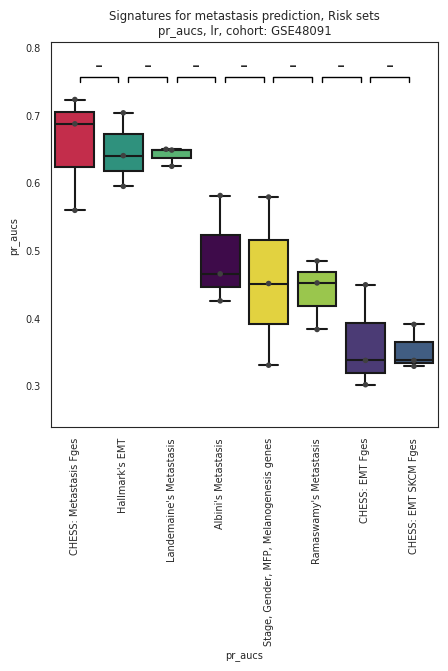

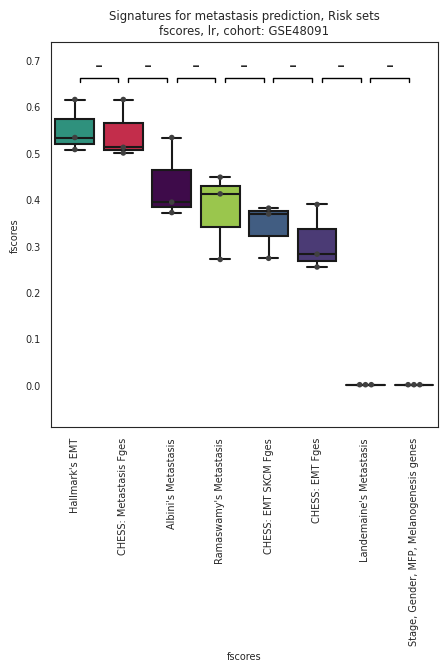

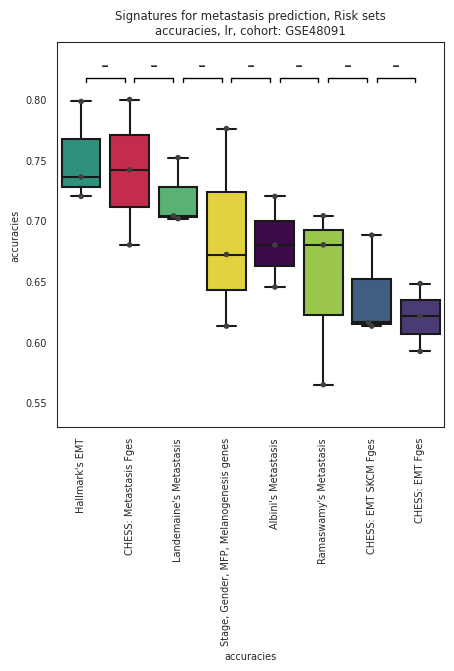

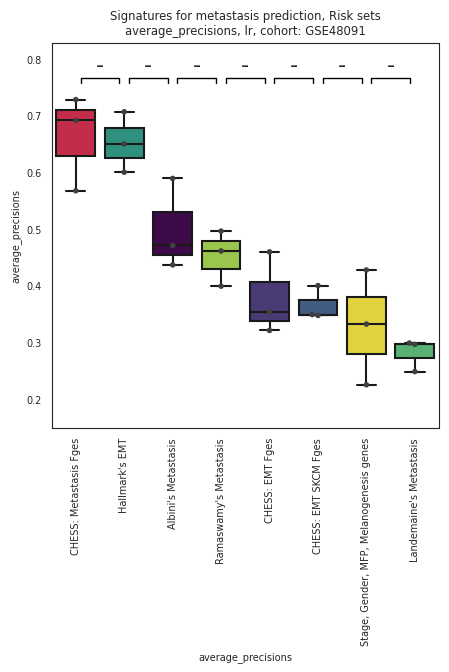

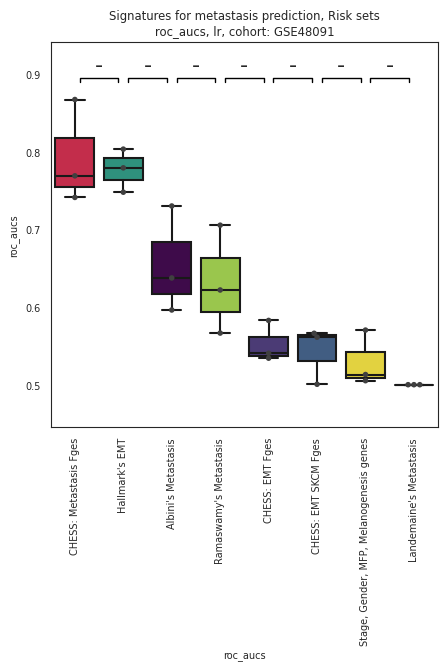

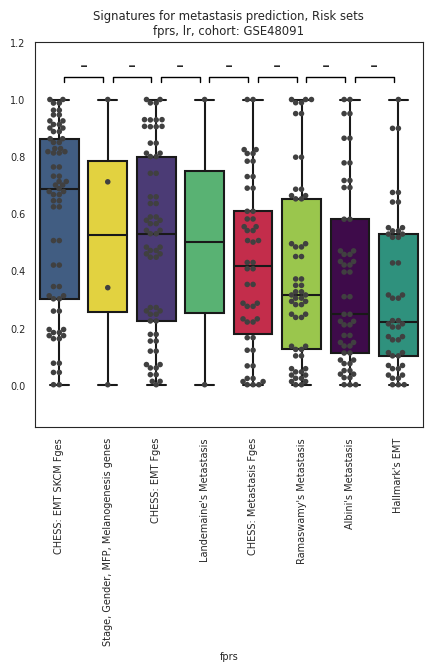

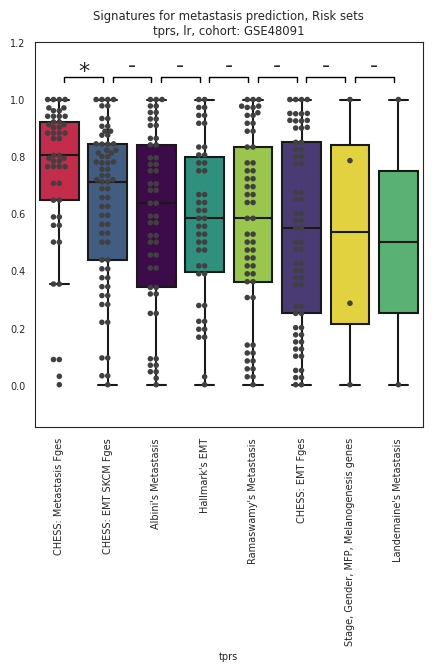

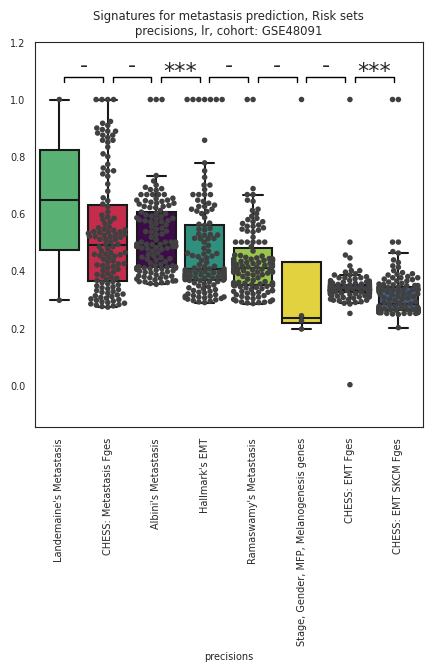

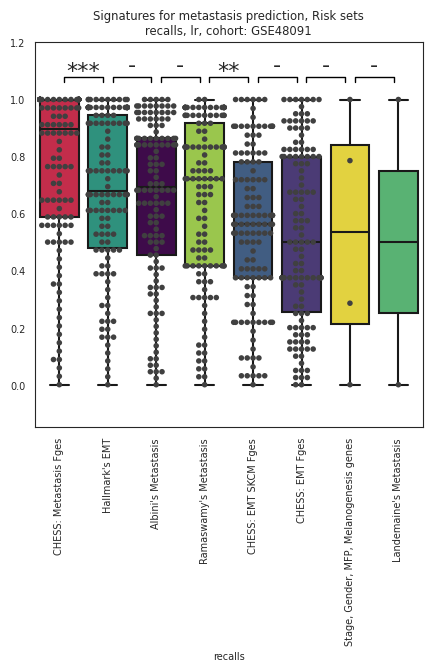

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

plt.rcParams.update({"font.size": 7})
sns.set_style("white")
your_directory = "/home/nlukashevich/"
file_name = "rocsSKCM.pdf"
file_address = your_directory + file_name
with PdfPages(file_address) as pdf:
    dic = dt
    num_scores = ["pr_aucs", "fscores", "accuracies", "average_precisions", "roc_aucs"]
    array_scores = ["fprs", "tprs", "precisions", "recalls"]
    final_values = {i: [] for i in num_scores + array_scores}
    final_labels = {i: [] for i in num_scores + array_scores}
    final_labels_raw = {i: [] for i in num_scores + array_scores}
    for sign in dic.keys():
        typ = pd.DataFrame(dic[sign])
        typ.index = typ.index.map(lambda x: f"{x}_{sign}")
        for name in typ.columns:
            if name in num_scores:
                final_labels[name].append(
                    pd.Series(index=typ[name].index, data=sign_names[sign])
                )
                final_labels_raw[name].append(
                    pd.Series(index=typ[name].index, data=sign)
                )
                final_values[name].append(typ[name])
            else:
                for i in typ[name].index:
                    x = make_series(typ[name].loc[i], sign)
                    final_values[name].append(x)
                    final_labels[name].append(
                        pd.Series(index=x.index, data=sign_names[sign])
                    )
                    final_labels_raw[name].append(pd.Series(index=x.index, data=sign))
    for key in final_values.keys():
        fig, ax = plt.subplots(figsize=(5, 5))
        nums = pd.concat(final_values[key])
        labels = pd.concat(final_labels[key])
        nums = nums[~nums.index.duplicated(keep="first")]
        labels = labels[~labels.index.duplicated(keep="first")]
        pal = lin_colors(labels, cmap=matplotlib.colormaps["viridis"])
        fighter = "CHESS: Metastasis Fges"
        pal[fighter] = "crimson"
        order = nums.groupby(labels).mean().sort_values(ascending=False).index
        boxplot_with_pvalue(nums, labels, s=4, ax=ax, order=order, palette=pal)
        ax.set_xlabel(key)
        ax.set_title(
            f"Signatures for {pred} prediction, {to_add_name}\n{key}, {mod}, cohort: {coh}"
        )
        ax.set_xticklabels(order, rotation=90)
        plt.show()
        plt.tight_layout()
        pdf.savefig(fig, bbox_inches="tight")
        plt.close()

## Precision recall curve

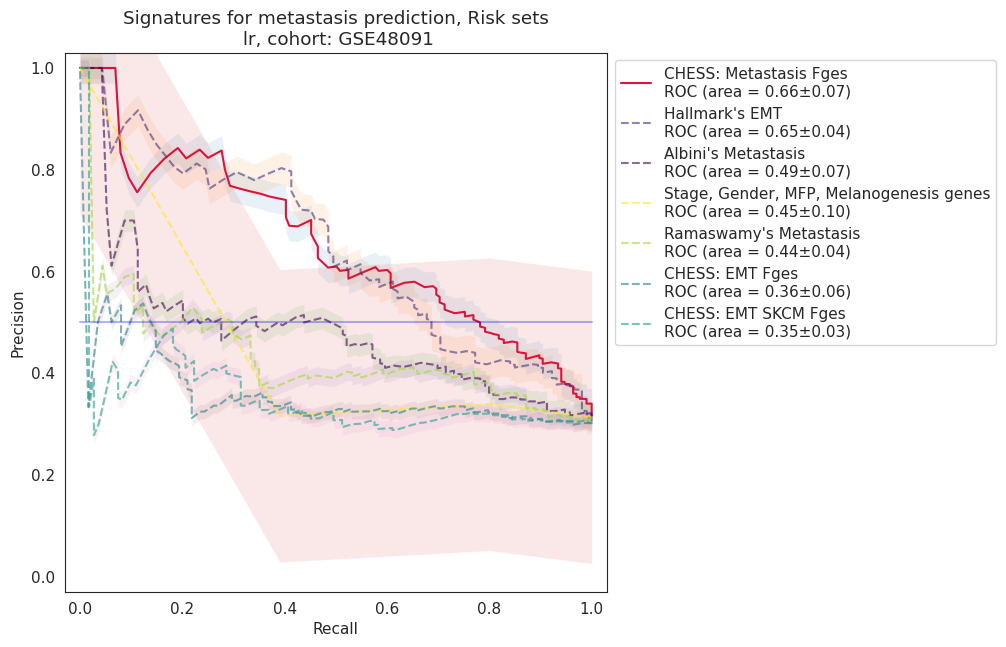

In [ ]:
typ = dt
fig, ax = plt.subplots(figsize=(7, 7))
plt.rcParams.update({"font.size": 11})
pal = lin_colors(pd.Series(typ).index, matplotlib.colormaps["viridis"])
g = "pr_aucs"

d = pd.DataFrame({i: pd.concat(final_values[g]) for i in num_scores})
ls = pd.DataFrame({i: pd.concat(final_labels_raw[g]) for i in num_scores})[g]
order = d[g].groupby(ls).mean().sort_values(ascending=False).index
for i in order:
    auc = round(np.array(pd.DataFrame(typ[i][g]).mean())[0], 4)
    std = round(np.std(np.array(pd.DataFrame(typ[i][g]))), 2)
    fpr = np.array(pd.DataFrame(typ[i]["recalls"]).mean())
    tpr = np.array(pd.DataFrame(typ[i]["precisions"]).mean())
    name = sign_names[i.split("signature: ")[-1]]
    fighter = "Main4_Metastasis_SOLID"
    if i == fighter:
        ax.plot(
            fpr,
            tpr,
            "-",
            label="%s\nROC (area = %0.2f±%0.2f)" % (name, auc, std),
            c="crimson",
        )
        ci = 1.96 * np.std(tpr) / np.sqrt(len(fpr))
        ax.fill_between(fpr, (tpr - ci), (tpr + ci), alpha=0.1)
    elif i == "Landemaine_BRCA_Lung_Met_UP":
        continue
    else:
        ax.plot(
            fpr,
            tpr,
            "--",
            label="%s\nROC (area = %0.2f±%0.2f)" % (name, auc, std),
            alpha=0.6,
            c=pal[i],
        )
        ci = 1.96 * np.std(tpr) / np.sqrt(len(fpr))
        ax.fill_between(fpr, (tpr - ci), (tpr + ci), alpha=0.1)
ax.plot([0, 1], [0.5, 0.5], "b-", alpha=0.3)
ax.set_xlim([-0.03, 1.03])
ax.set_ylim([-0.03, 1.03])
ax.set_ylabel("Precision")
ax.set_xlabel("Recall")
ax.set_title(f"Signatures for {pred} prediction, {to_add_name}\n {mod}, cohort: {coh}")
ax.legend(
    bbox_to_anchor=(1, 1),
    loc="upper left",
)
plt.show()
plt.tight_layout()
plt.close()

## ROC AUC

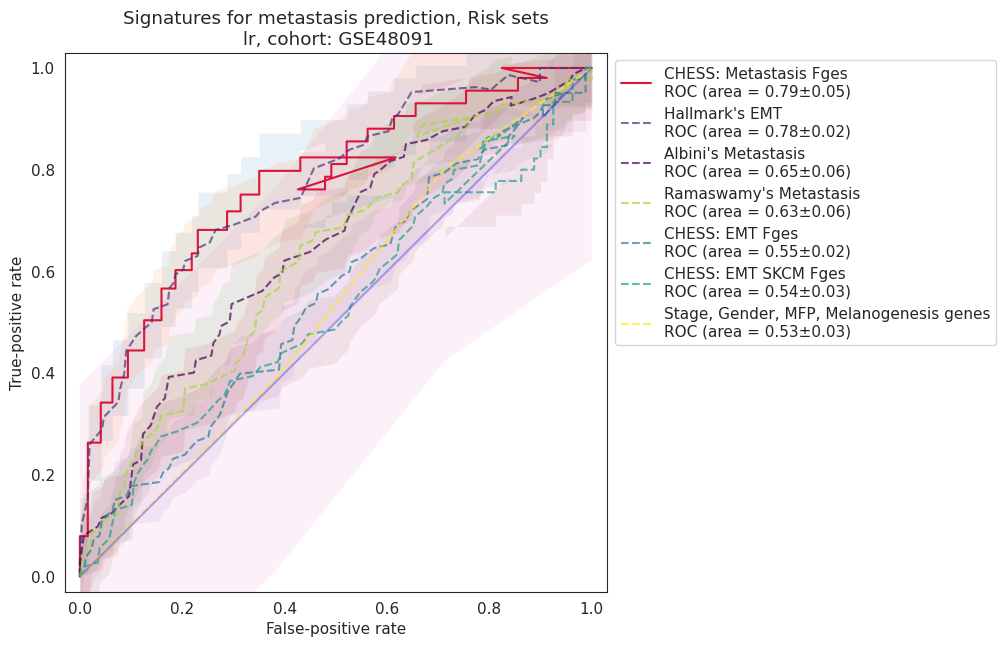

In [ ]:
typ = dt
g = "roc_aucs"
fig, ax = plt.subplots(figsize=(7, 7))
plt.rcParams.update({"font.size": 11})
pal = lin_colors(pd.Series(typ).index, matplotlib.colormaps["viridis"])
d = pd.DataFrame({i: pd.concat(final_values[g]) for i in num_scores})
ls = pd.DataFrame({i: pd.concat(final_labels_raw[g]) for i in num_scores})[g]
order = d[g].groupby(ls).mean().sort_values(ascending=False).index
for i in order:
    auc = round(pd.DataFrame(typ[i][g]).mean()[0], 4)
    std = round(np.std(pd.DataFrame(typ[i][g]))[0], 2)
    fpr = np.array(pd.DataFrame(typ[i]["fprs"]).mean())
    tpr = np.array(pd.DataFrame(typ[i]["tprs"]).mean())
    name = sign_names[i.split("signature: ")[-1]]
    if i == "Main4_Metastasis_SOLID":
        ax.plot(
            fpr,
            tpr,
            "-",
            label="%s\nROC (area = %0.2f±%0.2f)" % (name, auc, std),
            c="crimson",
        )
        ci = 1.96 * np.std(tpr) / np.sqrt(len(fpr))
        ax.fill_between(fpr, (tpr - ci), (tpr + ci), alpha=0.1)
    elif i == "Landemaine_BRCA_Lung_Met_UP":
        continue
    else:
        ax.plot(
            fpr,
            tpr,
            "--",
            label="%s\nROC (area = %0.2f±%0.2f)" % (name, auc, std),
            alpha=0.7,
            c=pal[i],
        )
        ci = 1.96 * np.std(tpr) / np.sqrt(len(fpr))
        ax.fill_between(fpr, (tpr - ci), (tpr + ci), alpha=0.1)
ax.plot([0, 1], [0, 1], "b-", alpha=0.3)
ax.set_xlim([-0.03, 1.03])
ax.set_ylim([-0.03, 1.03])
ax.set_ylabel("True-positive rate")
ax.set_xlabel("False-positive rate")
ax.set_title(f"Signatures for {pred} prediction, {to_add_name}\n {mod}, cohort: {coh}")
ax.legend(
    bbox_to_anchor=(1, 1),
    loc="upper left",
)
plt.show()
plt.tight_layout()
plt.close()

## Barplots

In [ ]:
df = pd.DataFrame({i: pd.concat(final_values[i]) for i in num_scores})
ls = pd.DataFrame({i: pd.concat(final_labels[i]) for i in num_scores})["fscores"]

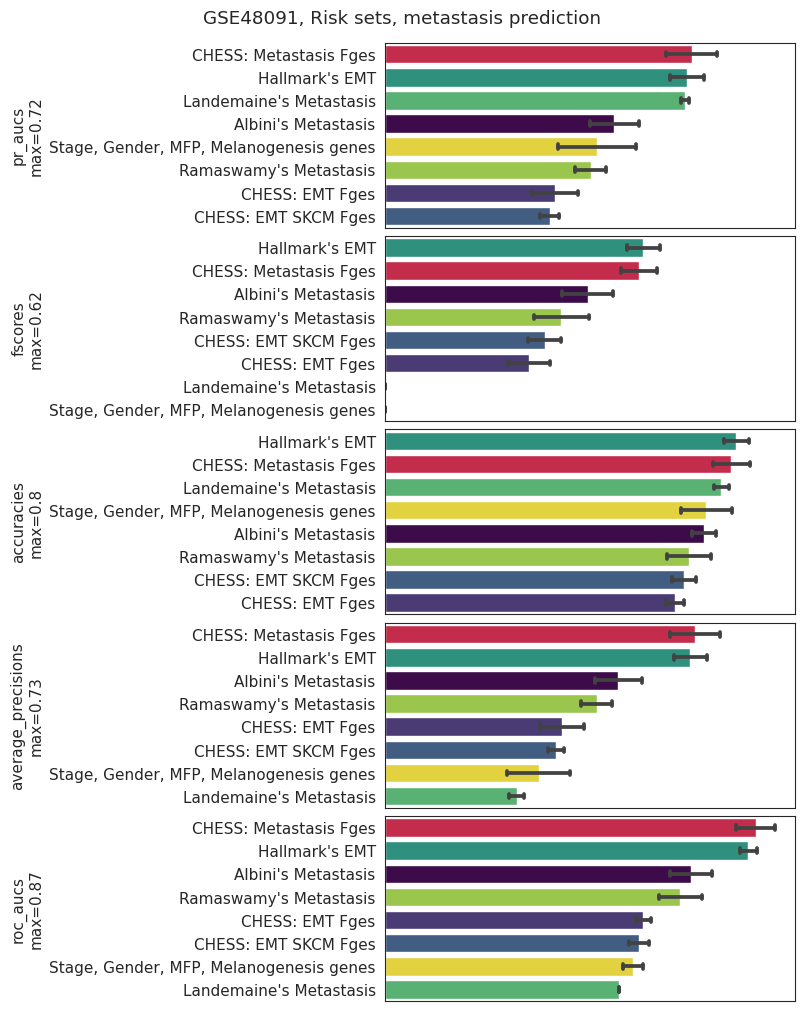

In [ ]:
# defined = ['pr_aucs', 'accuracies', 'roc_aucs']
defined = num_scores
af = axis_matras(
    ys=[2] * len(defined), x_len=8, title=f"{coh}, {to_add_name}, {pred} prediction"
)

pal = lin_colors(ls, matplotlib.colormaps["viridis"])
s = "CHESS: Metastasis Fges"
# s = 'CHESS: EMT SKCM Fges'
pal[s] = "crimson"
for col in defined:
    ax = next(af)
    order = df[col].groupby(ls).mean().sort_values(ascending=False).index
    ax = sns.barplot(
        x=df[col],
        y=ls,
        capsize=0.2,
        ax=ax,
        orient="h",
        estimator=np.mean,
        ci=85,
        palette=pal,
        order=order,
    )
    ax.set_ylabel(f"{col}\nmax={round(df[col].max(),2)}")
    ax.set_xlabel("")
    ax.set_xticks([])
plt.tight_layout(pad=0.5)